In [1]:
import sys
import os
try:
    import warnings                                                   
    warnings.filterwarnings('ignore')     
    import pandas as pd 
    import numpy as np
    import sqlite3
    import watermark
    import pymc3 as pm
    import xarray as xr
    import arviz as az
    import theano.tensor as aet
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.cbook as cbook
    from scipy.special import expit as logistic
    from IPython.display import display, HTML
    from dateutil.relativedelta import relativedelta

except ImportError:
    print("Error: missing one of the libraries..")
    sys.exit()

sys.path.append('../..')
    
from model_utils import *

# hide
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print(sys.argv[0])
print(os.getcwd())
print('Running on pymc3 v{}'.format(pm.__version__))
print('Running on arviz v{}'.format(az.__version__))

Duplicate key in file PosixPath('/Users/marcelino/.matplotlib/stylelib/jotaviz.mplstyle'), line 111 ('lines.markeredgewidth: 0.5 ')
Duplicate key in file PosixPath('/Users/marcelino/.matplotlib/stylelib/jotaviz.mplstyle'), line 150 ('axes.axisbelow: True')
Duplicate key in file PosixPath('/Users/marcelino/.matplotlib/stylelib/jotaviz.mplstyle'), line 111 ('lines.markeredgewidth: 0.5 ')
Duplicate key in file PosixPath('/Users/marcelino/.matplotlib/stylelib/jotaviz.mplstyle'), line 150 ('axes.axisbelow: True')


/Users/marcelino/Library/Python/3.8/lib/python/site-packages/ipykernel_launcher.py
/Users/marcelino/dmarcelinobr/pollbase/dashboards/models
Running on pymc3 v3.11.4
Running on arviz v0.11.2


In [2]:
# Some useful functions

def plot_raw_polls(df, filename, heading=None):
    import datetime
    fig, ax = plt.subplots(figsize=(12, 5))

    min_date = None
    max_date = None
    for col_name in df.columns.values:

        # plot the column
        col = df[col_name]
        col = col[col.notnull()] # drop NAs
        dates = df.index
        ax.plot_date(x=dates, y=col, fmt='-', label=col_name,
            tz=None, xdate=True, ydate=False, linewidth=1.5)

        # establish the date range for the data
        if min_date:
            min_date = min(min_date, min(dates))
        else:
            min_date = min(dates)
        if max_date:
            max_date = max(max_date, max(dates))
        else:
            max_date = max(dates)

    # give a bit of space at each end of the plot - aesthetics
    span = max_date - min_date
    extra = int(span.days * 0.03) * datetime.timedelta(days=1)
    ax.set_xlim([min_date - extra, max_date + extra])

    # format the x tick marks
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_formatter(DateFormatter('\n%b'))
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator(bymonthday=1, interval=2))

    # grid, legend and yLabel
    ax.grid(True)
    ax.legend(loc='best', prop={'size':'large'})
    ax.set_ylabel('% das intenções')

    # heading
    if heading:
        fig.suptitle(heading, fontsize=18)
    fig.tight_layout(pad=1.5)

    # footnote
    fig.text(0.99, 0.00, 'JOTA Labs', ha='right', 
        va='bottom', fontsize=8, color='#999999')

    # save to file
    fig.savefig(filename, dpi=125)

# plot_raw_polls(data[["Bolsonaro"]], "raw_polls")

# Conexão com o banco de dados

In [4]:
con = sqlite3.connect('../../pollingpoints.db')

file_long = pd.read_sql(""" SELECT data_ini, data_fim, nome, empresa, cargo,
turno, candidato, voto, erro, amostra, tipo, modo FROM eleitoral
ORDER BY data_fim;""", con=con) 

con.close()

# file_long.query("empresa == 'Orbis'")

# Converte para datetime 
file_long["date"] = pd.to_datetime(file_long["data_fim"])

# Index by field date
file_long.set_index("date", inplace=True)

# sort by field date
file_long = file_long.sort_index(axis=0)

# extrair date informacation 
file_long['day'] = file_long.index.day
file_long['month'] = file_long.index.month
file_long['week'] = file_long.index.week
file_long['year'] = file_long.index.year


# Create indecisos e branco/nulo
file_long["candidato"] = file_long["candidato"].replace("NS/NR", "Indecisos")
file_long["candidato"] = file_long["candidato"].replace("Branco/Nulo/NS/NR", "Branco/Nulo")


# Replace NA with 1000 interviews 
file_long["amostra"] = file_long["amostra"].replace(np.nan, 1000)

# Convert vote intention rates to proportion 
file_long[["voto", "erro"]] = (file_long[["voto", "erro"]].copy()/100)

# Gerar inteiros a partir das médias 
file_long["num_voto"] = np.floor(file_long["amostra"] * (file_long["voto"])).astype("int")

# Reset the index
file_long = file_long.reset_index().rename(columns={"index": "date"})

# file_long.groupby(by=['data_ini', 'data_fim', 'empresa'],as_index=False).count()

# display(HTML(file_long.to_html()))


# Validações

In [5]:
file_long.groupby(by=['date', 'empresa'],as_index=False).count()

date         empresa  data_ini  data_fim  nome  cargo  turno  \
0  2020-08-31           IDEIA        20        20    20     20     20   
1  2020-12-23       PoderData        11        11    11     11     11   
2  2021-03-01          Paraná        10        10    10     10     10   
3  2021-03-10           Atlas        80        80    80     80     80   
4  2021-03-17       PoderData        20        20    20     20     20   
5  2021-04-14       PoderData        38        38    38     38     38   
6  2021-04-22           IDEIA        10        10    10     10     10   
7  2021-05-12       Datafolha        42        42    42     42     42   
8  2021-05-12       PoderData         9         9     9      9      9   
9  2021-06-04          Ipespe         3         3     3      3      3   
10 2021-06-04  Ranking Brasil        75        75    75     75     75   
11 2021-06-09       PoderData        36        36    36     36     36   
12 2021-06-10          Ipespe        39        39    39     39     39   
13 2021-06-21            Ipec        16        16    16     16     16   
14 2021-06-24           IDEIA        62        62    62     62     62   
15 2021-07-06       PoderData        30        30    30     30     30   
16 2021-07-07          Ipespe        40        40    40     40     40   
17 2021-07-08       Datafolha        38        38    38     38     38   
18 2021-07-08           Orbis        12        12    12     12     12   
19 2021-07-26          Futura        23        23    23     23     23   
20 2021-07-29           Atlas        70        70    70     70     70   
21 2021-08-01          Quaest        58        58    58     58     58   
22 2021-08-04       PoderData        23        23    23     23     23   
23 2021-08-20          Futura        26        26    26     26     26   
24 2021-08-29          Quaest        40        40    40     40     40   
25 2021-09-01       PoderData        35        35    35     35     35   
26 2021-09-04           Atlas        15        15    15     15     15   
27 2021-09-15       Datafolha        37        37    37     37     37   
28 2021-09-20            Ipec         9         9     9      9      9   
29 2021-09-20  Ranking Brasil        49        49    49     49     49   
30 2021-09-24          Futura        14        14    14     14     14   
31 2021-09-29       PoderData         9         9     9      9      9   
32 2021-10-03          Quaest        46        46    46     46     46   
33 2021-10-07      Brasmarket        20        20    20     20     20   
34 2021-10-22          Futura        29        29    29     29     29   
35 2021-10-27       PoderData        32        32    32     32     32   
36 2021-10-28          Ipespe        50        50    50     50     50   
37 2021-11-04      Vox Populi        30        30    30     30     30   
38 2021-11-06          Quaest        68        68    68     68     68   
39 2021-11-15           IDEIA        62        62    62     62     62   
40 2021-11-18         Ponteio        63        63    63     63     63   
41 2021-11-19          Paraná        28        28    28     28     28   
42 2021-11-20          Futura        46        46    46     46     46   
43 2021-11-24       PoderData        33        33    33     33     33   
44 2021-11-26           Atlas        36        36    36     36     36   
45 2021-11-29           Atlas        39        39    39     39     39   

    candidato  voto  erro  amostra  tipo  modo  day  month  week  year  \
0          20    20    20       20    20    20   20     20    20    20   
1          11    11    11       11    11    11   11     11    11    11   
2          10    10    10       10    10    10   10     10    10    10   
3          80    80    80       80    80    80   80     80    80    80   
4          20    20    20       20    20    20   20     20    20    20   
5          38    38    38       38    38    38   38     38    38    38   
6          10    10    10       10    10    10   10     10 

In [6]:
file_long.groupby(by=['candidato'],as_index=False).count()

candidato  date  data_ini  data_fim  nome  empresa  cargo  \
0        Alessandro Vieira     6         6         6     6        6      6   
1          Alexandre Kalil     1         1         1     1        1      1   
2              Branco/Nulo   220       220       220   220      220    220   
3             Cabo Daciolo     3         3         3     3        3      3   
4               Ciro Gomes   141       141       141   141      141    141   
5           Danilo Gentili     6         6         6     6        6      6   
6            Eduardo Leite    60        60        60    60       60     60   
7           Felipe D'Avila    11        11        11    11       11     11   
8          Fernando Haddad    13        13        13    13       13     13   
9              Flavio Dino     6         6         6     6        6      6   
10        Geraldo Alckimin     3         3         3     3        3      3   
11        Guilherme Boulos    13        13        13    13       13     13   
12         Hamilton Mourão     9         9         9     9        9      9   
13       Henrique Mandetta    73        73        73    73       73     73   
14               Indecisos   151       151       151   151      151    151   
15          Jair Bolsonaro   223       223       223   223      223    223   
16             João Amoêdo    19        19        19    19       19     19   
17              João Doria   133       133       133   133      133    133   
18            Luciano Huck    33        33        33    33       33     33   
19             Luiz Datena    30        30        30    30       30     30   
20           Luiza Trajano     2         2         2     2        2      2   
21           Lula da Silva   223       223       223   223      223    223   
22            Marina Silva     9         9         9     9        9      9   
23            Michel Temer     7         7         7     7        7      7   
24  Nem Bolsonaro nem Lula     2         2         2     2        2      2   
25     Não rejeitam nenhum     1         1         1     1        1      1   
26         Outro candidato     4         4         4     4        4      4   
27                  Outros    21        21        21    21       21     21   
28            Paulo Guedes     9         9         9     9        9      9   
29          Rejeitam todos     1         1         1     1        1      1   
30            Rodrigo Maia     3         3         3     3        3      3   
31         Rodrigo Pacheco    32        32        32    32       32     32   
32             Sergio Moro    98        98        98    98       98     98   
33            Simone Tebet     7         7         7     7        7      7   
34        Tasso Jereissati     7         7         7     7        7      7   
35                   Todos     1         1         1     1        1      1   

    turno  voto  erro  amostra  tipo  modo  day  month  week  year  num_voto  
0       6     6     6        6     6     6    6      6     6     6         6  
1       1     1     1        1     1     1    1      1     1     1         1  
2     220   220   220      220   220   220  220    220   220   220       220  
3       3     3     3        3     3     3    3      3     3     3         3  
4     141   141   141      141   141   141  141    141   141   141       141  
5       6     6     6        6     6     6    6      6     6     6         6  
6      60    60    60       60    60    60   60     60    60    60        60  
7      11    11    11       11    11    11   11     11    11    11        11  
8      13    13    13       13    13    13   13     13    13    13        13  
9       6     6     6        6     6     6    6      6     6     6         6  
10      3     3     3        3     3     3    3      3     3     3         3  
11     13    13    13       13    13    13   13     13    13    13        13  
12      9     9     9        9     9     9    9      9     9     9         9  
13     73    73    73   

In [7]:
file_long.groupby(by=['tipo'],as_index=False).count()

tipo  date  data_ini  data_fim  nome  empresa  \
0                                   1         1         1     1        1   
1            Bolsonaro x Boulos     3         3         3     3        3   
2              Bolsonaro x Ciro    56        56        56    56       56   
3            Bolsonaro x Datena     4         4         4     4        4   
4             Bolsonaro x Doria    54        54        54    54       54   
5            Bolsonaro x Haddad     3         3         3     3        3   
6              Bolsonaro x Huck    12        12        12    12       12   
7             Bolsonaro x Leite    10        10        10    10       10   
8              Bolsonaro x Lula   113       113       113   113      113   
9          Bolsonaro x Mandetta    10        10        10    10       10   
10           Bolsonaro x Marina     3         3         3     3        3   
11             Bolsonaro x Moro    38        38        38    38       38   
12          Bolsonaro x Pacheco     4         4         4     4        4   
13             Cenário reduzido     5         5         5     5        5   
14                   Espontânea   192       192       192   192      192   
15                   Estimulada   452       452       452   452      452   
16             Lula x Bolsonaro     3         3         3     3        3   
17    Lula x Bolsonaro x Amoêdo     4         4         4     4        4   
18    Lula x Bolsonaro x Boulos     4         4         4     4        4   
19      Lula x Bolsonaro x Ciro     8         8         8     8        8   
20     Lula x Bolsonaro x Doria     3         3         3     3        3   
21     Lula x Bolsonaro x Dória     5         5         5     5        5   
22      Lula x Bolsonaro x Huck     4         4         4     4        4   
23     Lula x Bolsonaro x Leite     4         4         4     4        4   
24  Lula x Bolsonaro x Mandetta     4         4         4     4        4   
25    Lula x Bolsonaro x Marina     4         4         4     4        4   
26      Lula x Bolsonaro x Moro     8         8         8     8        8   
27     Lula x Bolsonaro x Temer     4         4         4     4        4   
28                  Lula x Ciro    54        54        54    54       54   
29                Lula x Datena     8         8         8     8        8   
30                 Lula x Doria    64        64        64    64       64   
31                  Lula x Huck     2         2         2     2        2   
32                 Lula x Leite    19        19        19    19       19   
33                 Lula x Luiza     4         4         4     4        4   
34              Lula x Mandetta     4         4         4     4        4   
35                  Lula x Moro    52        52        52    52       52   
36               Lula x Pacheco    16        16        16    16       16   
37                       Online    10        10        10    10       10   
38           Potencial negativo    81        81        81    81       81   
39             Potencial neutro    81        81        81    81       81   
40           Potencial positivo    81        81        81    81       81   
41                  Preferência    20        20        20    20       20   
42                     Rejeição    70        70        70    70       70   

    cargo  turno  candidato  voto  erro  amostra  modo  day  month  week  \
0       1      1          1     1     1        1     1    1      1     1   
1       3      3          3     3     3        3     3    3      3     3   
2      56     56         56    56    56       56    56   56     56    56   
3       4      4          4     4     4        4     4    4      4     4   
4      54     54         54    54    54       54    54   54     54    54   
5       3      3          3     3     3        3     3    3      3     3   
6      12     12         12    12    12       12    12   12     12    12   
7      10     10         10    10    10       10    10   10     10    10  

In [8]:
pd.crosstab(file_long.year, file_long.tipo, margins=True)

tipo     Bolsonaro x Boulos  Bolsonaro x Ciro  Bolsonaro x Datena  \
year                                                                
2020  0                   0                 0                   0   
2021  1                   3                56                   4   
All   1                   3                56                   4   

tipo  Bolsonaro x Doria  Bolsonaro x Haddad  Bolsonaro x Huck  \
year                                                            
2020                  0                   0                 0   
2021                 54                   3                12   
All                  54                   3                12   

tipo  Bolsonaro x Leite  Bolsonaro x Lula  Bolsonaro x Mandetta  ...  \
year                                                             ...   
2020                  0                 4                     0  ...   
2021                 10               109                    10  ...   
All                  10               113                    10  ...   

tipo  Lula x Mandetta  Lula x Moro  Lula x Pacheco  Online  \
year                                                         
2020                0            0               0       0   
2021                4           52              16      10   
All                 4           52              16      10   

tipo  Potencial negativo  Potencial neutro  Potencial positivo  Preferência  \
year                                                                          
2020                   0                 0                   0            0   
2021                  81                81                  81           20   
All                   81                81                  81           20   

tipo  Rejeição   All  
year                  
2020         0    31  
2021        70  1550  
All         70  1581  

[3 rows x 44 columns]

In [8]:
pd.crosstab(file_long.year, file_long.turno, margins=True)

turno     1    2   All
year                  
2020     23    8    31
2021   1039  511  1550
All    1062  519  1581

In [9]:
pd.crosstab(file_long.year, file_long.month, margins=True)

month    3   4   5    6    7    8    9   10   11  12   All
year                                                      
2020     0   0   0    0    0   20    0    0    0  11    31
2021   110  48  51  231  213  147  168  177  405   0  1550
All    110  48  51  231  213  167  168  177  405  11  1581

In [10]:
file_long1t = file_long.loc[(file_long['turno'] == 1) & (file_long['tipo'] == 'Estimulada')]

# Descritiva
file_long1t.groupby('candidato').voto.agg(
    voto_max=('max'),
    voto_min=('min'),
    voto_media=('mean'),
    ).round(2)*100.

voto_max  voto_min  voto_media
candidato                                        
Alessandro Vieira       3.0       0.0         1.0
Alexandre Kalil         1.0       1.0         1.0
Branco/Nulo            18.0       1.0         8.0
Cabo Daciolo            2.0       1.0         2.0
Ciro Gomes             14.0       4.0         7.0
Danilo Gentili          2.0       2.0         2.0
Eduardo Leite           5.0       1.0         2.0
Felipe D'Avila          2.0       0.0         0.0
Fernando Haddad        13.0      10.0        12.0
Flavio Dino             1.0       1.0         1.0
Guilherme Boulos        5.0       1.0         2.0
Henrique Mandetta       7.0       1.0         3.0
Indecisos              15.0       2.0         5.0
Jair Bolsonaro         36.0      21.0        29.0
João Amoêdo             5.0       2.0         3.0
João Doria              8.0       1.0         4.0
Luciano Huck            9.0       2.0         5.0
Luiz Datena            11.0       1.0         5.0
Luiza Trajano           4.0       4.0         4.0
Lula da Silva          49.0      17.0        37.0
Marina Silva            2.0       1.0         1.0
Michel Temer            2.0       2.0         2.0
Outros                  4.0       3.0         4.0
Rodrigo Pacheco         5.0       0.0         1.0
Sergio Moro            14.0       3.0         8.0
Simone Tebet            1.0       0.0         1.0
Tasso Jereissati        1.0       1.0         1.0

In [12]:

file_long2t = file_long[file_long['turno'] == 2]

# Descritiva
file_long2t.groupby('candidato').voto.agg(
    voto_max=('max'),
    voto_min=('min'),
    voto_media=('mean'),
    ).round(2)*100.

voto_max  voto_min  voto_media
candidato                                        
Branco/Nulo            42.0       3.0        20.0
Ciro Gomes             52.0      15.0        34.0
Eduardo Leite          40.0      14.0        24.0
Fernando Haddad        43.0      43.0        43.0
Guilherme Boulos       30.0      30.0        30.0
Henrique Mandetta      47.0      25.0        37.0
Indecisos              32.0       1.0         6.0
Jair Bolsonaro         44.0      24.0        36.0
João Doria             46.0      10.0        28.0
Luciano Huck           48.0      24.0        37.0
Luiz Datena            33.0      17.0        25.0
Luiza Trajano          17.0      17.0        17.0
Lula da Silva          59.0      31.0        49.0
Marina Silva           36.0      36.0        36.0
Rodrigo Pacheco        33.0      12.0        17.0
Sergio Moro            39.0      22.0        32.0

In [14]:
media_1t = file_long1t.pivot_table(index=["data_fim","empresa", "turno", "modo"], 
                    columns='candidato', 
                    values='voto',
                    margins=True,   # add margins
                    aggfunc='mean') # sum margins(rows/columns)


media_2t = file_long2t.pivot_table(index=["data_fim","empresa", "turno", "modo"], 
                    columns='candidato', 
                    values='voto',
                    margins=True,   # add margins
                    aggfunc='mean') # sum margins(rows/columns)

In [11]:

file_wide = file_long1t.pivot_table(index=["empresa", "turno", "modo", "tipo"], 
                    columns='candidato', 
                    values='voto')
        
# Tabela pronta para análise:
file_wide.query("tipo == 'Estimulada' | tipo == 'Intenção'")

candidato                                   Alessandro Vieira  \
empresa        turno modo       tipo                            
Atlas          1     Online     Estimulada                NaN   
Brasmarket     1     CATI       Estimulada                NaN   
Datafolha      1     Presencial Estimulada                NaN   
Futura         1     CATI       Estimulada                NaN   
IDEIA          1     CATI       Estimulada              0.010   
Ipec           1     Presencial Estimulada                NaN   
Ipespe         1     CATI       Estimulada              0.000   
Orbis          1     Internet   Estimulada                NaN   
Paraná         1     CATI       Estimulada                NaN   
                     Presencial Estimulada              0.004   
PoderData      1     IVR        Estimulada              0.015   
Ponteio        1     CATI       Estimulada                NaN   
Quaest         1     Presencial Estimulada                NaN   
Ranking Brasil 1     CATI       Estimulada                NaN   
Vox Populi     1     Presencial Estimulada                NaN   

candidato                                   Alexandre Kalil  Branco/Nulo  \
empresa        turno modo       tipo                                       
Atlas          1     Online     Estimulada            0.007     0.044500   
Brasmarket     1     CATI       Estimulada              NaN     0.105000   
Datafolha      1     Presencial Estimulada              NaN     0.100000   
Futura         1     CATI       Estimulada              NaN     0.067000   
IDEIA          1     CATI       Estimulada              NaN     0.050000   
Ipec           1     Presencial Estimulada              NaN     0.100000   
Ipespe         1     CATI       Estimulada              NaN     0.096667   
Orbis          1     Internet   Estimulada              NaN     0.045000   
Paraná         1     CATI       Estimulada              NaN     0.125000   
                     Presencial Estimulada              NaN     0.099000   
PoderData      1     IVR        Estimulada              NaN     0.077273   
Ponteio        1     CATI       Estimulada              NaN     0.100000   
Quaest         1     Presencial Estimulada              NaN     0.047500   
Ranking Brasil 1     CATI       Estimulada              NaN     0.167650   
Vox Populi     1     Presencial Estimulada              NaN     0.100000   

candidato                                   Cabo Daciolo  Ciro Gomes  \
empresa        turno modo       tipo                                   
Atlas          1     Online     Estimulada           NaN    0.069000   
Brasmarket     1     CATI       Estimulada           NaN    0.075000   
Datafolha      1     Presencial Estimulada           NaN    0.076667   
Futura         1     CATI       Estimulada           NaN    0.071200   
IDEIA          1     CATI       Estimulada          0.01    0.090000   
Ipec           1     Presencial Estimulada           NaN    0.075000   
Ipespe         1     CATI       Estimulada           NaN    0.083333   
Orbis          1     Internet   Estimulada           NaN    0.068000   
Paraná         1     CATI       Estimulada           NaN    0.100000   
                     Presencial Estimulada           NaN    0.061000   
PoderData      1     IVR        Estimulada          0.02    0.068000   
Ponteio        1     CATI       Estimulada           NaN    0.080000   
Quaest         1     Presencial Estimulada           NaN    0.085000   
Ranking Brasil 1     CATI       Estimulada           NaN    0.052150   
Vox Populi     1     Presencial Estimulada           NaN    0.040000   

candidato                                   Danilo Gentili  Eduardo Leite  \
empresa        turno modo       tipo                                        
Atlas          1     Online     Estimulada          0.0235         0.0285   
Brasmarket     1     CATI       Estimulada             NaN         0.0200   
Datafolha      1     Presencial Estimulada             NaN         0

In [12]:
# Query para filtrar dados de interesse: 1 turno e pesquisas de intenção de votos apenas
file_long_sub = file_long.query("tipo == 'Estimulada'  & turno==1 | tipo == 'Intenção' & turno==1")


data_sub = file_long_sub.pivot_table(index=['date', 'data_fim', 'day', 'month', 'year', 'empresa', 'turno', 'tipo', 'modo', 'amostra'], 
                    columns=['candidato'], 
                    values='voto').reset_index()
    
data_sub["Jair Bolsonaro"] = data_sub.groupby(["year", "month"])["Jair Bolsonaro"].transform(lambda x: x.fillna(method='ffill'))
data_sub["Lula da Silva"] = data_sub.groupby(["year", "month"])["Lula da Silva"].transform(lambda x: x.fillna(method='ffill'))
data_sub["Ciro Gomes"] = data_sub.groupby(["year", "month"])["Ciro Gomes"].transform(lambda x: x.fillna(method='ffill'))
data_sub["Sergio Moro"] = data_sub.groupby(["year", "month"])["Sergio Moro"].transform(lambda x: x.fillna(method='ffill'))

data_sub["Jair Bolsonaro"] = data_sub.groupby(["year", "month"])["Jair Bolsonaro"].transform(lambda x: x.fillna(method='bfill'))
data_sub["Lula da Silva"] = data_sub.groupby(["year", "month"])["Lula da Silva"].transform(lambda x: x.fillna(method='bfill'))
data_sub["Ciro Gomes"] = data_sub.groupby(["year", "month"])["Ciro Gomes"].transform(lambda x: x.fillna(method='bfill'))
data_sub["Sergio Moro"] = data_sub.groupby(["year", "month"])["Sergio Moro"].transform(lambda x: x.fillna(method='bfill'))

POLLSTERS = data_sub["empresa"].sort_values().unique()
comment = f"""A base de pesquisas contaim {len(data_sub)} pesquisas realizadas entre {data_sub["year"].min()} e {data_sub["year"].max()}.
Existem {len(POLLSTERS)} empresas de pesquisa: {', '.join(list(POLLSTERS))}
"""
print(comment)

# display(HTML(data_sub.to_html()))

A base de pesquisas contaim 49 pesquisas realizadas entre 2020 e 2021.
Existem 14 empresas de pesquisa: Atlas, Brasmarket, Datafolha, Futura, IDEIA, Ipec, Ipespe, Orbis, Paraná, PoderData, Ponteio, Quaest, Ranking Brasil, Vox Populi



In [13]:
# Query para filtrar dados de interesse: 1 turno e pesquisas de intenção de votos apenas
file_long_sub = file_long.query("tipo == 'Estimulada' | tipo == 'Intenção' & turno==1")

# Converte para datetime 
file_long_sub["date"] = pd.to_datetime(file_long_sub["date"])

# Index by field date
file_long_sub.set_index("date", inplace=True)

data = file_long_sub.groupby(["candidato", "empresa"]).resample("W").mean().reset_index(level=0).sort_index()

data

candidato  turno   voto   erro  amostra   day  \
empresa    date                                                               
Atlas      2021-03-14   Alexandre Kalil    1.0  0.007  0.030   3721.0  10.0   
           2021-03-14       Branco/Nulo    1.0  0.061  0.030   3721.0  10.0   
           2021-03-14        Ciro Gomes    1.0  0.075  0.030   3721.0  10.0   
           2021-03-14       Flavio Dino    1.0  0.007  0.030   3721.0  10.0   
           2021-03-14  Guilherme Boulos    1.0  0.009  0.030   3721.0  10.0   
...                                 ...    ...    ...    ...      ...   ...   
Vox Populi 2021-11-07        João Doria    1.0  0.010  0.022   2000.0   4.0   
           2021-11-07       Luiz Datena    1.0  0.030  0.022   2000.0   4.0   
           2021-11-07     Lula da Silva    1.0  0.440  0.022   2000.0   4.0   
           2021-11-07   Rodrigo Pacheco    1.0  0.000  0.022   2000.0   4.0   
           2021-11-07       Sergio Moro    1.0  0.030  0.022   2000.0   4.0   

                       month  week    year  num_voto  
empresa    date                                       
Atlas      2021-03-14    3.0  10.0  2021.0      26.0  
           2021-03-14    3.0  10.0  2021.0     226.0  
           2021-03-14    3.0  10.0  2021.0     279.0  
           2021-03-14    3.0  10.0  2021.0      26.0  
           2021-03-14    3.0  10.0  2021.0      33.0  
...                      ...   ...     ...       ...  
Vox Populi 2021-11-07   11.0  44.0  2021.0      20.0  
           2021-11-07   11.0  44.0  2021.0      60.0  
           2021-11-07   11.0  44.0  2021.0     880.0  
           2021-11-07   11.0  44.0  2021.0       0.0  
           2021-11-07   11.0  44.0  2021.0      60.0  

[2543 rows x 10 columns]

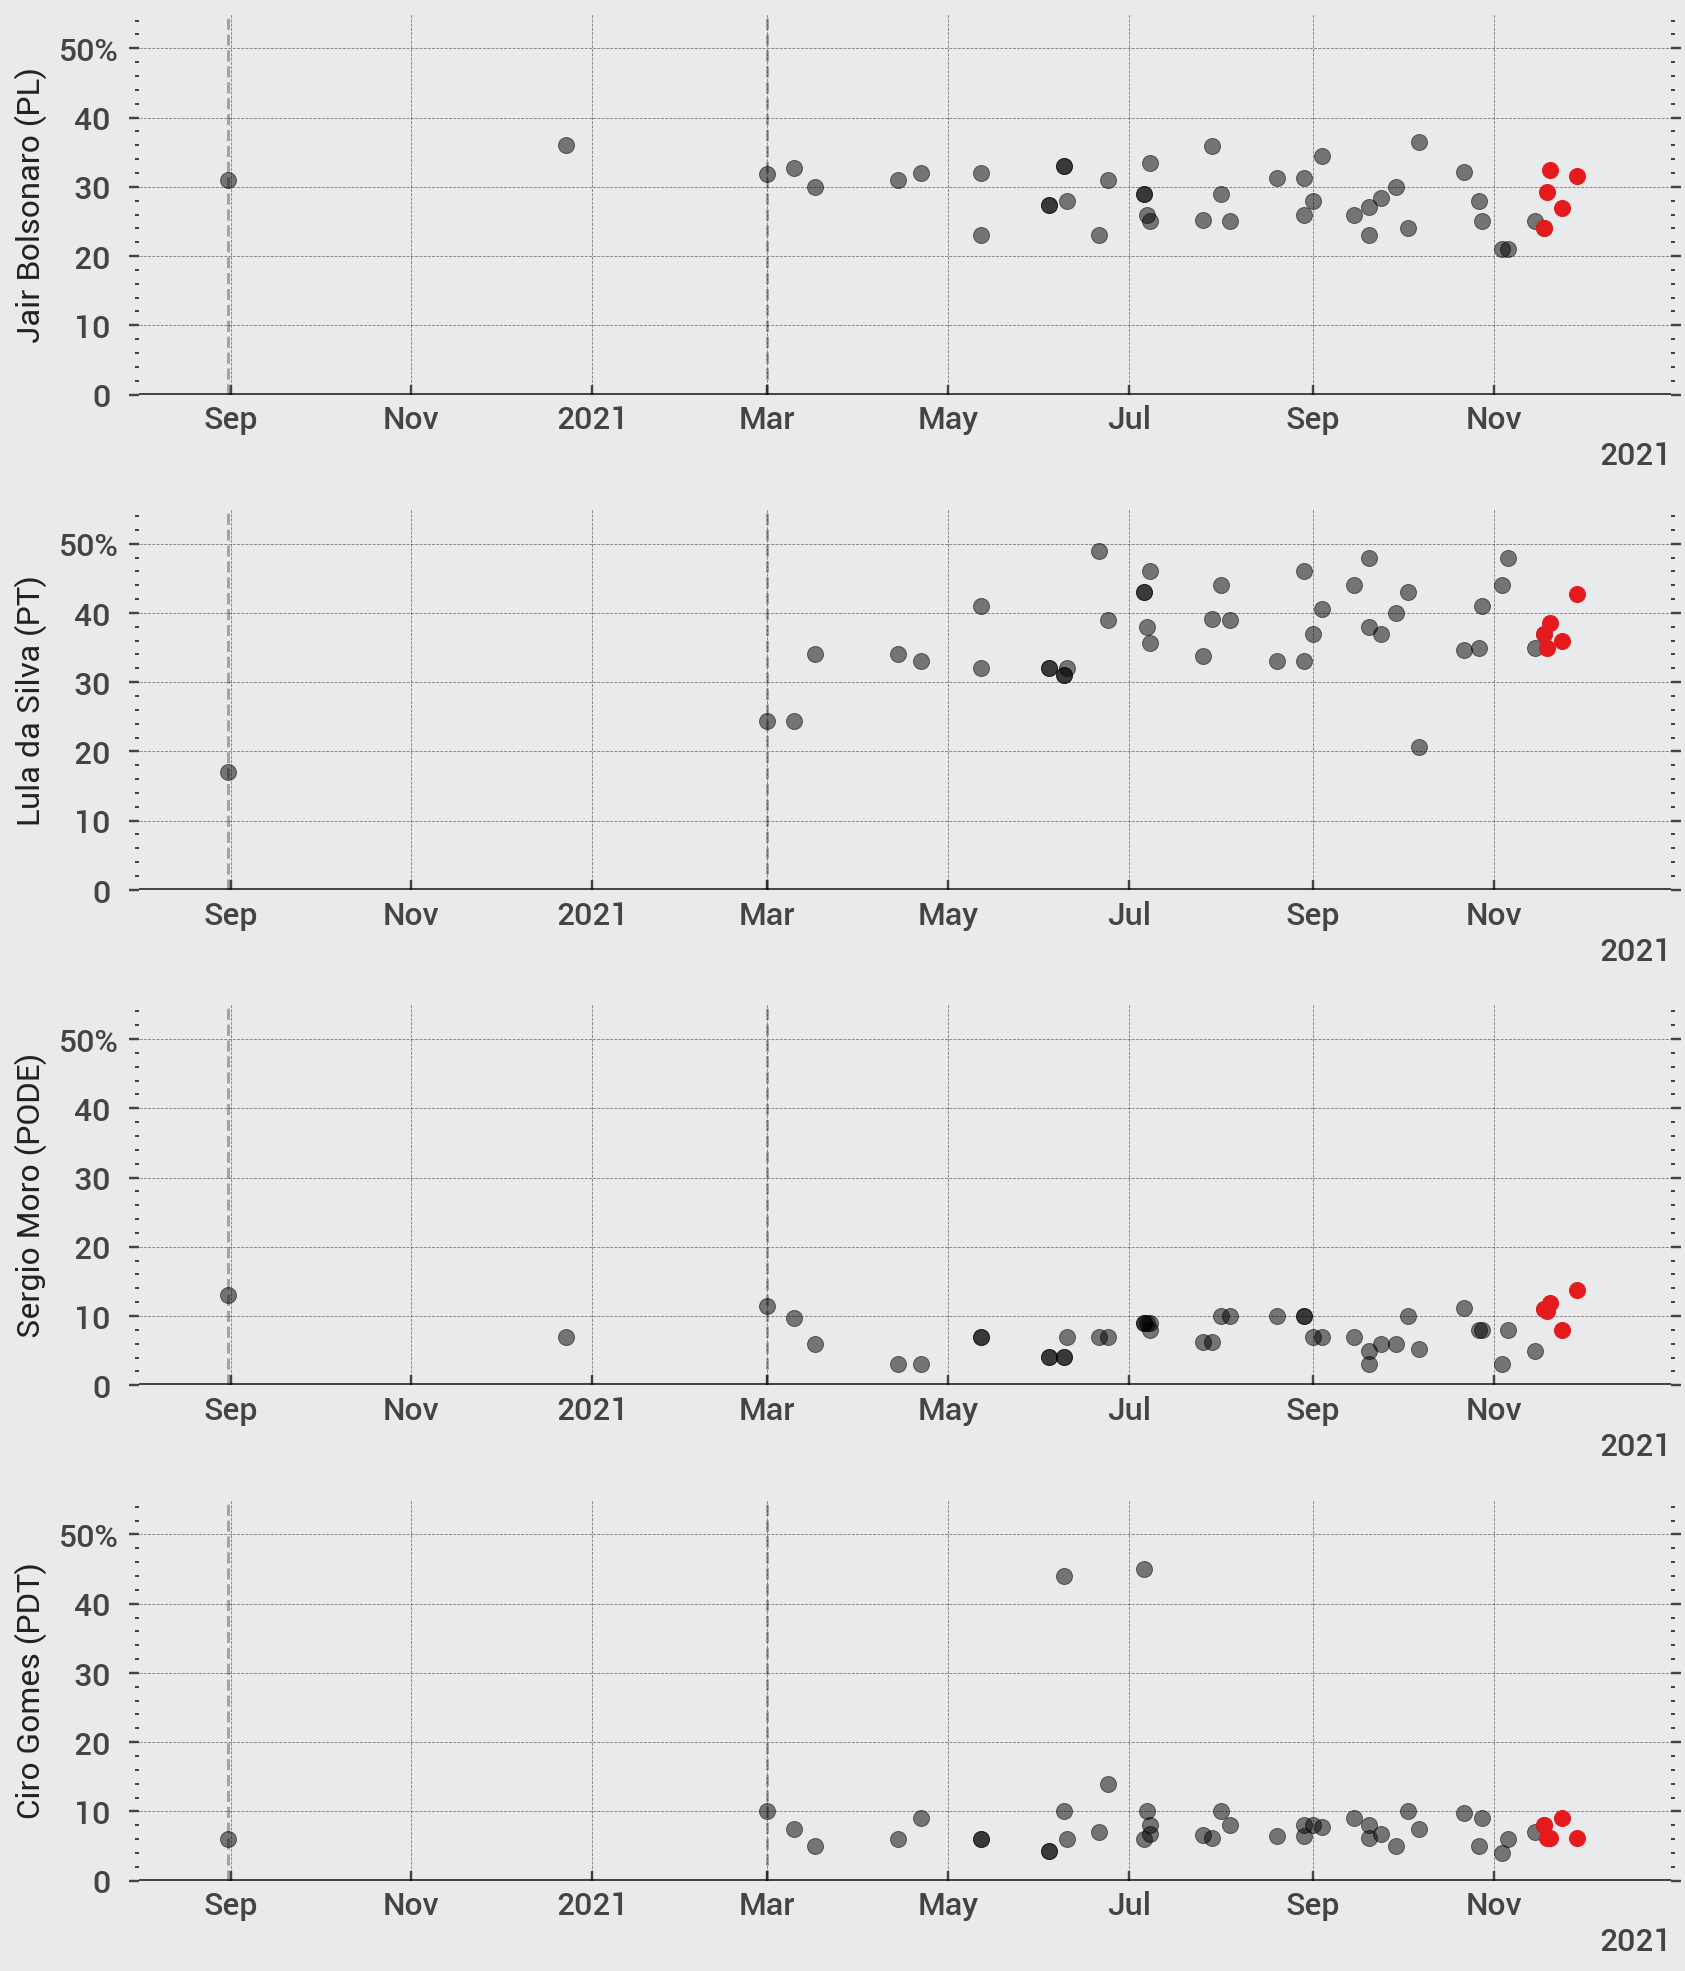

In [44]:
bolsonaro_rates = data_sub["Jair Bolsonaro"].values
lula_rates = data_sub["Lula da Silva"].values
moro_rates = data_sub["Sergio Moro"].values
ciro_rates = data_sub["Ciro Gomes"].values


other_rates = 100 - bolsonaro_rates - lula_rates - moro_rates - ciro_rates

newterm_dates = data_sub.reset_index().groupby("year").first()["date"].values
dates = data_sub.date

with plt.style.context(['jotaviz']):
    fig, axes = plt.subplots(4, figsize=(12, 14))
    for ax, rate, label in zip(
        axes.ravel(),
        [bolsonaro_rates, lula_rates, moro_rates, ciro_rates],
        ["Jair Bolsonaro (PL)", "Lula da Silva (PT)", "Sergio Moro (PODE)", "Ciro Gomes (PDT)"],):
        
        ax.plot(dates[:-5], rate[:-5], "o", color="k", alpha=0.5)
        ax.plot(dates[-5:], rate[-5:], "o")
        ax.set_ylim(0, .55)
        ax.set_ylabel(label)
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
        ax.set_xlim([datetime.date(2020, 8, 1), datetime.date(2021, 12, 31)])
        ax.set_yticks(ticks = [.0, .10, .20, .30, .40, .50])
        ax.set_yticklabels(labels = ['0 ', '10 ', '20 ', '30 ', '40 ', '50%'])
        
        for date in newterm_dates:
            ax.axvline(date, color="k", alpha=0.3, linestyle="--")
            fig.tight_layout();
            
        plt.savefig('../figures/front_runners_observed.png', dpi=300)

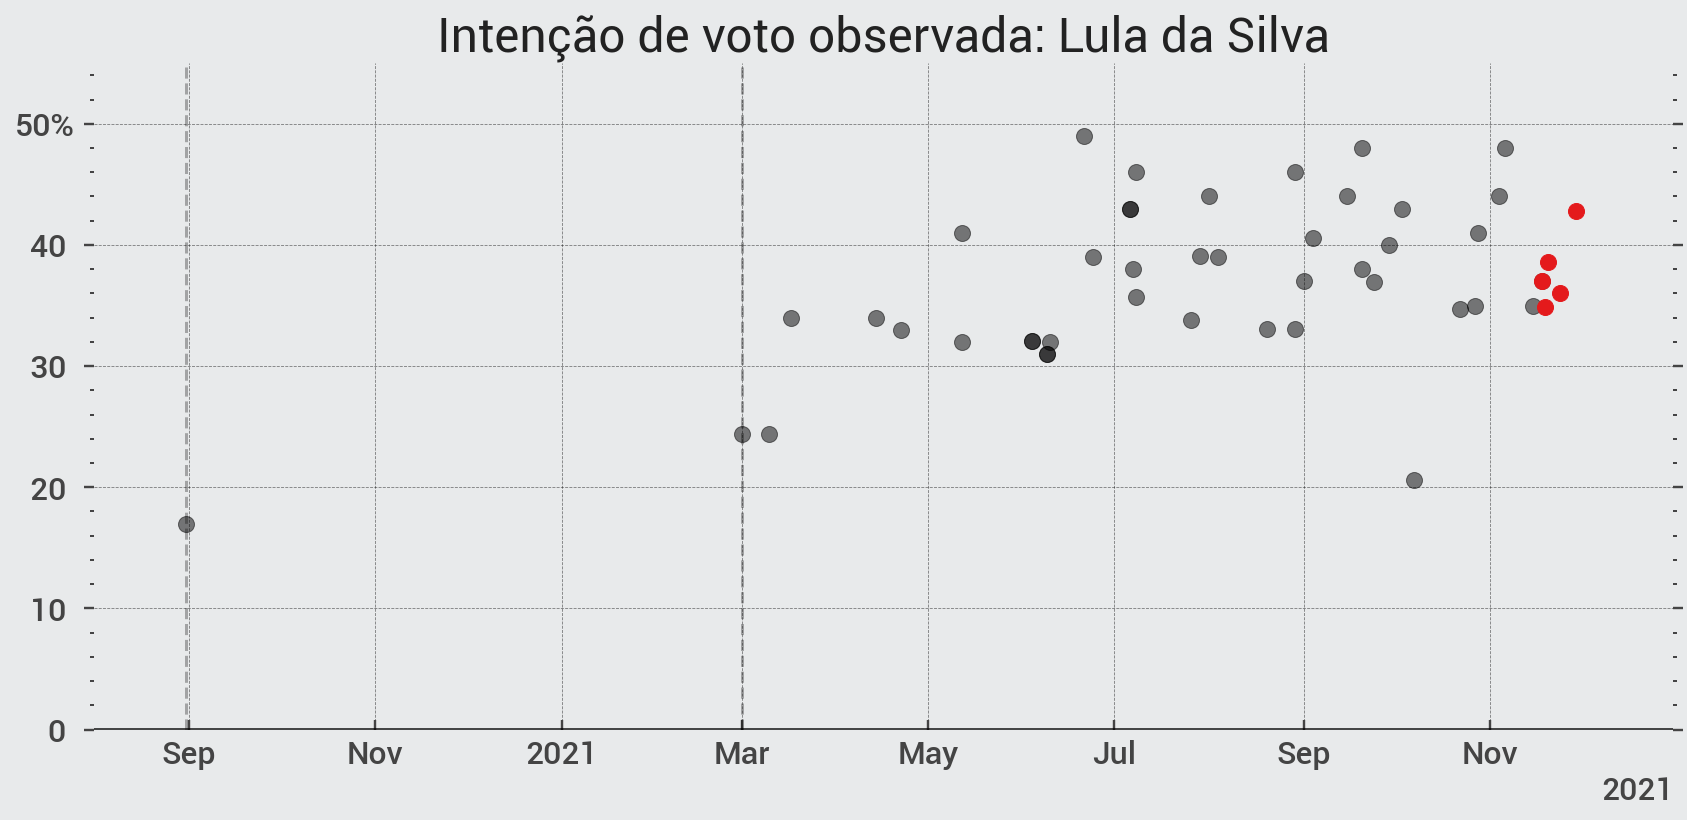

In [53]:
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates[:-5], lula_rates[:-5], "o", color="k", alpha=0.5)
    ax.plot(dates[-5:], lula_rates[-5:], "o")
    ax.set_ylim(0, .55)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xlim([datetime.date(2020, 8, 1), datetime.date(2021, 12, 31)])
    ax.set_title(f"Intenção de voto observada: Lula da Silva", fontsize=24)
    ax.set_yticks(ticks = [.0, .10, .20, .30, .40, .50])
    ax.set_yticklabels(labels = ['0 ', '10 ', '20 ', '30 ', '40 ', '50%'])
        
    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.3, linestyle="--")
        fig.tight_layout();
            
    plt.savefig('../figures/lula_observed.png', dpi=300)

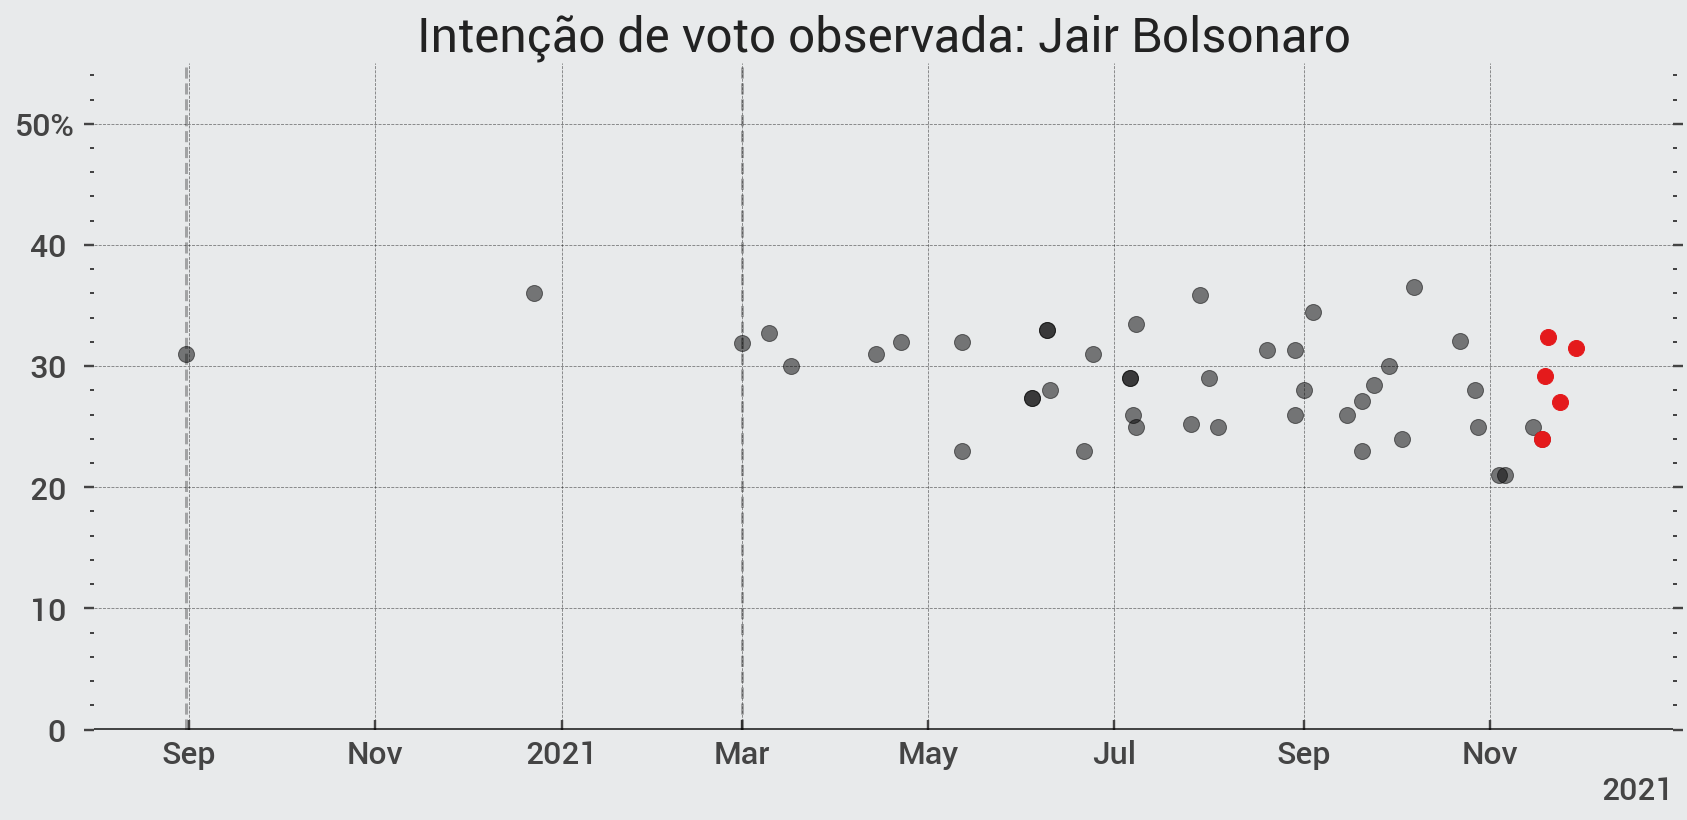

In [54]:
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates[:-5], bolsonaro_rates[:-5], "o", color="k", alpha=0.5)
    ax.plot(dates[-5:], bolsonaro_rates[-5:], "o")
    ax.set_ylim(0, .55)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xlim([datetime.date(2020, 8, 1), datetime.date(2021, 12, 31)])
    ax.set_title(f"Intenção de voto observada: Jair Bolsonaro", fontsize=24)
    ax.set_yticks(ticks = [.0, .10, .20, .30, .40, .50])
    ax.set_yticklabels(labels = ['0 ', '10 ', '20 ', '30 ', '40 ', '50%'])
        
    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.3, linestyle="--")
        fig.tight_layout();
            
    plt.savefig('../figures/bolsonaro_observed.png', dpi=300)

In [49]:
rolling_std = (
    data_sub.reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "Jair Bolsonaro", "Lula da Silva", "Sergio Moro", "Ciro Gomes", "João Doria"]]
)

# rolling_std.rename(columns = {'Bolsonaro':'Jair Bolsonaro'}, inplace = True)

rolling_std


candidato  year  month  Jair Bolsonaro  Lula da Silva  Sergio Moro  \
0          2020      8             NaN            NaN          NaN   
1          2020     12             NaN            NaN          NaN   
2          2021      3        0.013868       0.067882     0.028042   
3          2021      4        0.007071       0.007071          NaN   
4          2021      5        0.063640       0.063640          NaN   
5          2021      6        0.038198       0.076250     0.020718   
6          2021      7        0.046312       0.045500     0.013650   
7          2021      8        0.028733       0.057593          NaN   
8          2021      9        0.035608       0.040841     0.017078   
9          2021     10        0.051910       0.087657     0.022874   
10         2021     11        0.044118       0.048418     0.036121   

candidato  Ciro Gomes  João Doria  
0                 NaN         NaN  
1                 NaN         NaN  
2            0.025000    0.011533  
3            0.021213    0.000000  
4            0.000000    0.007071  
5            0.149814    0.021507  
6            0.143284    0.015630  
7            0.014742    0.011358  
8            0.013647    0.005314  
9            0.020526    0.014422  
10           0.014948    0.012375

In [72]:
data_sub["modo"].value_counts()

CATI          19
IVR           13
Presencial    12
Online         4
Internet       1
Name: modo, dtype: int64

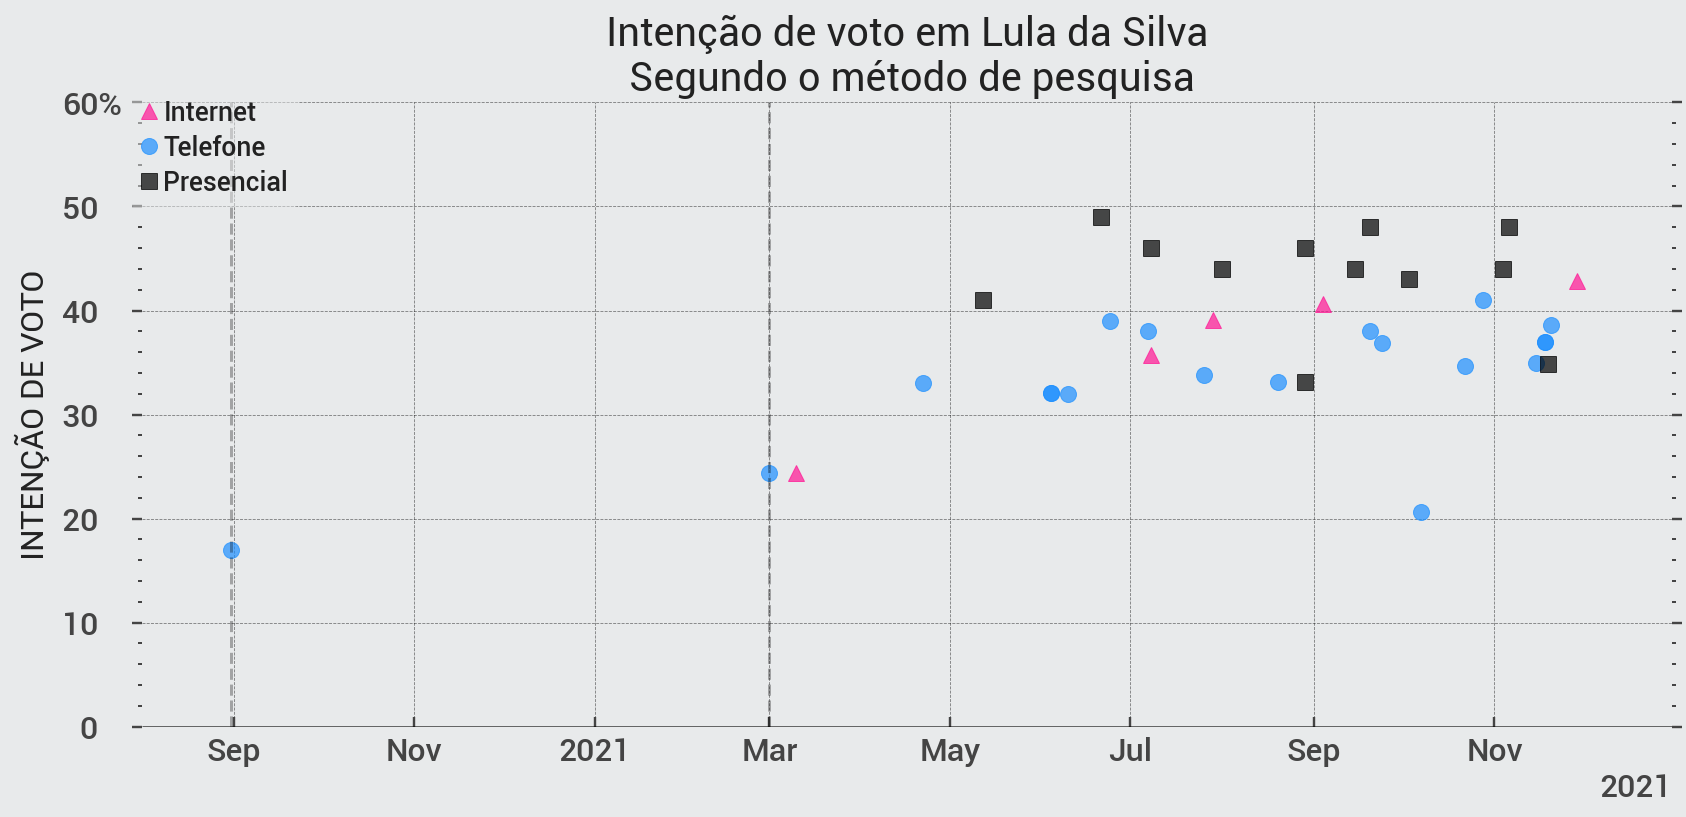

In [55]:
import matplotlib.dates as mdates

# dados
precencial = data_sub[(data_sub["modo"] == "Presencial")]
dates_precencial = precencial.date

telefone = data_sub[(data_sub["modo"] == "CATI") | (data_sub["modo"] == "IRV")]
dates_telefone = telefone.date

internet = data_sub[(data_sub["modo"] == "Internet") | (data_sub["modo"] == "Online")]
dates_internet = internet.date


# Plot
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(dates_internet, internet["Lula da Silva"].values, "^", alpha=0.7, label="Internet", color="deeppink")
    ax.plot(dates_telefone, telefone["Lula da Silva"].values, "o", alpha=0.7, label="Telefone", color="dodgerblue")
    ax.plot(dates_precencial, precencial["Lula da Silva"].values, "s", alpha=0.7, label="Presencial", color="black")
    ax.set_yticks(ticks = [.0, .10, .20, .30, .40, .50, .60])
    ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50   ', '60%'])
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_ylabel(f"INTENÇÃO DE VOTO")
    ax.set_title(f"Intenção de voto em Lula da Silva\n Segundo o método de pesquisa", fontsize=20)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left', frameon=True)
    ax.set_xlim([datetime.date(2020, 8, 1), datetime.date(2021, 12, 31)])
    
    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.3, linestyle="--")
        fig.tight_layout();
        
    plt.savefig('../figures/intencao_voto_Lula_vs_modo.png', dpi=300)


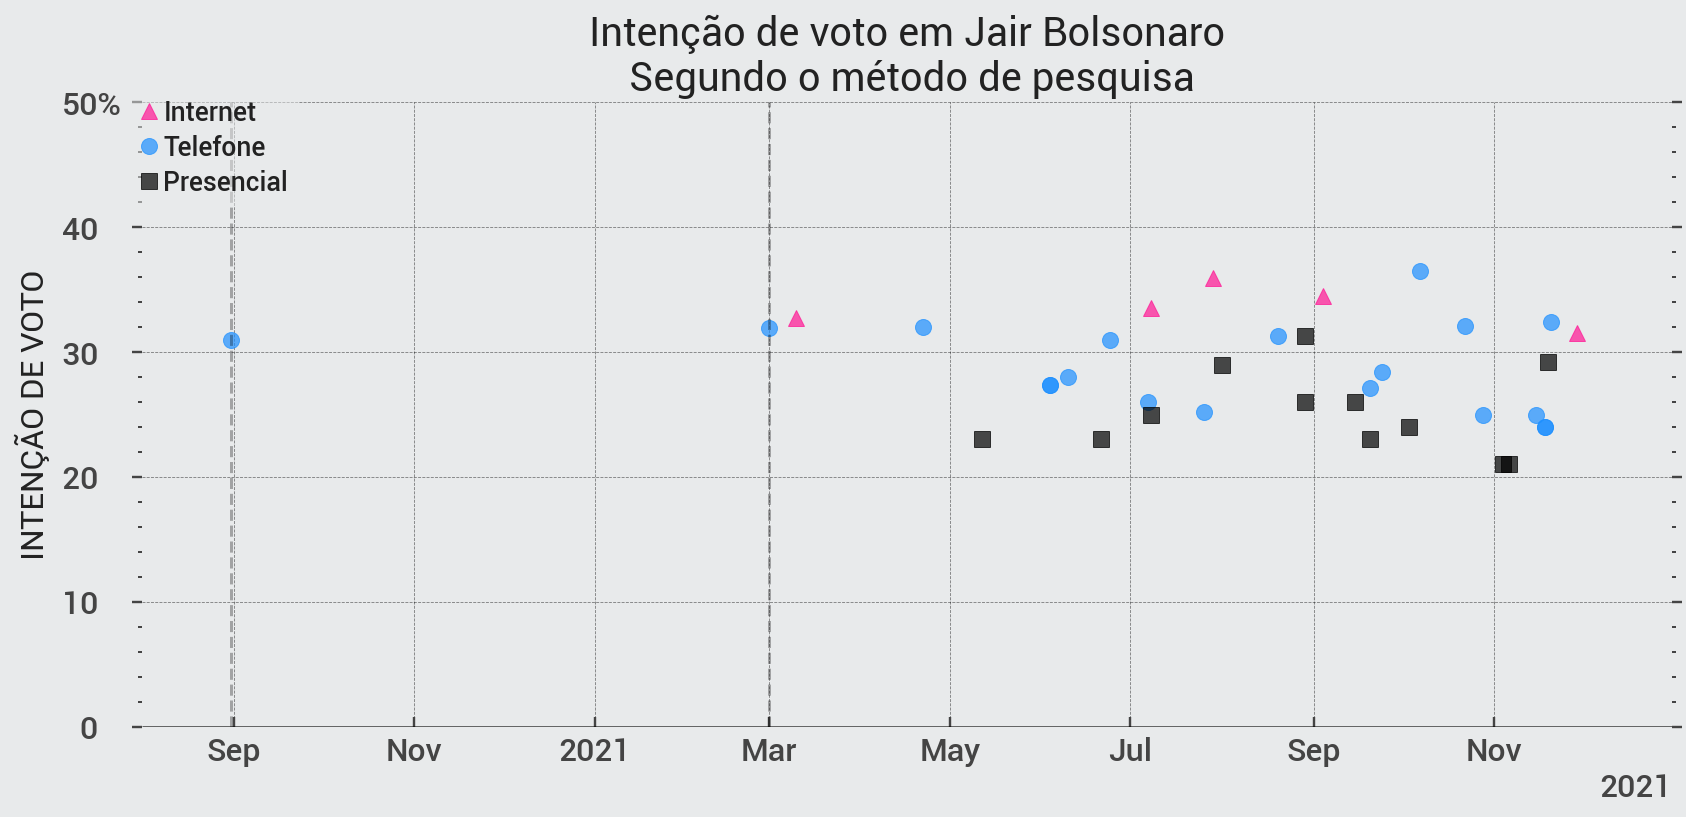

In [56]:
import matplotlib.dates as mdates
# dados
precencial = data_sub[(data_sub["modo"] == "Presencial")]
dates_precencial = precencial.date

telefone = data_sub[(data_sub["modo"] == "CATI") | (data_sub["modo"] == "IRV")]
dates_telefone = telefone.date

internet = data_sub[(data_sub["modo"] == "Internet") | (data_sub["modo"] == "Online")]
dates_internet = internet.date


# Plot
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(dates_internet, internet["Jair Bolsonaro"].values, "^", alpha=0.7, label="Internet", color="deeppink")
    ax.plot(dates_telefone, telefone["Jair Bolsonaro"].values, "o", alpha=0.7, label="Telefone", color="dodgerblue")
    ax.plot(dates_precencial, precencial["Jair Bolsonaro"].values, "s", alpha=0.7, label="Presencial", color="black")
    ax.set_yticks(ticks = [.0, .10, .20, .30, .40, .50])
    ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50%'])
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_ylabel(f"INTENÇÃO DE VOTO")
    ax.set_title(f"Intenção de voto em Jair Bolsonaro\n Segundo o método de pesquisa", fontsize=20)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left', frameon=True)
    ax.set_xlim([datetime.date(2020, 8, 1), datetime.date(2021, 12, 31)])

    
    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.3, linestyle="--")
        fig.tight_layout();
        
    plt.savefig('../figures/intencao_voto_Bolsonaro_vs_modo.png', dpi=300)

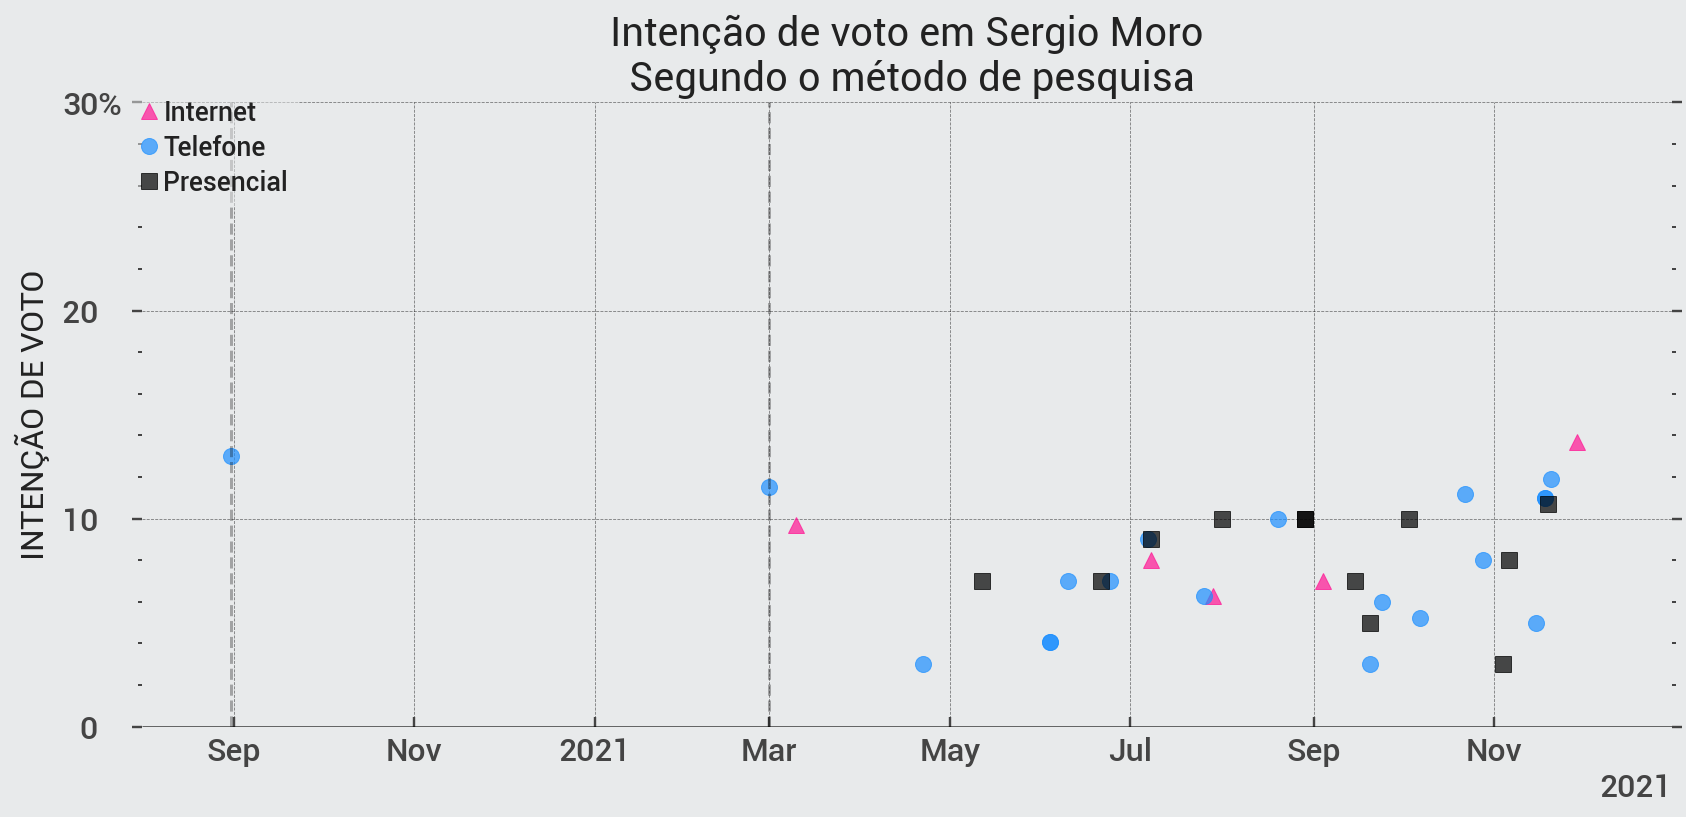

In [57]:
import matplotlib.dates as mdates
# dados
precencial = data_sub[(data_sub["modo"] == "Presencial")]
dates_precencial = precencial.date

telefone = data_sub[(data_sub["modo"] == "CATI") | (data_sub["modo"] == "IRV")]
dates_telefone = telefone.date

internet = data_sub[(data_sub["modo"] == "Internet") | (data_sub["modo"] == "Online")]
dates_internet = internet.date


# Plot
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(dates_internet, internet["Sergio Moro"].values, "^", alpha=0.7, label="Internet", color="deeppink")
    ax.plot(dates_telefone, telefone["Sergio Moro"].values, "o", alpha=0.7, label="Telefone", color="dodgerblue")
    ax.plot(dates_precencial, precencial["Sergio Moro"].values, "s", alpha=0.7, label="Presencial", color="black")
    ax.set_yticks(ticks = [.0, .10, .20, .30])
    ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30%'])
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_ylabel(f"INTENÇÃO DE VOTO")
    ax.set_title(f"Intenção de voto em Sergio Moro\n Segundo o método de pesquisa", fontsize=20)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left', frameon=True)
    ax.set_xlim([datetime.date(2020, 8, 1), datetime.date(2021, 12, 31)])
    
    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.3, linestyle="--")
        fig.tight_layout();

    plt.savefig('../figures/intencao_voto_Moro_vs_modo.png', dpi=300)

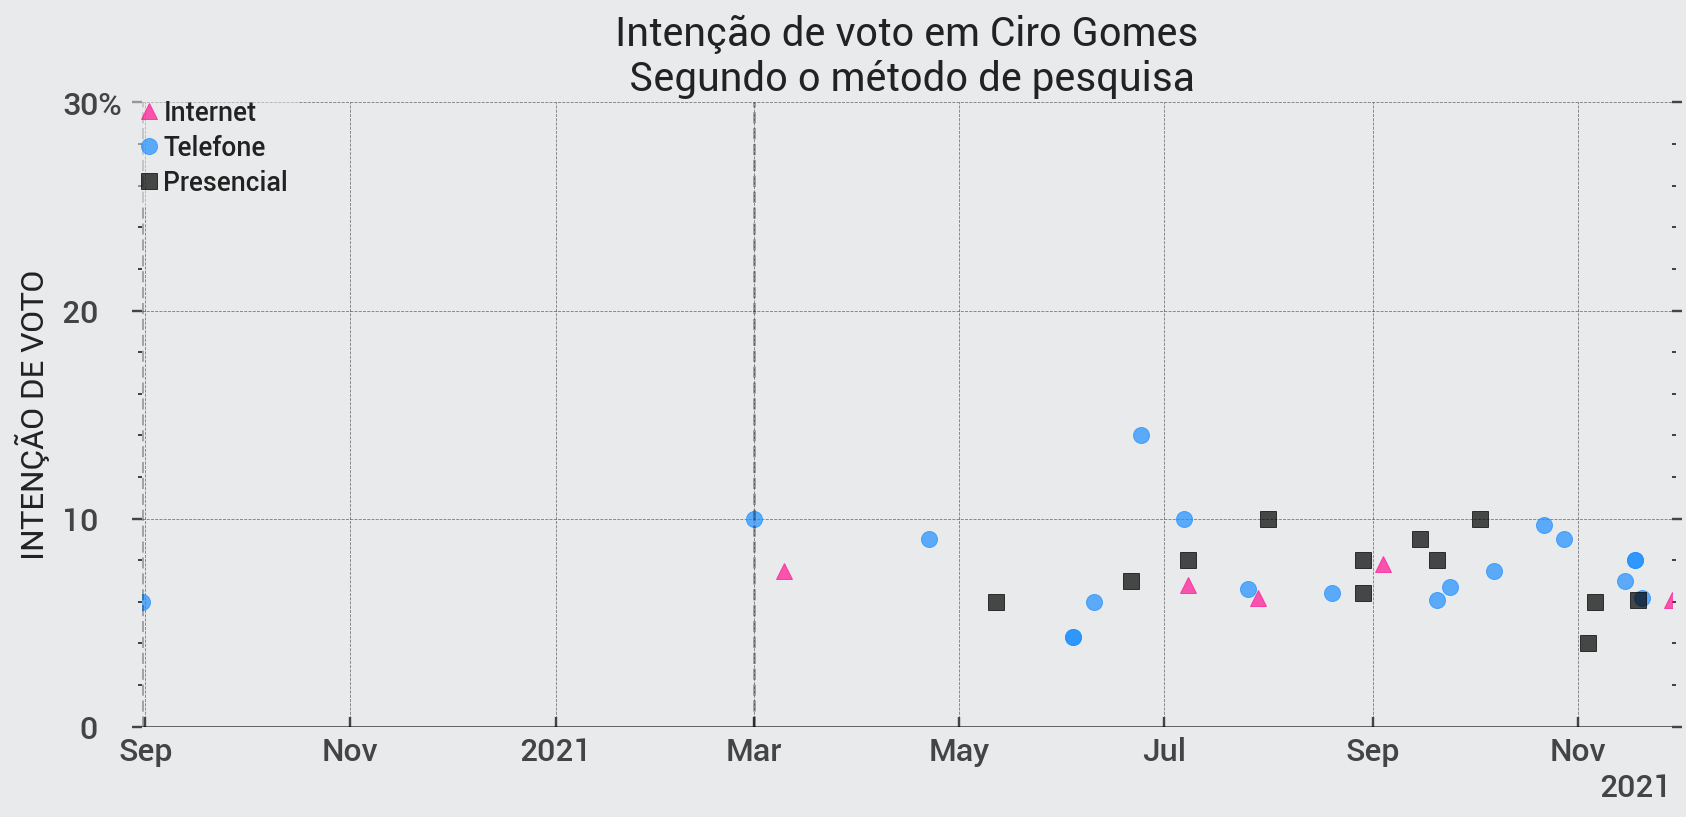

In [58]:
import matplotlib.dates as mdates
# dados
precencial = data_sub[(data_sub["modo"] == "Presencial")]
dates_precencial = precencial.date

telefone = data_sub[(data_sub["modo"] == "CATI") | (data_sub["modo"] == "IRV")]
dates_telefone = telefone.date

internet = data_sub[(data_sub["modo"] == "Internet") | (data_sub["modo"] == "Online")]
dates_internet = internet.date


# Plot
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(dates_internet, internet["Ciro Gomes"].values, "^", alpha=0.7, label="Internet", color="deeppink")
    ax.plot(dates_telefone, telefone["Ciro Gomes"].values, "o", alpha=0.7, label="Telefone", color="dodgerblue")
    ax.plot(dates_precencial, precencial["Ciro Gomes"].values, "s", alpha=0.7, label="Presencial", color="black")
    ax.set_yticks(ticks = [.0, .10, .20, .30])
    ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30%'])
    ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
    ax.set_ylabel(f"INTENÇÃO DE VOTO")
    ax.set_title(f"Intenção de voto em Ciro Gomes\n Segundo o método de pesquisa", fontsize=20)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left', frameon=True)
    
    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.3, linestyle="--")
        fig.tight_layout();
        
    plt.savefig('../figures/intencao_voto_Ciro_vs_modo.png', dpi=300)

### Jair Bolsonaro

### Lula



## Sérgio Moro

# Modelos

## Bolsonaro 

In [209]:
# df = file_long_sub.query('candidato == "Bolsonaro" or candidato == "Lula" or candidato == "Ciro"').reset_index()
df = data.query("candidato == 'Jair Bolsonaro'").reset_index()

In [211]:

df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))

df

empresa       date       candidato  turno    voto   erro  amostra  \
0             Atlas 2021-03-14  Jair Bolsonaro    1.0  0.3270  0.030   3721.0   
1             Atlas 2021-03-21  Jair Bolsonaro    1.0  0.3270    NaN   3721.0   
2             Atlas 2021-03-28  Jair Bolsonaro    1.0  0.3270    NaN   3721.0   
3             Atlas 2021-04-04  Jair Bolsonaro    1.0  0.3270    NaN   3721.0   
4             Atlas 2021-04-11  Jair Bolsonaro    1.0  0.3270    NaN   3721.0   
..              ...        ...             ...    ...     ...    ...      ...   
292  Ranking Brasil 2021-09-05  Jair Bolsonaro    1.0  0.2733    NaN   3000.0   
293  Ranking Brasil 2021-09-12  Jair Bolsonaro    1.0  0.2733    NaN   3000.0   
294  Ranking Brasil 2021-09-19  Jair Bolsonaro    1.0  0.2733    NaN   3000.0   
295  Ranking Brasil 2021-09-26  Jair Bolsonaro    1.0  0.2710  0.020   4000.0   
296      Vox Populi 2021-11-07  Jair Bolsonaro    1.0  0.2100  0.022   2000.0   

      day  month  week    year  num_voto  
0    10.0    3.0  10.0  2021.0    1216.0  
1     NaN    NaN  10.0     NaN    1216.0  
2     NaN    NaN  10.0     NaN    1216.0  
3     NaN    NaN  10.0     NaN    1216.0  
4     NaN    NaN  10.0     NaN    1216.0  
..    ...    ...   ...     ...       ...  
292   NaN    NaN  22.0     NaN     819.0  
293   NaN    NaN  22.0     NaN     819.0  
294   NaN    NaN  22.0     NaN     819.0  
295  20.0    9.0  38.0  2021.0    1084.0  
296   4.0   11.0  44.0  2021.0     420.0  

[297 rows x 12 columns]

In [215]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id)+1)
week_id

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 57, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 44, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27

In [216]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}
COORDS

{'empresas': Index(['Atlas', 'Brasmarket', 'Datafolha', 'Futura', 'IDEIA', 'Ipec', 'Ipespe',
        'Orbis', 'Paraná', 'PoderData', 'Ponteio', 'Quaest', 'Ranking Brasil',
        'Vox Populi'],
       dtype='object'),
 'temporal': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 'observacao': MultiIndex([(         'Atlas', '2021-03-14'),
             (         'Atlas', '2021-03-21'),
             (         'Atlas', '2021-03-28'),
             (         'Atlas', '2021-04-04'),
             (         'Atlas', '2021-04-11'),
             (         'Atlas', '2021-04-18'),
             (         'Atlas', '2021-04-25'),
             (         'Atlas', '2021-05-02'),
             (         'Atlas', '2021-05-09'),
             (         'Atlas', '2

In [217]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    he = pm.Normal("he", mu=0, sd=0.05, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    #parameters
    thetas = pm.Deterministic(
        "thetas",
        pm.math.invlogit(mu[week_id] + he[empresa_id]),
        dims = "observacao",
    )

    poll = pm.Binomial(
        "likelihood",
        p = thetas, 
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

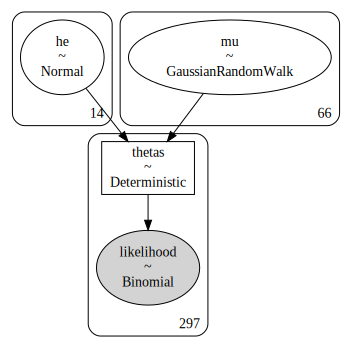

In [218]:
# Save imagem
pc = pm.model_to_graphviz(intencao_coletiva)
pc.render("intencao_media", format="png")

pm.model_to_graphviz(intencao_coletiva)

In [219]:
RANDOM_SEED = 12345

# Explore and Sample the Parameter Space
with intencao_coletiva:
    # step = pm.Metropolis()
    bolsonaro_trace = pm.sample(draws=2000, 
                                tune=2000, 
                                cores=4, 
                                chains=8, 
                                target_accept=0.980,
                                random_seed=RANDOM_SEED,
                                return_inferencedata=True,
                                discard_tuned_samples=True) 
    # bolsonaro_prior_samples = pm.sample_prior_predictive(trace = bolsonaro_trace, samples=50, random_seed=RANDOM_SEED)
    # Sample from the posterior
    bolsonaro_ppc = pm.sample_posterior_predictive(trace = bolsonaro_trace, samples = 2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [mu, he]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 84 seconds.


0, dim: observacao, 297 =? 297


The number of effective samples is smaller than 10% for some parameters.


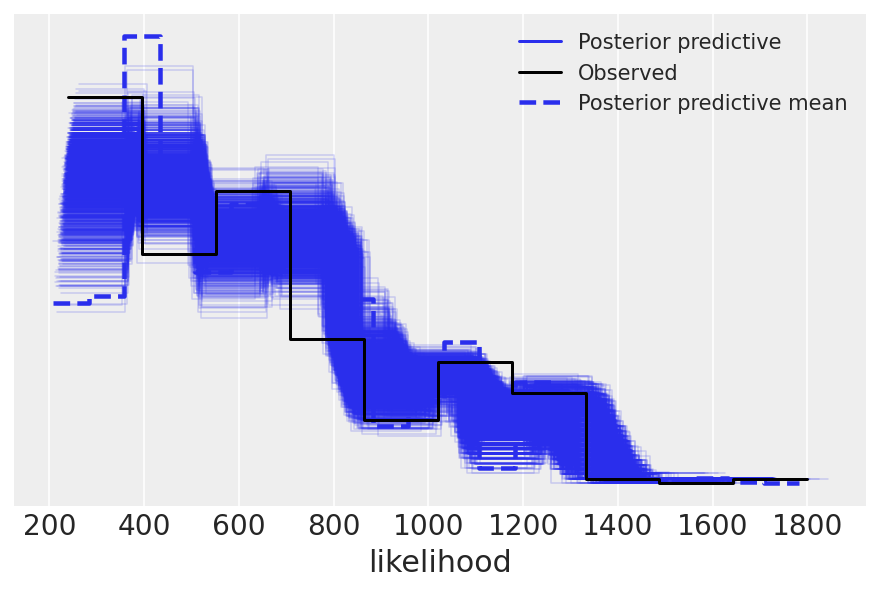

In [198]:
az.plot_ppc(az.from_pymc3(posterior_predictive=bolsonaro_ppc, model=intencao_coletiva));

0, dim: observacao, 297 =? 297
0, dim: observacao, 297 =? 297


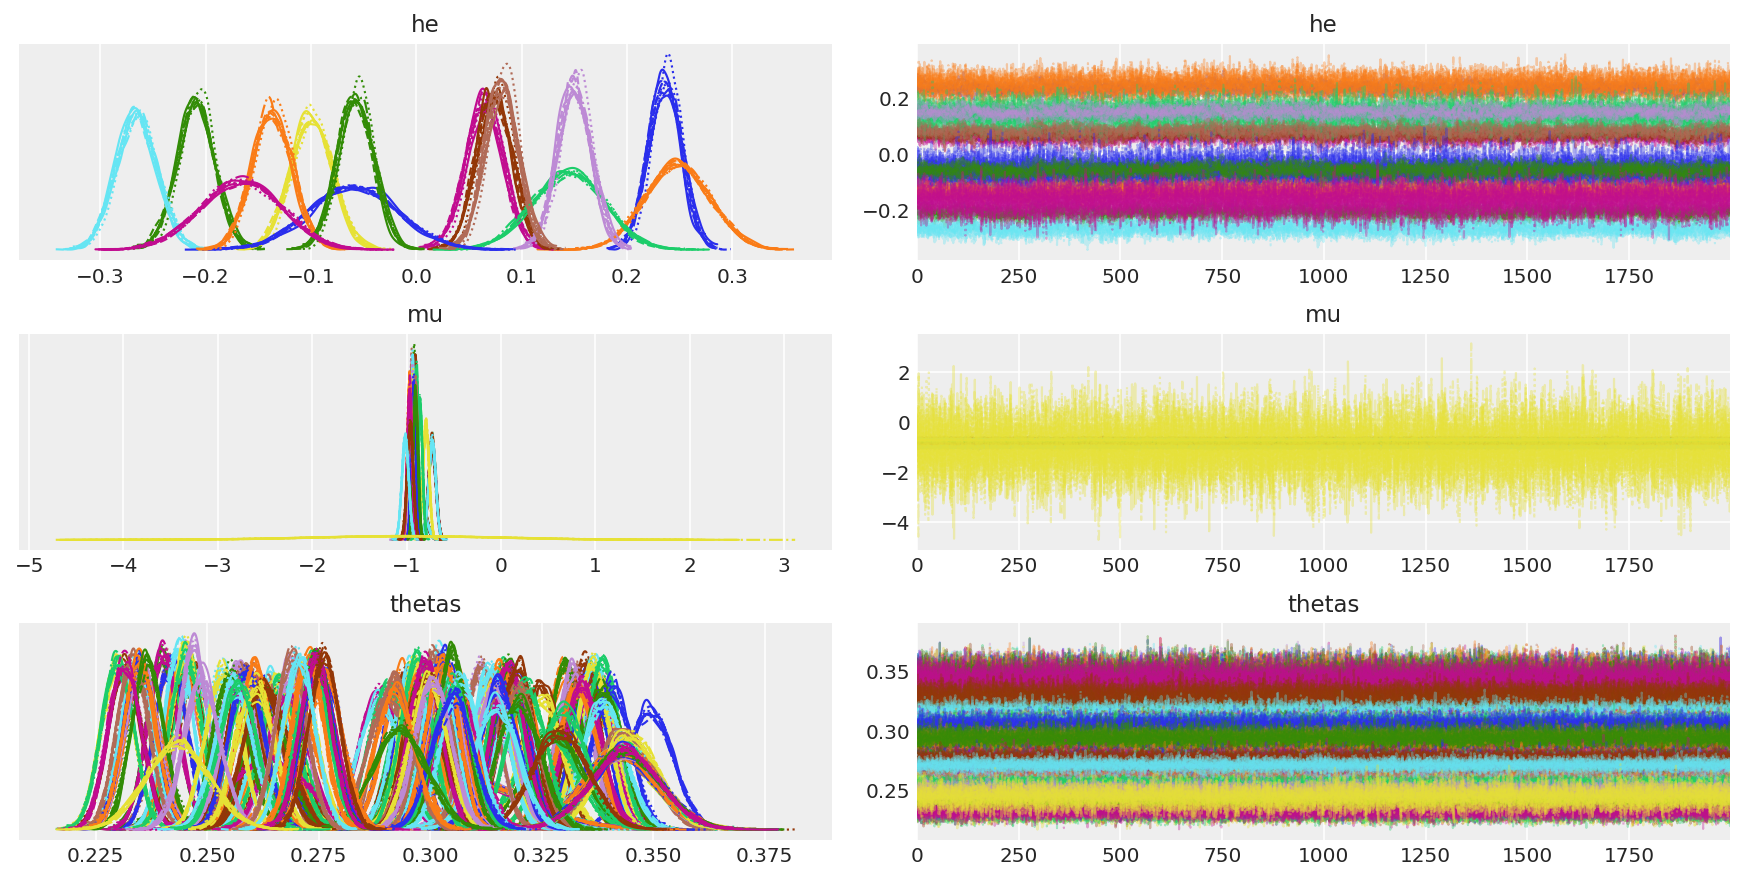

In [178]:
pm.traceplot(bolsonaro_trace)
plt.show()

In [179]:
pm.summary(bolsonaro_trace, round_to=3, hdi_prob=0.94)

0, dim: observacao, 297 =? 297


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
he[0]        0.236  0.015   0.207    0.265      0.001      0.0    659.945   
he[1]        0.248  0.030   0.193    0.307      0.000      0.0   4494.668   
he[2]       -0.209  0.018  -0.242   -0.174      0.001      0.0    956.209   
he[3]        0.065  0.018   0.030    0.098      0.001      0.0    981.356   
he[4]        0.074  0.017   0.044    0.106      0.001      0.0    754.355   
...            ...    ...     ...      ...        ...      ...        ...   
thetas[292]  0.274  0.004   0.268    0.281      0.000      0.0  32299.111   
thetas[293]  0.274  0.004   0.268    0.281      0.000      0.0  32466.083   
thetas[294]  0.276  0.003   0.270    0.283      0.000      0.0  34416.650   
thetas[295]  0.271  0.004   0.264    0.277      0.000      0.0  30888.681   
thetas[296]  0.243  0.007   0.230    0.257      0.000      0.0  12065.850   

              ess_tail  r_hat  
he[0]         1598.331  1.008  
he[1]        10469.134  1.001  
he[2]         2512.518  1.006  
he[3]         2730.252  1.006  
he[4]         2006.962  1.007  
...                ...    ...  
thetas[292]  12744.224  1.001  
thetas[293]  12182.440  1.001  
thetas[294]  12477.395  1.001  
thetas[295]  12578.885  1.000  
thetas[296]  11699.947  1.000  

[378 rows x 9 columns]

In [205]:
from scipy.special import expit as logistic

map_estimate = pm.find_MAP(model=intencao_coletiva)
logistic(map_estimate['mu']).round(3)

array([0.294, 0.294, 0.294, 0.294, 0.294, 0.294, 0.294, 0.294, 0.294,
       0.294, 0.294, 0.294, 0.294, 0.294, 0.294, 0.294, 0.326, 0.326,
       0.326, 0.326, 0.326, 0.326, 0.326, 0.326, 0.326, 0.326, 0.312,
       0.298, 0.283, 0.283, 0.283, 0.283, 0.286, 0.287, 0.287, 0.287,
       0.286, 0.286, 0.286, 0.286, 0.288, 0.288, 0.287, 0.287, 0.285,
       0.282, 0.282, 0.285, 0.28 , 0.28 , 0.286, 0.284, 0.286, 0.286,
       0.288, 0.282, 0.283, 0.29 , 0.283, 0.288, 0.284, 0.275, 0.288,
       0.276, 0.277, 0.266, 0.265])

In [196]:
bolsonaro_trace

<MultiTrace: 8 chains, 2000 iterations, 3 variables>

In [195]:
(bolsonaro_trace.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]

empresa       date       candidato  turno    voto   erro  amostra  \
0             Atlas 2021-03-14  Jair Bolsonaro    1.0  0.3270  0.030   3721.0   
1             Atlas 2021-03-21  Jair Bolsonaro    1.0  0.3270    NaN   3721.0   
2             Atlas 2021-03-28  Jair Bolsonaro    1.0  0.3270    NaN   3721.0   
3             Atlas 2021-04-04  Jair Bolsonaro    1.0  0.3270    NaN   3721.0   
4             Atlas 2021-04-11  Jair Bolsonaro    1.0  0.3270    NaN   3721.0   
..              ...        ...             ...    ...     ...    ...      ...   
292  Ranking Brasil 2021-09-05  Jair Bolsonaro    1.0  0.2733    NaN   3000.0   
293  Ranking Brasil 2021-09-12  Jair Bolsonaro    1.0  0.2733    NaN   3000.0   
294  Ranking Brasil 2021-09-19  Jair Bolsonaro    1.0  0.2733    NaN   3000.0   
295  Ranking Brasil 2021-09-26  Jair Bolsonaro    1.0  0.2710  0.020   4000.0   
296      Vox Populi 2021-11-07  Jair Bolsonaro    1.0  0.2100  0.022   2000.0   

      day  month  week    year  num_voto  
0    10.0    3.0  10.0  2021.0    1216.0  
1     NaN    NaN  10.0     NaN    1216.0  
2     NaN    NaN  10.0     NaN    1216.0  
3     NaN    NaN  10.0     NaN    1216.0  
4     NaN    NaN  10.0     NaN    1216.0  
..    ...    ...   ...     ...       ...  
292   NaN    NaN  22.0     NaN     819.0  
293   NaN    NaN  22.0     NaN     819.0  
294   NaN    NaN  22.0     NaN     819.0  
295  20.0    9.0  38.0  2021.0    1084.0  
296   4.0   11.0  44.0  2021.0     420.0  

[297 rows x 12 columns]

In [206]:
df -= df[["date", "turno", "candidato", "voto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks

date  turno    voto
date                                
2020-09-06 2020-09-06    1.0  0.3100
2020-09-13 2020-09-13    1.0  0.3100
2020-09-20 2020-09-20    1.0  0.3100
2020-09-27 2020-09-27    1.0  0.3100
2020-10-04 2020-10-04    1.0  0.3100
...               ...    ...     ...
2021-11-07 2021-11-07    1.0  0.2850
2021-11-14 2021-11-14    1.0  0.3150
2021-11-21 2021-11-21    1.0  0.2885
2021-11-28 2021-11-28    1.0  0.3075
2021-12-05 2021-12-05    1.0  0.3150

[66 rows x 3 columns]

In [207]:
df_weeks['previsto'] = logistic(map_estimate['mu']).round(3)

df_weeks

ValueError: Length of values (67) does not match length of index (66)

### Inferência a partir da Distribuição Posterior

Vamos olhar as distribuições preditivas da posterior, só vamos considerar as estimativas quando o modelo convergiu corretamente. 

In [37]:
# here I acquired sample_posterior_predictive using the:
with intencao_coletiva:
    trace_bolsonaro.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_bolsonaro),
        )
    )
    
    
    
df['previsto'] = (trace_bolsonaro.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]

df = df[["date", "turno", "candidato", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Bolsonaro"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_bolsonaro.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_bolsonaro.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_bolsonaro.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_bolsonaro.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/bolsonaro_previsto.csv', sep=";", encoding='utf-8', mode = 'w', index=False)
# trace_bolsonaro.posterior_predictive.quantiles((.01, .05, .5, .95, .99), dim=("chain", "draw"))

In [1]:
pm.summary(trace_bolsonaro, hdi_prob=0.94)

NameError: name 'pm' is not defined

## Lula 

In [38]:
df = data.query("candidato == 'Lula'").reset_index()

In [39]:

df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date candidato  turno    voto   erro  amostra   day  \
0             Atlas 2021-03-14      Lula    1.0  0.2440  0.030   3721.0  10.0   
1             Atlas 2021-03-21      Lula    1.0  0.2440    NaN   3721.0   NaN   
2             Atlas 2021-03-28      Lula    1.0  0.2440    NaN   3721.0   NaN   
3             Atlas 2021-04-04      Lula    1.0  0.2440    NaN   3721.0   NaN   
4             Atlas 2021-04-11      Lula    1.0  0.2440    NaN   3721.0   NaN   
..              ...        ...       ...    ...     ...    ...      ...   ...   
209  Ranking Brasil 2021-09-05      Lula    1.0  0.3207    NaN   3000.0   NaN   
210  Ranking Brasil 2021-09-12      Lula    1.0  0.3207    NaN   3000.0   NaN   
211  Ranking Brasil 2021-09-19      Lula    1.0  0.3207    NaN   3000.0   NaN   
212  Ranking Brasil 2021-09-26      Lula    1.0  0.3800  0.020   4000.0  20.0   
213      Vox Populi 2021-11-07      Lula    1.0  0.4400  0.022   2000.0   4.0   

     month  week    year  num_voto  
0      3.0  10.0  2021.0     907.0  
1      NaN  10.0     NaN     907.0  
2      NaN  10.0     NaN     907.0  
3      NaN  10.0     NaN     907.0  
4      NaN  10.0     NaN     907.0  
..     ...   ...     ...       ...  
209    NaN  22.0     NaN     962.0  
210    NaN  22.0     NaN     962.0  
211    NaN  22.0     NaN     962.0  
212    9.0  38.0  2021.0    1520.0  
213   11.0  44.0  2021.0     880.0  

[214 rows x 12 columns]

In [40]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 57, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 44, 63, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 63, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 61], dtype=int8)

In [41]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [42]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [43]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_lula = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 110 seconds.


0, dim: observacao, 214 =? 214


The number of effective samples is smaller than 10% for some parameters.


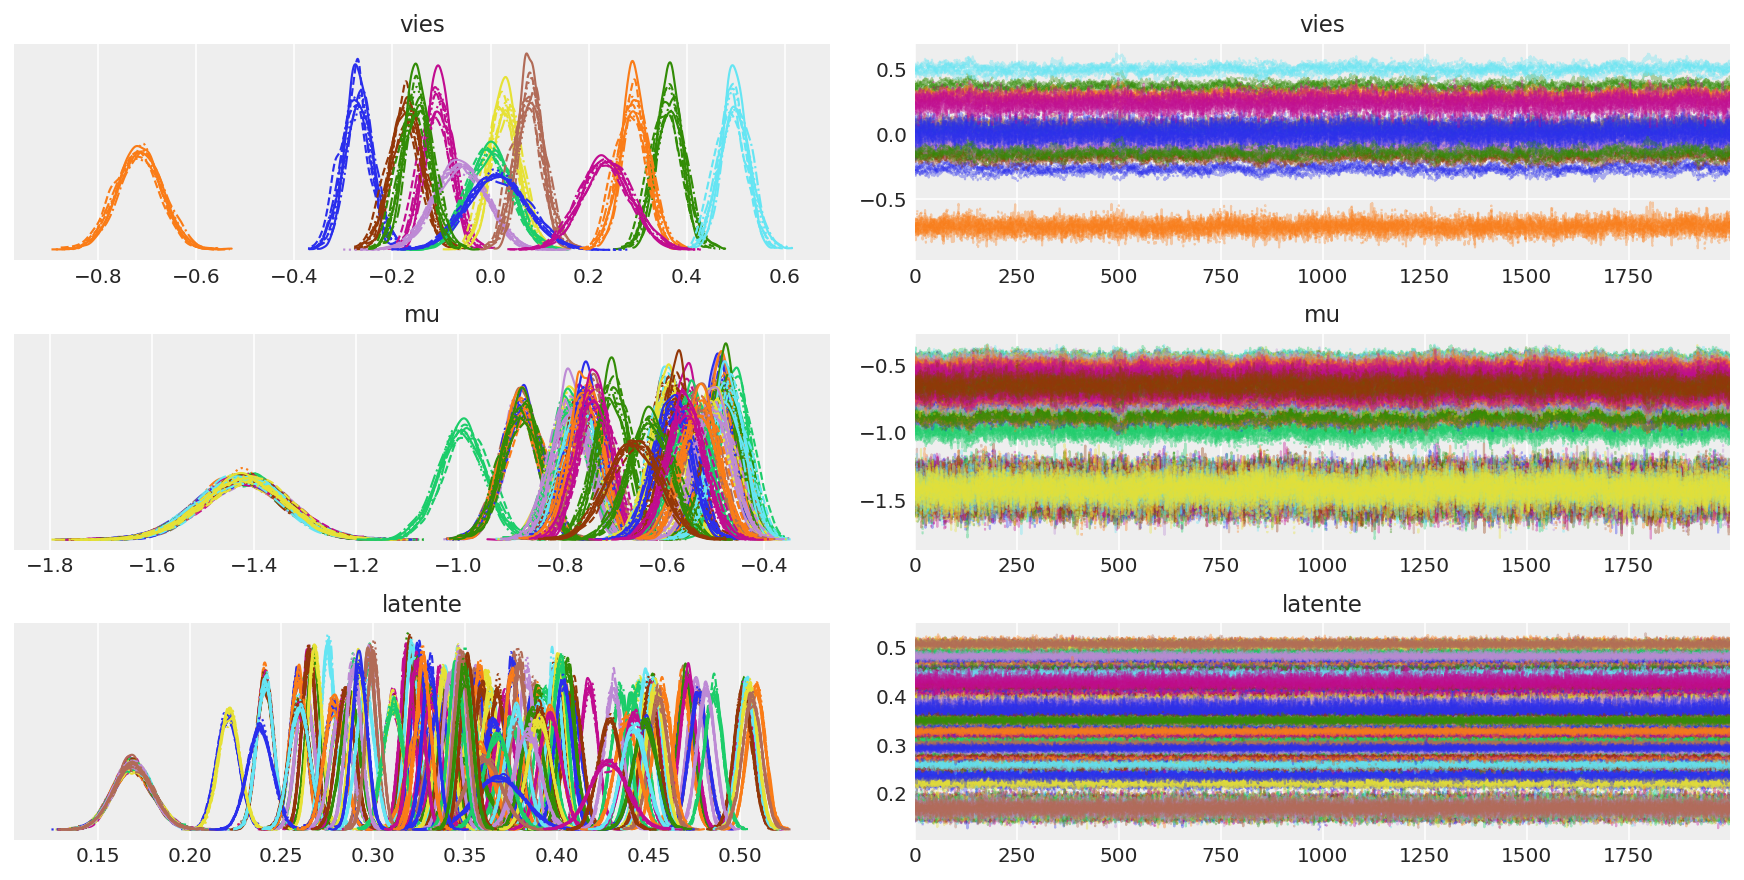

In [44]:
az.plot_trace(trace_lula, var_names=["~intencao"], compact=True);

In [45]:
media_vies = trace_lula.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas            
Atlas          -0.27
Brasmarket     -0.72
Datafolha       0.36
Futura         -0.11
IDEIA          -0.17
Ipec            0.50
Ipespe          0.03
Orbis          -0.00
Paraná         -0.06
PoderData       0.08
Ponteio         0.01
Quaest          0.29
Ranking Brasil -0.15
Vox Populi      0.24

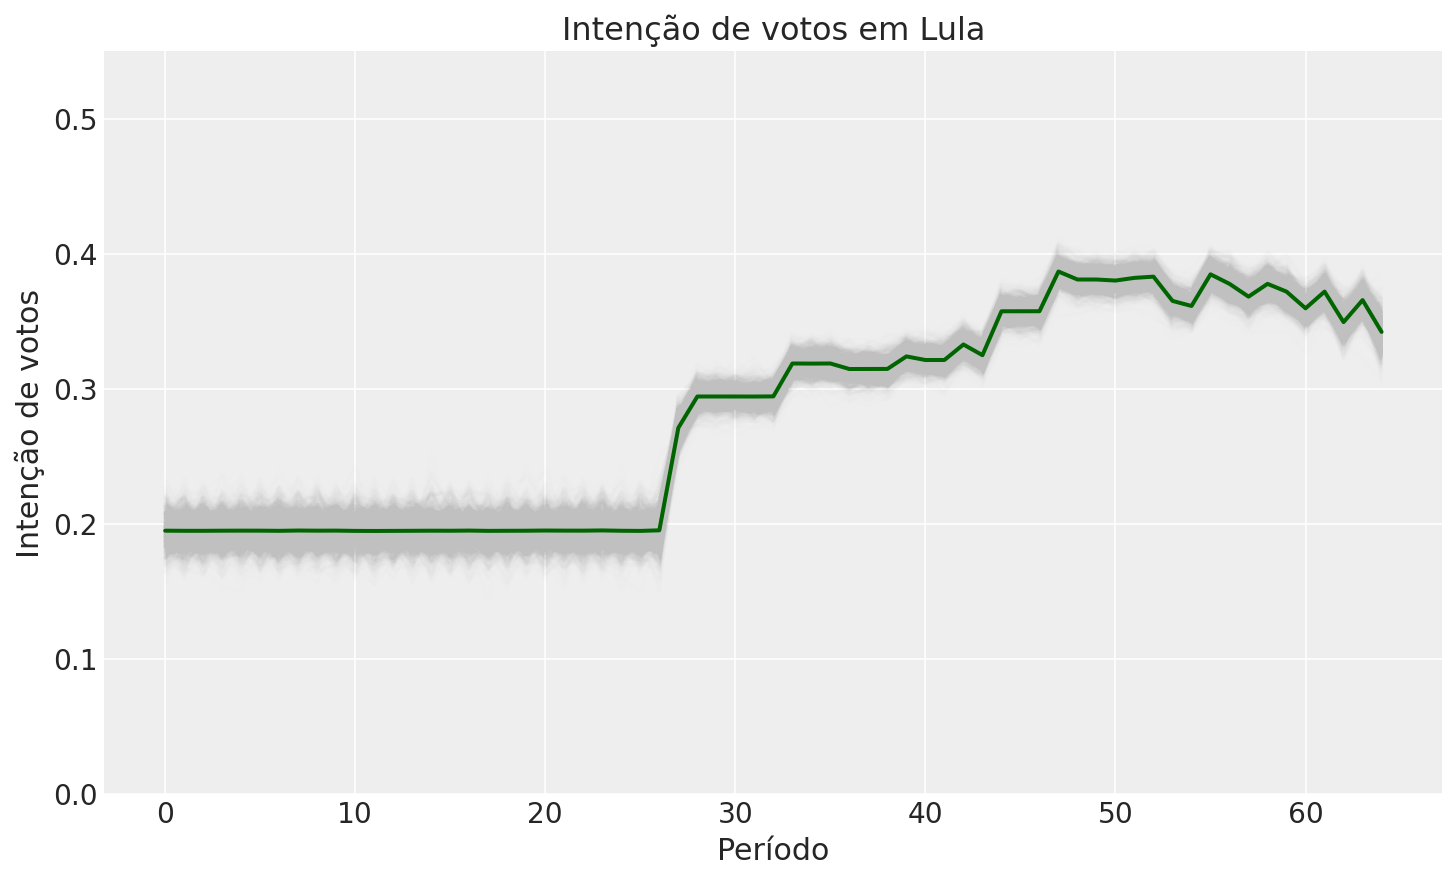

In [46]:
post_lula = logistic(trace_lula.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots(figsize=(10, 6))
for i in np.random.choice(post_lula.coords["sample"].size, size=1000):
    ax.plot(
        trace_lula.posterior.coords["temporal"],
        post_lula.isel(sample=i),
        alpha=0.01,
        color="silver",
    )
post_lula.mean("sample").plot(ax=ax, color="darkgreen", lw=2)
ax.set_title("Intenção de votos em Lula")
ax.set_ylabel("Intenção de votos")
ax.set_xlabel("Período")
ax.set_ylim(0, .55);

In [47]:
# here I acquired sample_posterior_predictive using the:
with intencao_coletiva:
    trace_lula.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_lula),
        )
    )
    

    
df['previsto'] = (trace_lula.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]


df = df[["date", "turno", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Lula"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_lula.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_lula.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_lula.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_lula.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/lula_previsto.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Indecisos

In [48]:
df = data.query("candidato == 'Indecisos'").reset_index()

In [49]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))

df

empresa       date  candidato  turno   voto   erro  amostra   day  \
0    Brasmarket 2021-10-10  Indecisos    1.0  0.153  0.014   4600.0   7.0   
1     Datafolha 2021-05-16  Indecisos    1.0  0.040  0.020   2071.0  12.0   
2     Datafolha 2021-05-23  Indecisos    1.0  0.040    NaN   2071.0   NaN   
3     Datafolha 2021-05-30  Indecisos    1.0  0.040    NaN   2071.0   NaN   
4     Datafolha 2021-06-06  Indecisos    1.0  0.040    NaN   2071.0   NaN   
..          ...        ...        ...    ...    ...    ...      ...   ...   
195      Quaest 2021-10-17  Indecisos    1.0  0.090    NaN   2048.0   NaN   
196      Quaest 2021-10-24  Indecisos    1.0  0.090    NaN   2048.0   NaN   
197      Quaest 2021-10-31  Indecisos    1.0  0.090    NaN   2048.0   NaN   
198      Quaest 2021-11-07  Indecisos    1.0  0.040  0.022   2063.0   6.0   
199  Vox Populi 2021-11-07  Indecisos    1.0  0.120  0.022   2000.0   4.0   

     month  week    year  num_voto  
0     10.0  40.0  2021.0     703.0  
1      5.0  19.0  2021.0      82.0  
2      NaN  19.0     NaN      82.0  
3      NaN  19.0     NaN      82.0  
4      NaN  19.0     NaN      82.0  
..     ...   ...     ...       ...  
195    NaN  39.0     NaN     184.0  
196    NaN  39.0     NaN     184.0  
197    NaN  39.0     NaN     184.0  
198   11.0  44.0  2021.0      82.0  
199   11.0  44.0  2021.0     240.0  

[200 rows x 12 columns]

In [50]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([57, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 44, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 63, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 61], dtype=int8)

In [51]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [52]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [53]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_indeciso = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 108 seconds.


0, dim: observacao, 200 =? 200


The number of effective samples is smaller than 10% for some parameters.


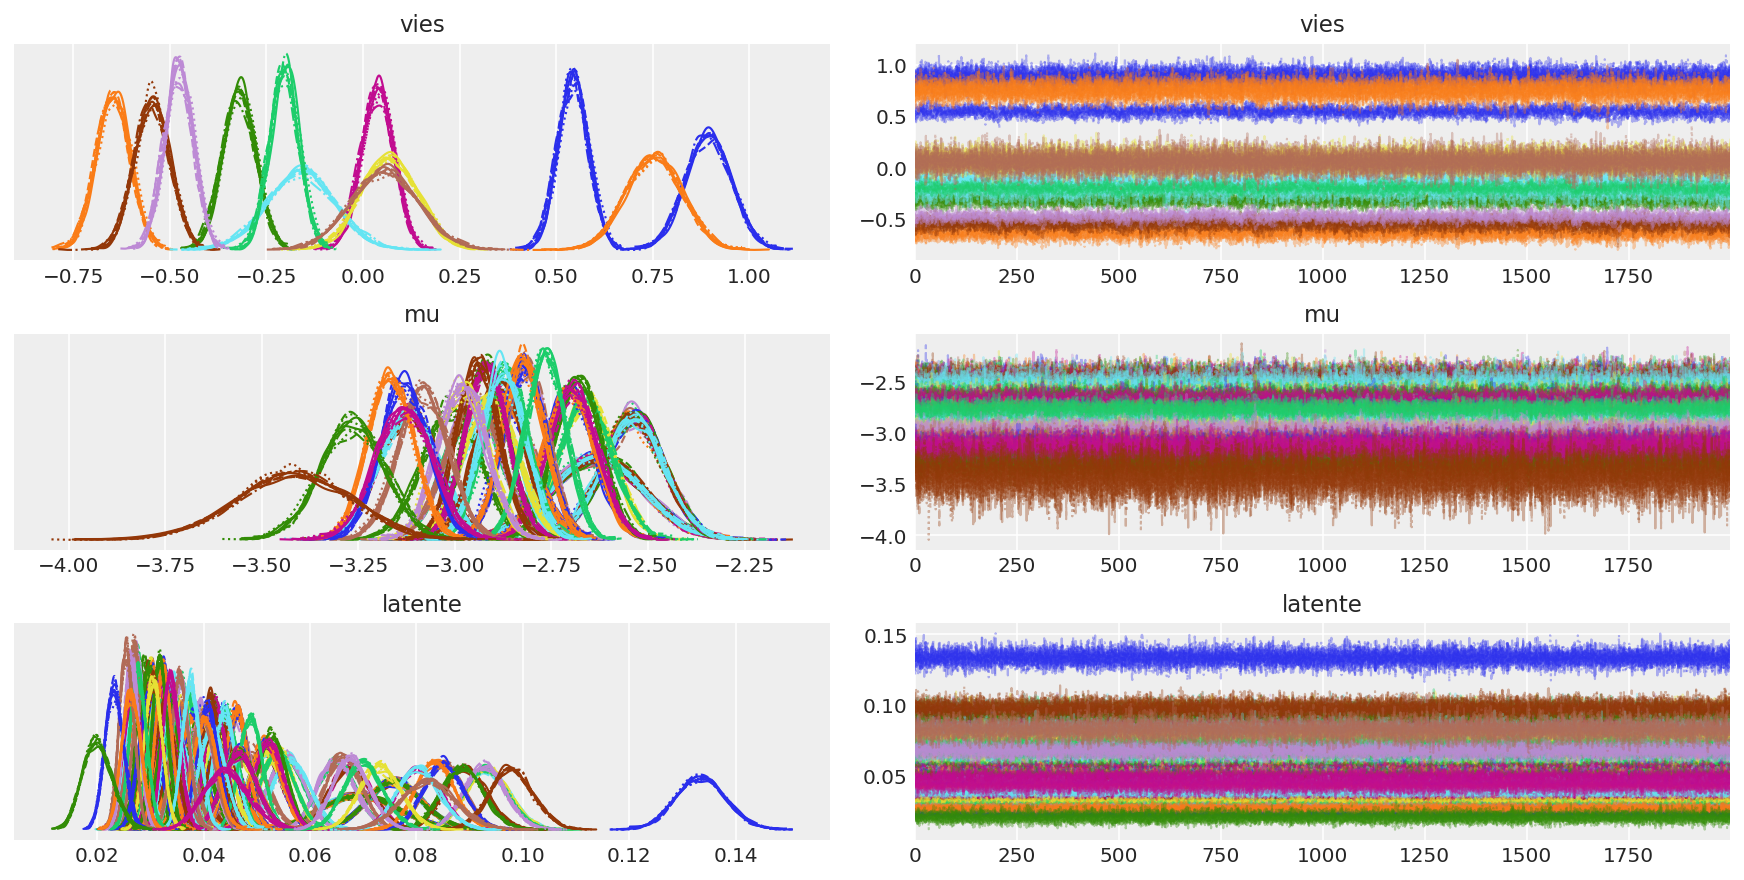

In [54]:
az.plot_trace(trace_indeciso, var_names=["~intencao"], compact=True);

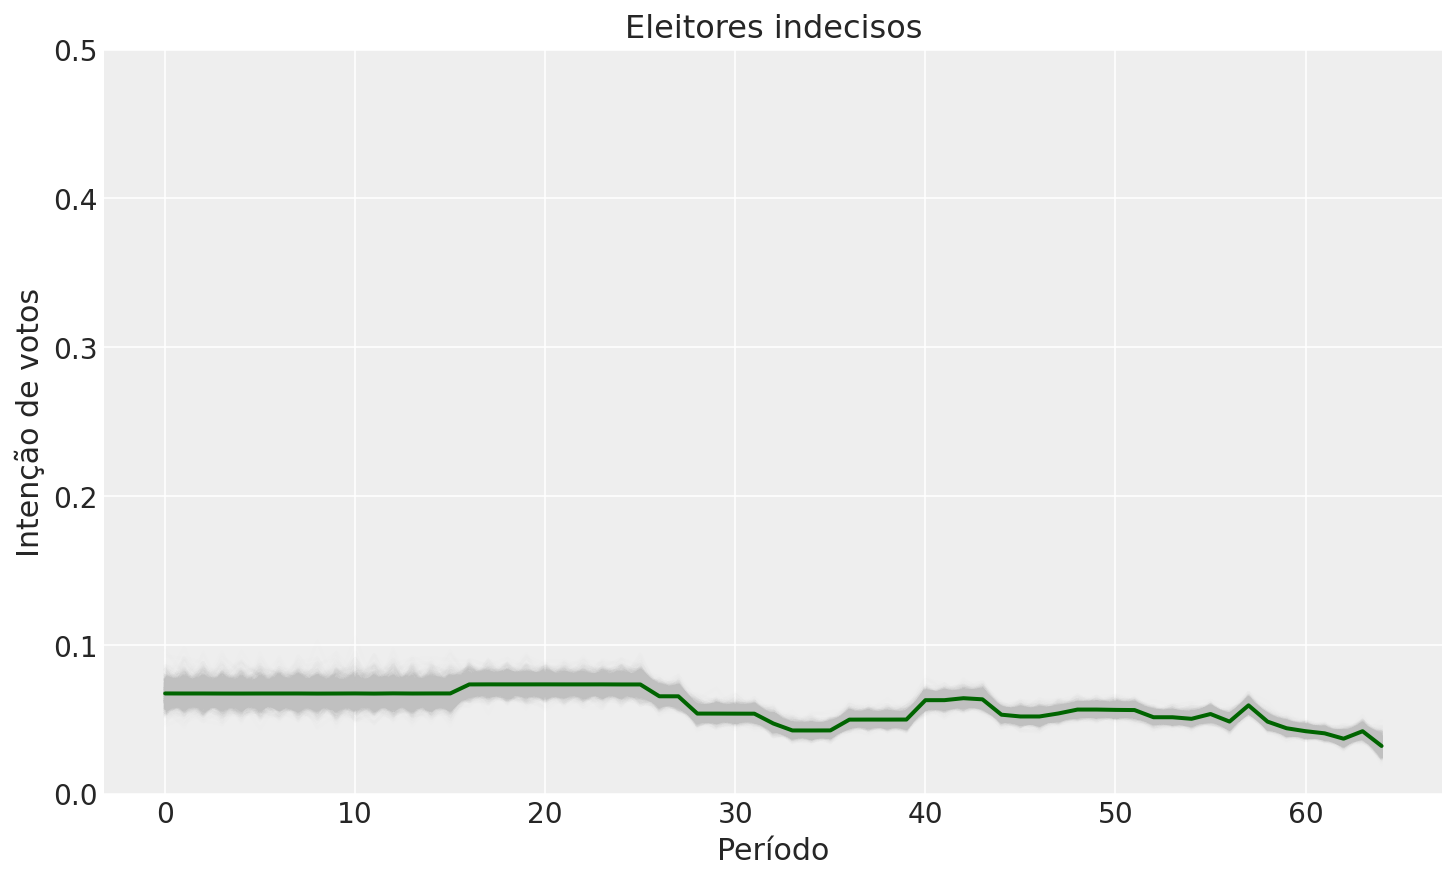

In [55]:
post_indeciso = logistic(trace_indeciso.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots(figsize=(10, 6))
for i in np.random.choice(post_indeciso.coords["sample"].size, size=1000):
    ax.plot(
        trace_indeciso.posterior.coords["temporal"],
        post_indeciso.isel(sample=i),
        alpha=0.01,
        color="silver",
    )
post_indeciso.mean("sample").plot(ax=ax, color="darkgreen", lw=2)
ax.set_title("Eleitores indecisos")
ax.set_ylabel("Intenção de votos")
ax.set_xlabel("Período")
ax.set_ylim(0, .50);

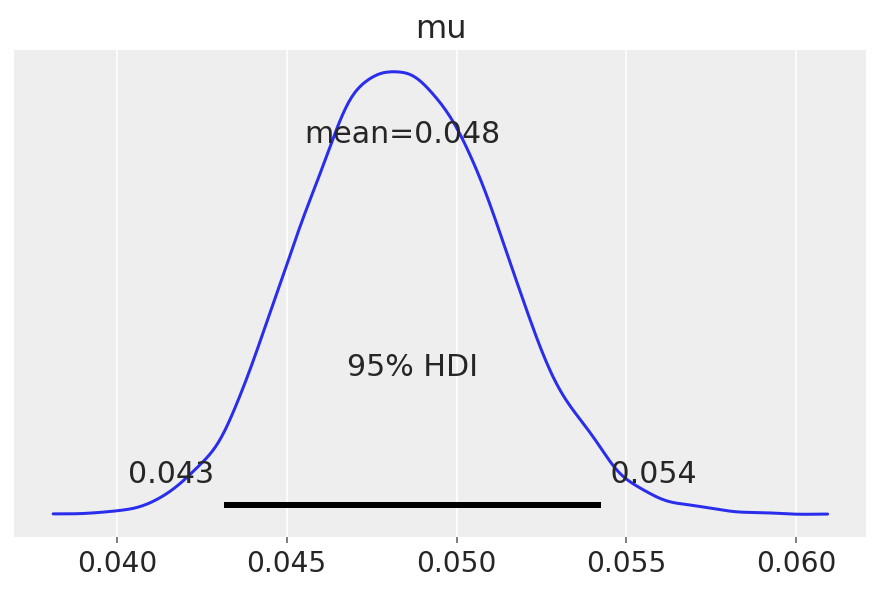

In [56]:
az.plot_posterior(logistic(trace_indeciso.posterior["mu"].sel(temporal=56)), hdi_prob=.95, round_to=2);

In [57]:
with intencao_coletiva:
    trace_indeciso.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_indeciso),
        )
    )
    

    
df['previsto'] = (trace_indeciso.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]


df = df[["date", "turno", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Indecisos"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_indeciso.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_indeciso.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_indeciso.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_indeciso.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/indeciso_previsto.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Branco/Nulo

In [58]:
df = data.query("candidato == 'Branco/Nulo'").reset_index()

In [59]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))

df

empresa       date    candidato  turno    voto   erro  amostra  \
0             Atlas 2021-03-14  Branco/Nulo    1.0  0.0610  0.030   3721.0   
1             Atlas 2021-03-21  Branco/Nulo    1.0  0.0610    NaN   3721.0   
2             Atlas 2021-03-28  Branco/Nulo    1.0  0.0610    NaN   3721.0   
3             Atlas 2021-04-04  Branco/Nulo    1.0  0.0610    NaN   3721.0   
4             Atlas 2021-04-11  Branco/Nulo    1.0  0.0610    NaN   3721.0   
..              ...        ...          ...    ...     ...    ...      ...   
259  Ranking Brasil 2021-09-05  Branco/Nulo    1.0  0.1833    NaN   3000.0   
260  Ranking Brasil 2021-09-12  Branco/Nulo    1.0  0.1833    NaN   3000.0   
261  Ranking Brasil 2021-09-19  Branco/Nulo    1.0  0.1833    NaN   3000.0   
262  Ranking Brasil 2021-09-26  Branco/Nulo    1.0  0.1520  0.020   4000.0   
263      Vox Populi 2021-11-07  Branco/Nulo    1.0  0.1000  0.022   2000.0   

      day  month  week    year  num_voto  
0    10.0    3.0  10.0  2021.0     226.0  
1     NaN    NaN  10.0     NaN     226.0  
2     NaN    NaN  10.0     NaN     226.0  
3     NaN    NaN  10.0     NaN     226.0  
4     NaN    NaN  10.0     NaN     226.0  
..    ...    ...   ...     ...       ...  
259   NaN    NaN  22.0     NaN     549.0  
260   NaN    NaN  22.0     NaN     549.0  
261   NaN    NaN  22.0     NaN     549.0  
262  20.0    9.0  38.0  2021.0     608.0  
263   4.0   11.0  44.0  2021.0     200.0  

[264 rows x 12 columns]

In [60]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 57, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 44, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60

In [61]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [62]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [63]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_nulo = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 120 seconds.


0, dim: observacao, 264 =? 264


The number of effective samples is smaller than 10% for some parameters.


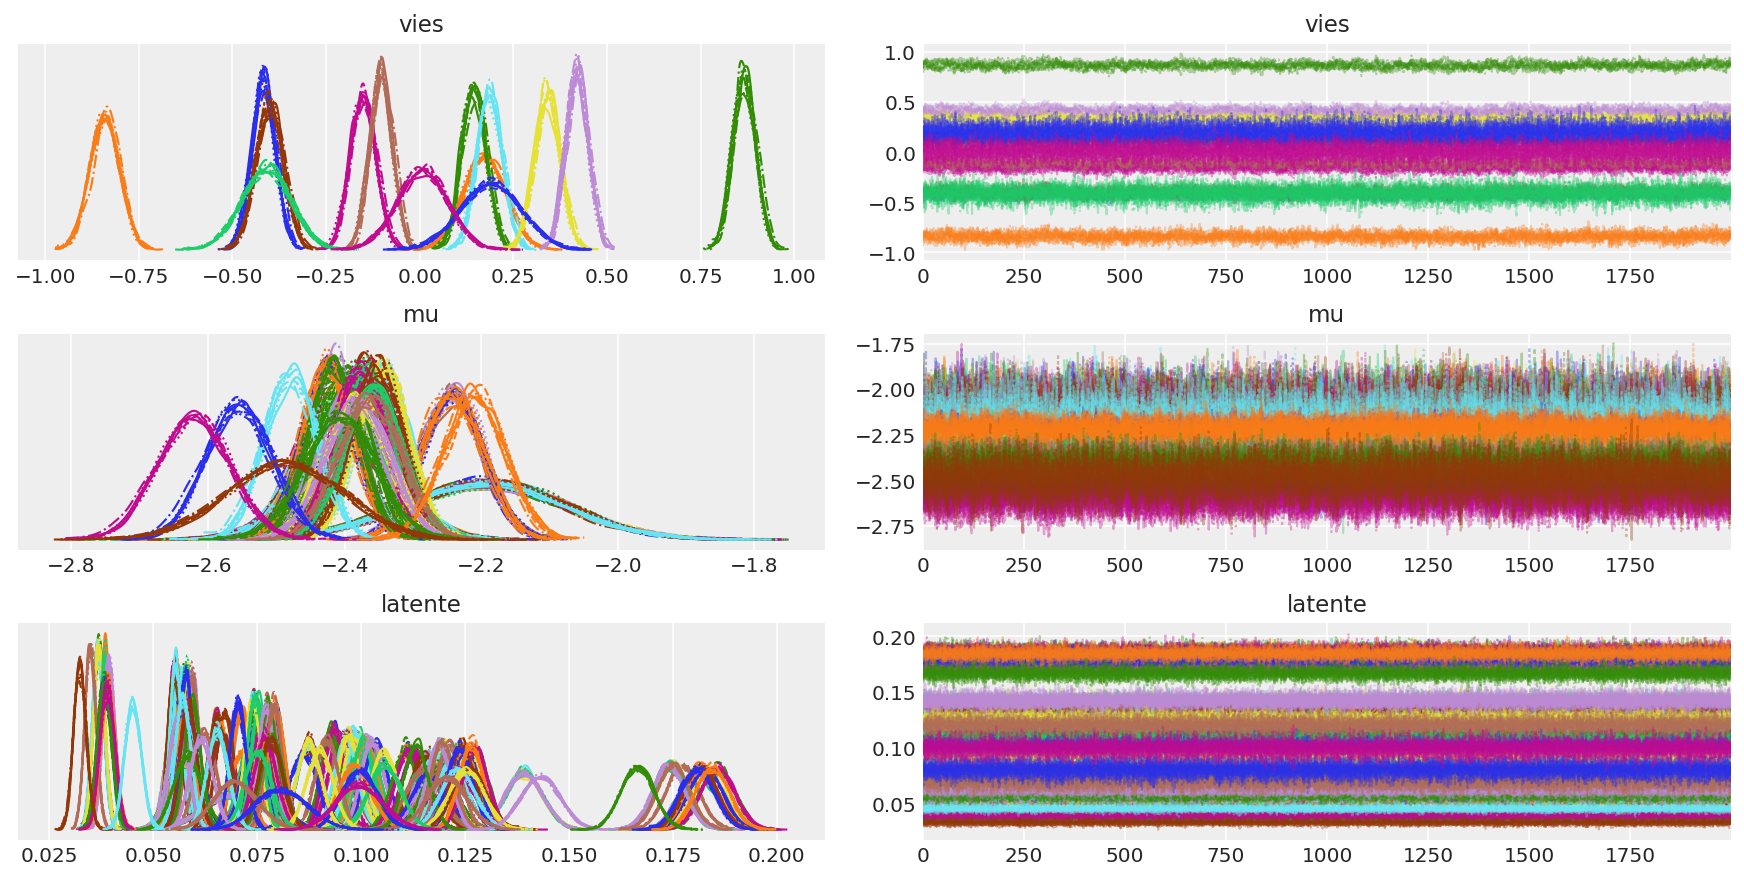

In [64]:
az.plot_trace(trace_nulo, var_names=["~intencao"], compact=True);

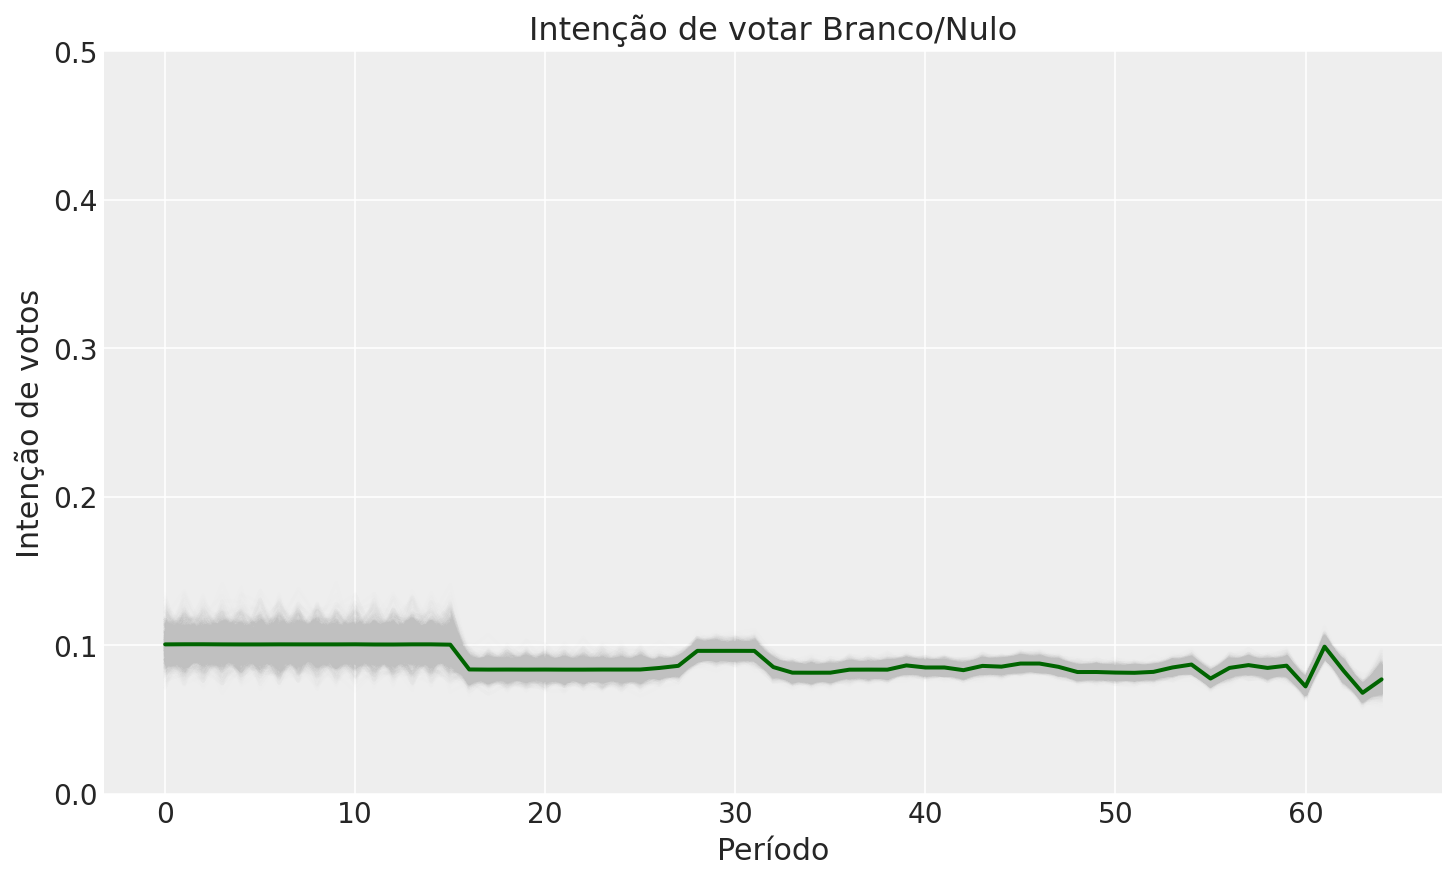

In [65]:
post_nulo = logistic(trace_nulo.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots(figsize=(10, 6))
for i in np.random.choice(post_nulo.coords["sample"].size, size=1000):
    ax.plot(
        trace_nulo.posterior.coords["temporal"],
        post_nulo.isel(sample=i),
        alpha=0.01,
        color="silver",
    )
post_nulo.mean("sample").plot(ax=ax, color="darkgreen", lw=2)
ax.set_title("Intenção de votar Branco/Nulo")
ax.set_ylabel("Intenção de votos")
ax.set_xlabel("Período")
ax.set_ylim(0, .50);

In [66]:
with intencao_coletiva:
    trace_nulo.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_nulo),
        )
    )

    
df['previsto'] = (trace_nulo.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]


df = df[["date", "turno", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Branco/Nulo"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_nulo.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_nulo.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_nulo.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_nulo.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/nulo_previsto.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Ciro 

In [67]:
df = data.query("candidato == 'Ciro'").reset_index()

In [68]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date candidato  turno    voto   erro  amostra   day  \
0             Atlas 2021-03-14      Ciro    1.0  0.0750  0.030   3721.0  10.0   
1             Atlas 2021-03-21      Ciro    1.0  0.0750    NaN   3721.0   NaN   
2             Atlas 2021-03-28      Ciro    1.0  0.0750    NaN   3721.0   NaN   
3             Atlas 2021-04-04      Ciro    1.0  0.0750    NaN   3721.0   NaN   
4             Atlas 2021-04-11      Ciro    1.0  0.0750    NaN   3721.0   NaN   
..              ...        ...       ...    ...     ...    ...      ...   ...   
246  Ranking Brasil 2021-09-05      Ciro    1.0  0.0433    NaN   3000.0   NaN   
247  Ranking Brasil 2021-09-12      Ciro    1.0  0.0433    NaN   3000.0   NaN   
248  Ranking Brasil 2021-09-19      Ciro    1.0  0.0433    NaN   3000.0   NaN   
249  Ranking Brasil 2021-09-26      Ciro    1.0  0.0610  0.020   4000.0  20.0   
250      Vox Populi 2021-11-07      Ciro    1.0  0.0400  0.022   2000.0   4.0   

     month  week    year  num_voto  
0      3.0  10.0  2021.0     279.0  
1      NaN  10.0     NaN     279.0  
2      NaN  10.0     NaN     279.0  
3      NaN  10.0     NaN     279.0  
4      NaN  10.0     NaN     279.0  
..     ...   ...     ...       ...  
246    NaN  22.0     NaN     129.0  
247    NaN  22.0     NaN     129.0  
248    NaN  22.0     NaN     129.0  
249    9.0  38.0  2021.0     244.0  
250   11.0  44.0  2021.0      80.0  

[251 rows x 12 columns]

In [69]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 57, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 44, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 63, 47, 48, 49,
       50, 51, 52, 53, 54

In [70]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [71]:

with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [72]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_ciro = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 95 seconds.


0, dim: observacao, 251 =? 251


The number of effective samples is smaller than 10% for some parameters.


In [73]:
# az.summary(trace_ciro, round_to=2, var_names=["~intencao"])

In [74]:
media_vies = trace_ciro.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas            
Atlas          -0.06
Brasmarket      0.12
Datafolha      -0.15
Futura          0.04
IDEIA           0.13
Ipec           -0.20
Ipespe          0.11
Orbis          -0.30
Paraná          0.32
PoderData       0.37
Ponteio         0.22
Quaest          0.25
Ranking Brasil -0.68
Vox Populi     -0.17

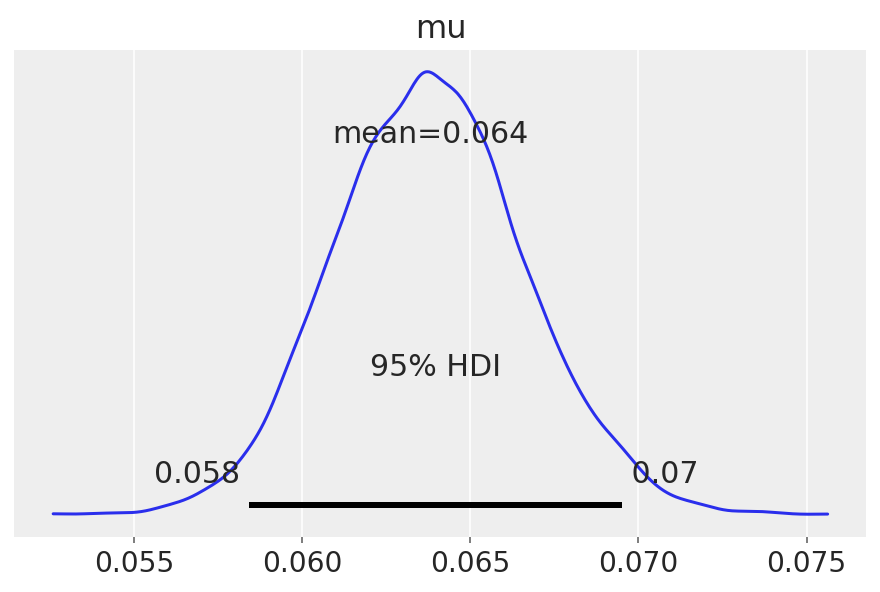

In [75]:
az.plot_posterior(logistic(trace_ciro.posterior["mu"].sel(temporal=56)), hdi_prob=.95, round_to=2);

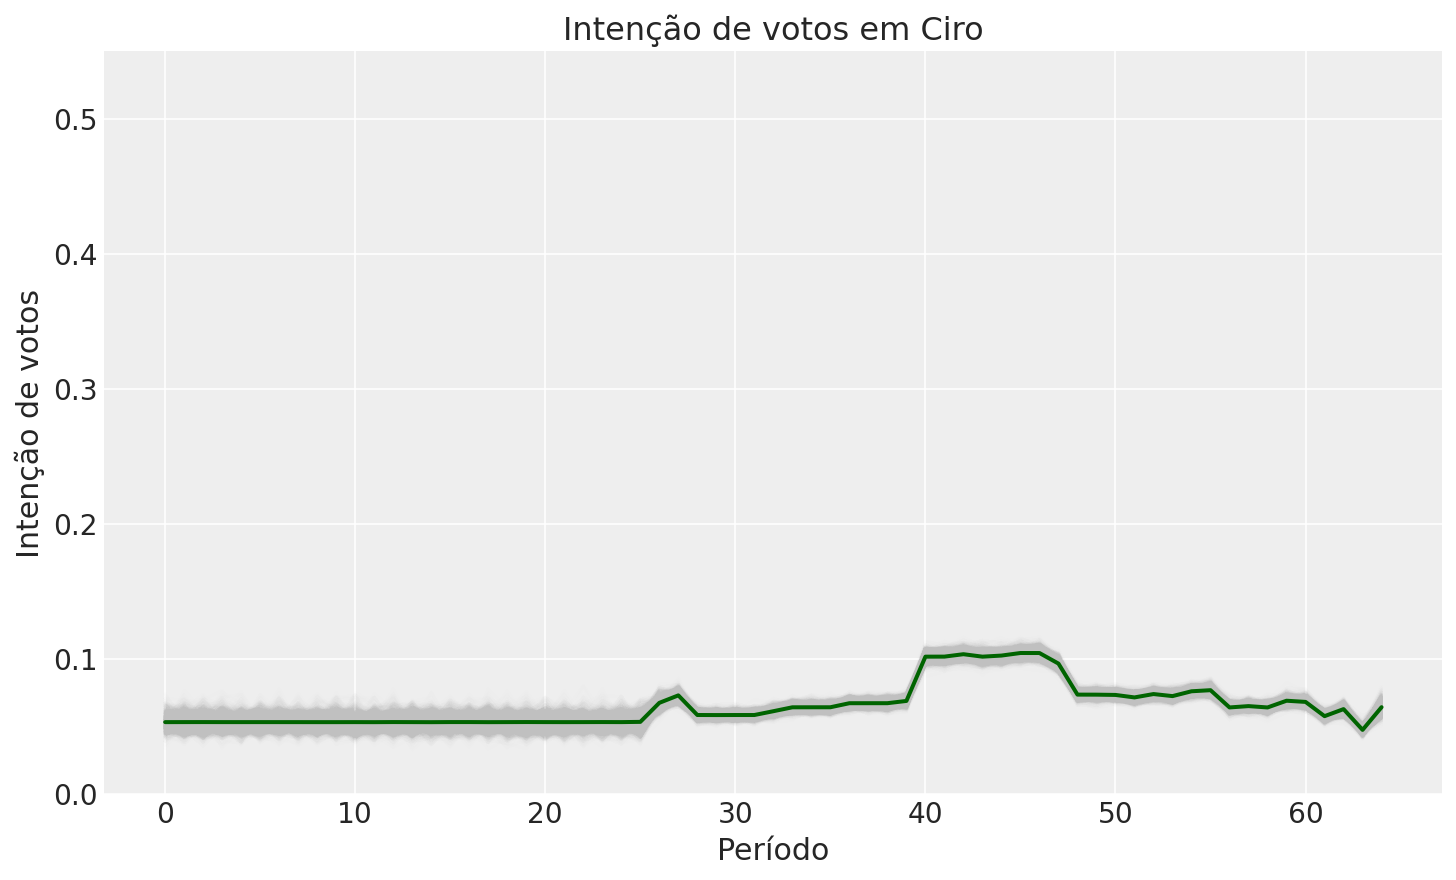

In [76]:
post_ciro = logistic(trace_ciro.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots(figsize=(10, 6))
for i in np.random.choice(post_ciro.coords["sample"].size, size=1000):
    ax.plot(
        trace_ciro.posterior.coords["temporal"],
        post_ciro.isel(sample=i),
        alpha=0.01,
        color="silver",
    )
post_ciro.mean("sample").plot(ax=ax, color="darkgreen", lw=2)
ax.set_title("Intenção de votos em Ciro")
ax.set_ylabel("Intenção de votos")

ax.set_xlabel("Período")
ax.set_ylim(0, .55);

In [77]:
# az.plot_posterior(logistic(trace_ciro.posterior["mu"]));

In [78]:
with intencao_coletiva:
    trace_ciro.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_ciro),
        )
    )
    
    
df['previsto'] = (trace_ciro.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]


df = df[["date", "turno", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Ciro"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_ciro.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_ciro.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_ciro.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_ciro.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/ciro_previsto.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Sergio Moro

In [79]:
df = data.query("candidato == 'Moro'").reset_index()

In [80]:
# display(HTML(df.to_html()))

In [81]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date candidato  turno    voto   erro  amostra   day  \
0             Atlas 2021-03-14      Moro    1.0  0.0970  0.030   3721.0  10.0   
1        Brasmarket 2021-10-10      Moro    1.0  0.0520  0.014   4600.0   7.0   
2         Datafolha 2021-05-16      Moro    1.0  0.0700  0.020   2071.0  12.0   
3         Datafolha 2021-05-23      Moro    1.0  0.0700    NaN   2071.0   NaN   
4         Datafolha 2021-05-30      Moro    1.0  0.0700    NaN   2071.0   NaN   
..              ...        ...       ...    ...     ...    ...      ...   ...   
178  Ranking Brasil 2021-09-05      Moro    1.0  0.0407    NaN   3000.0   NaN   
179  Ranking Brasil 2021-09-12      Moro    1.0  0.0407    NaN   3000.0   NaN   
180  Ranking Brasil 2021-09-19      Moro    1.0  0.0407    NaN   3000.0   NaN   
181  Ranking Brasil 2021-09-26      Moro    1.0  0.0300  0.020   4000.0  20.0   
182      Vox Populi 2021-11-07      Moro    1.0  0.0300  0.022   2000.0   4.0   

     month  week    year  num_voto  
0      3.0  10.0  2021.0     360.0  
1     10.0  40.0  2021.0     239.0  
2      5.0  19.0  2021.0     144.0  
3      NaN  19.0     NaN     144.0  
4      NaN  19.0     NaN     144.0  
..     ...   ...     ...       ...  
178    NaN  22.0     NaN     122.0  
179    NaN  22.0     NaN     122.0  
180    NaN  22.0     NaN     122.0  
181    9.0  38.0  2021.0     120.0  
182   11.0  44.0  2021.0      60.0  

[183 rows x 12 columns]

In [82]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([12, 42, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48,  0, 40, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 29, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 48, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 46], dtype=int8)

In [83]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [84]:

with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [85]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_moro = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 147 seconds.


0, dim: observacao, 183 =? 183


The number of effective samples is smaller than 10% for some parameters.


In [86]:
# az.summary(trace_moro, round_to=2, var_names=["~intencao"])

In [87]:
media_vies = trace_moro.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas            
Atlas           0.08
Brasmarket     -0.14
Datafolha       0.09
Futura          0.10
IDEIA           0.00
Ipec           -0.09
Ipespe          0.29
Orbis           0.15
Paraná          0.54
PoderData      -0.59
Ponteio         0.07
Quaest          0.40
Ranking Brasil -0.46
Vox Populi     -0.44

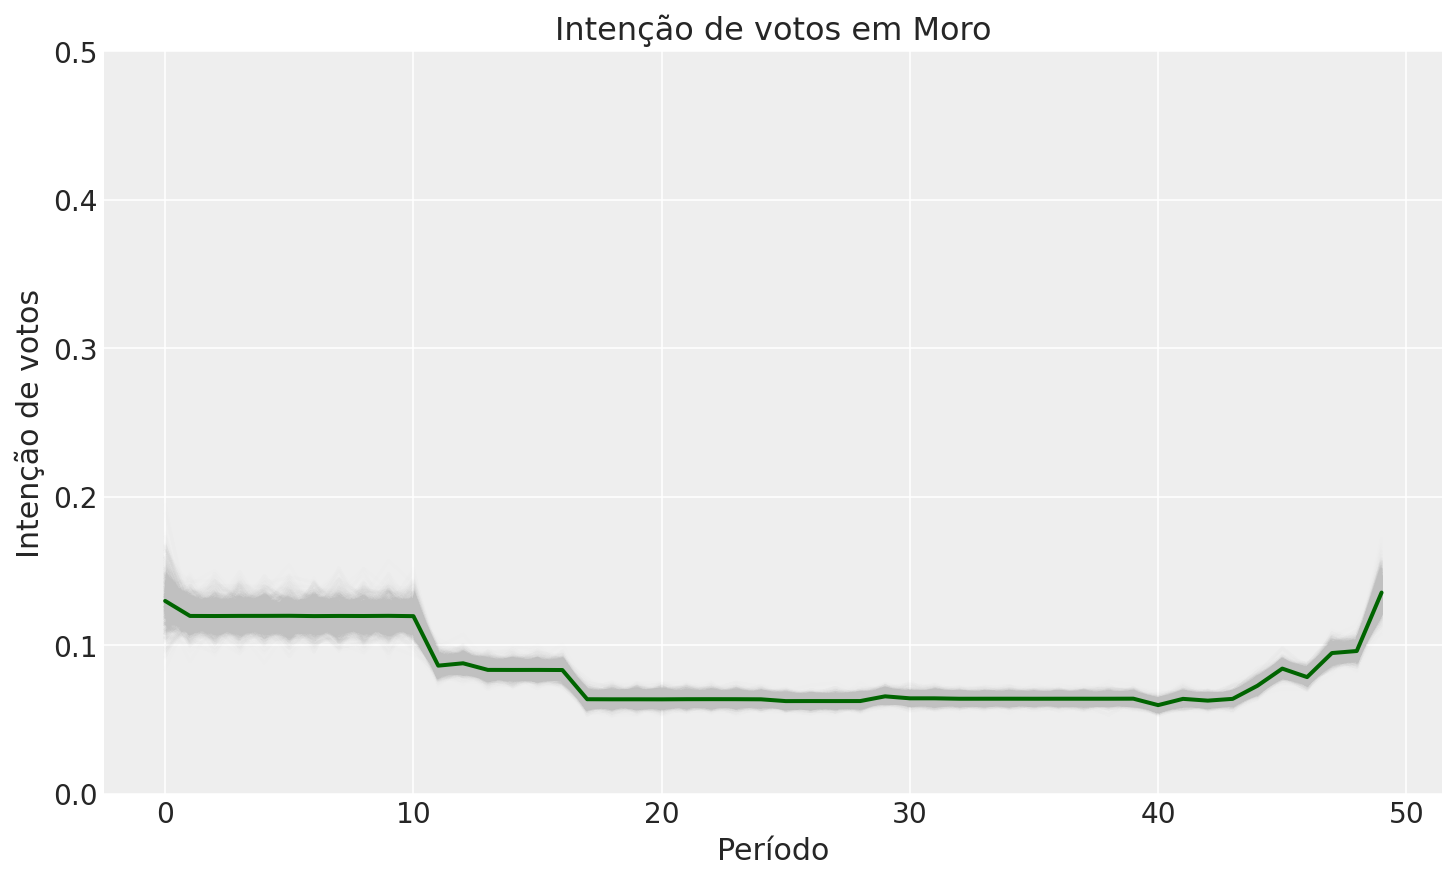

In [88]:
post_moro = logistic(trace_moro.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots(figsize=(10, 6))
for i in np.random.choice(post_moro.coords["sample"].size, size=1000):
    ax.plot(
        trace_moro.posterior.coords["temporal"],
        post_moro.isel(sample=i),
        alpha=0.01,
        color="silver",
    )
post_moro.mean("sample").plot(ax=ax, color="darkgreen", lw=2)
ax.set_title("Intenção de votos em Moro")
ax.set_ylabel("Intenção de votos")
ax.set_xlabel("Período")
ax.set_ylim(0, .5);

In [89]:
# az.plot_posterior(logistic(trace_moro.posterior["mu"].sel(mes=13)), hdi_prob=.95, round_to=2);

In [90]:
# az.plot_posterior(logistic(trace_moro.posterior["mu"]));

In [91]:
with intencao_coletiva:
    trace_moro.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_moro),
        )
    )
    
    
df['previsto'] = (trace_moro.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]


df = df[["date", "turno", "candidato", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Moro"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_moro.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_moro.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_moro.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_moro.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/moro_previsto.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## João Doria

In [92]:
df = data.query("candidato == 'Doria'").reset_index()

In [93]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date candidato  turno    voto   erro  amostra   day  \
0             Atlas 2021-03-14     Doria    1.0  0.0430  0.030   3721.0  10.0   
1             Atlas 2021-03-21     Doria    1.0  0.0430    NaN   3721.0   NaN   
2             Atlas 2021-03-28     Doria    1.0  0.0430    NaN   3721.0   NaN   
3             Atlas 2021-04-04     Doria    1.0  0.0430    NaN   3721.0   NaN   
4             Atlas 2021-04-11     Doria    1.0  0.0430    NaN   3721.0   NaN   
..              ...        ...       ...    ...     ...    ...      ...   ...   
258  Ranking Brasil 2021-09-05     Doria    1.0  0.0327    NaN   3000.0   NaN   
259  Ranking Brasil 2021-09-12     Doria    1.0  0.0327    NaN   3000.0   NaN   
260  Ranking Brasil 2021-09-19     Doria    1.0  0.0327    NaN   3000.0   NaN   
261  Ranking Brasil 2021-09-26     Doria    1.0  0.0320  0.020   4000.0  20.0   
262      Vox Populi 2021-11-07     Doria    1.0  0.0100  0.022   2000.0   4.0   

     month  week    year  num_voto  
0      3.0  10.0  2021.0     160.0  
1      NaN  10.0     NaN     160.0  
2      NaN  10.0     NaN     160.0  
3      NaN  10.0     NaN     160.0  
4      NaN  10.0     NaN     160.0  
..     ...   ...     ...       ...  
258    NaN  22.0     NaN      98.0  
259    NaN  22.0     NaN      98.0  
260    NaN  22.0     NaN      98.0  
261    9.0  38.0  2021.0     128.0  
262   11.0  44.0  2021.0      20.0  

[263 rows x 12 columns]

In [94]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 57, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 44, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61

In [95]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [96]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [97]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_doria = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 162 seconds.


0, dim: observacao, 263 =? 263


The number of effective samples is smaller than 10% for some parameters.


In [98]:
# az.summary(trace_doria, round_to=2, var_names=["~intencao"])

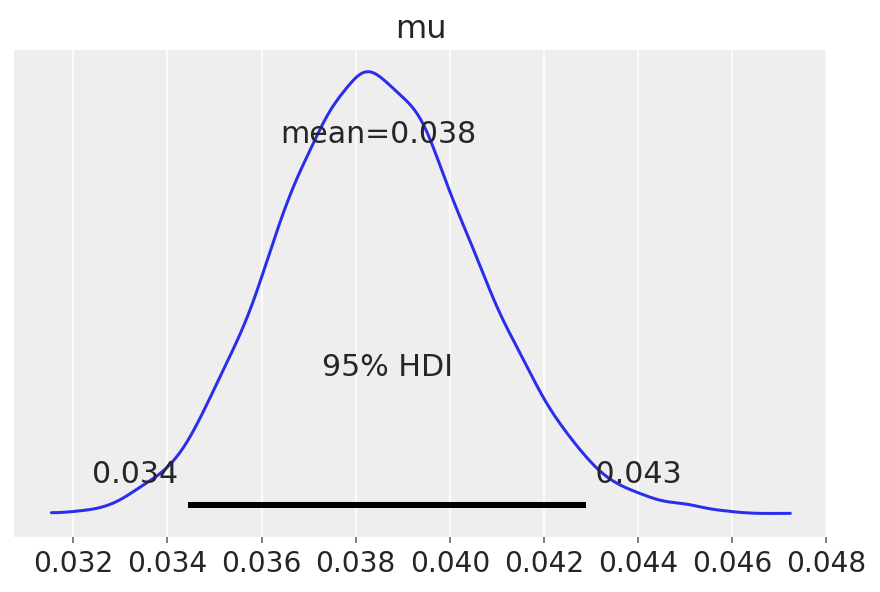

In [99]:
az.plot_posterior(logistic(trace_doria.posterior["mu"].sel(temporal=60)), hdi_prob=.95, round_to=2);

In [100]:
media_vies = trace_doria.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas            
Atlas           0.11
Brasmarket     -0.17
Datafolha       0.07
Futura         -0.24
IDEIA           0.08
Ipec            0.21
Ipespe         -0.43
Orbis          -0.14
Paraná          0.38
PoderData       0.11
Ponteio         0.02
Quaest          0.40
Ranking Brasil -0.16
Vox Populi     -0.23

In [101]:
with intencao_coletiva:
    trace_doria.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_doria),
        )
    )
    
    
df['previsto'] = (trace_doria.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]


df = df[["date", "turno", "candidato", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Doria"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_doria.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_doria.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_doria.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_doria.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/doria_previsto.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Eduardo Leite

In [102]:
df = data.query("candidato == 'Eduardo Leite'").reset_index()

In [103]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date      candidato  turno   voto   erro  amostra  \
0            Atlas 2021-08-01  Eduardo Leite    1.0  0.031  0.020   2884.0   
1            Atlas 2021-08-08  Eduardo Leite    1.0  0.031    NaN   2884.0   
2            Atlas 2021-08-15  Eduardo Leite    1.0  0.031    NaN   2884.0   
3            Atlas 2021-08-22  Eduardo Leite    1.0  0.031    NaN   2884.0   
4            Atlas 2021-08-29  Eduardo Leite    1.0  0.031    NaN   2884.0   
..             ...        ...            ...    ...    ...    ...      ...   
71          Quaest 2021-10-24  Eduardo Leite    1.0  0.040    NaN   2048.0   
72          Quaest 2021-10-31  Eduardo Leite    1.0  0.040    NaN   2048.0   
73          Quaest 2021-11-07  Eduardo Leite    1.0  0.010  0.022   2063.0   
74  Ranking Brasil 2021-09-26  Eduardo Leite    1.0  0.017  0.020   4000.0   
75      Vox Populi 2021-11-07  Eduardo Leite    1.0  0.010  0.022   2000.0   

     day  month  week    year  num_voto  
0   29.0    7.0  30.0  2021.0      89.0  
1    NaN    NaN  30.0     NaN      89.0  
2    NaN    NaN  30.0     NaN      89.0  
3    NaN    NaN  30.0     NaN      89.0  
4    NaN    NaN  30.0     NaN      89.0  
..   ...    ...   ...     ...       ...  
71   NaN    NaN  39.0     NaN      81.0  
72   NaN    NaN  39.0     NaN      81.0  
73   6.0   11.0  44.0  2021.0      20.0  
74  20.0    9.0  38.0  2021.0      68.0  
75   4.0   11.0  44.0  2021.0      20.0  

[76 rows x 12 columns]

In [104]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([ 3,  4,  5,  6,  7,  8, 13,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 19, 16, 17, 18, 19, 20, 19,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 11, 17], dtype=int8)

In [105]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [106]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [107]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_leite = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 110 seconds.


0, dim: observacao, 76 =? 76


The number of effective samples is smaller than 25% for some parameters.


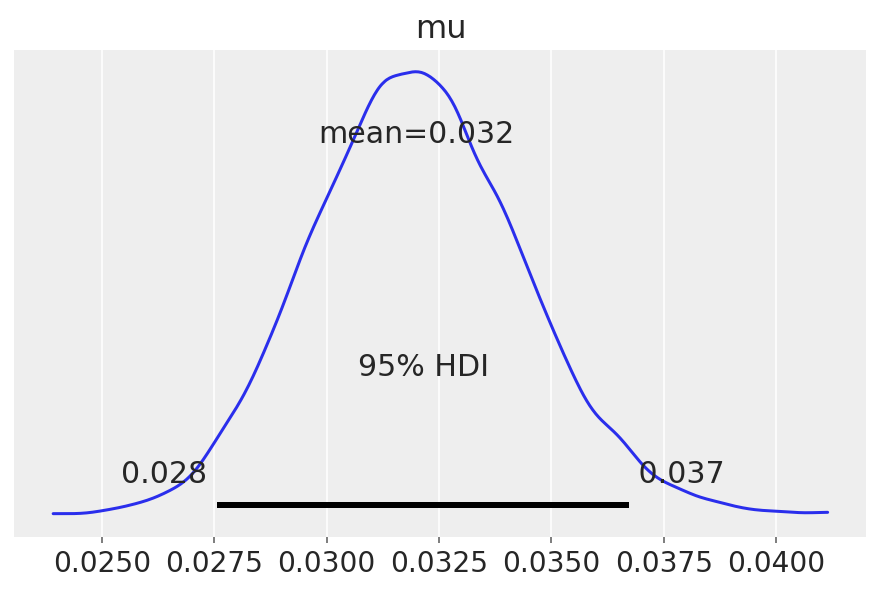

In [108]:
az.plot_posterior(logistic(trace_leite.posterior["mu"].sel(temporal=16)), hdi_prob=.95, round_to=2);

In [109]:
media_vies = trace_leite.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas            
Atlas           0.16
Brasmarket     -0.14
Datafolha       0.21
Futura         -0.43
Ipespe          0.36
Paraná         -0.10
PoderData       0.06
Ponteio        -0.03
Quaest          0.15
Ranking Brasil -0.07
Vox Populi     -0.17

In [110]:
with intencao_coletiva:
    trace_leite.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_leite),
        )
    )
    
    
df['previsto'] = (trace_leite.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]


df = df[["date", "turno", "candidato", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Eduardo Leite"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_leite.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_leite.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_leite.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_leite.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/leite_previsto.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Henrique mandetta

In [111]:
df = data.query("candidato == 'Henrique Mandetta'").reset_index()

In [112]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date          candidato  turno   voto   erro  \
0             Atlas 2021-03-14  Henrique Mandetta    1.0  0.044  0.030   
1             Atlas 2021-03-21  Henrique Mandetta    1.0  0.044    NaN   
2             Atlas 2021-03-28  Henrique Mandetta    1.0  0.044    NaN   
3             Atlas 2021-04-04  Henrique Mandetta    1.0  0.044    NaN   
4             Atlas 2021-04-11  Henrique Mandetta    1.0  0.044    NaN   
..              ...        ...                ...    ...    ...    ...   
216  Ranking Brasil 2021-09-05  Henrique Mandetta    1.0  0.021    NaN   
217  Ranking Brasil 2021-09-12  Henrique Mandetta    1.0  0.021    NaN   
218  Ranking Brasil 2021-09-19  Henrique Mandetta    1.0  0.021    NaN   
219  Ranking Brasil 2021-09-26  Henrique Mandetta    1.0  0.020  0.020   
220      Vox Populi 2021-11-07  Henrique Mandetta    1.0  0.010  0.022   

     amostra   day  month  week    year  num_voto  
0     3721.0  10.0    3.0  10.0  2021.0     163.0  
1     3721.0   NaN    NaN  10.0     NaN     163.0  
2     3721.0   NaN    NaN  10.0     NaN     163.0  
3     3721.0   NaN    NaN  10.0     NaN     163.0  
4     3721.0   NaN    NaN  10.0     NaN     163.0  
..       ...   ...    ...   ...     ...       ...  
216   3000.0   NaN    NaN  22.0     NaN      63.0  
217   3000.0   NaN    NaN  22.0     NaN      63.0  
218   3000.0   NaN    NaN  22.0     NaN      63.0  
219   4000.0  20.0    9.0  38.0  2021.0      80.0  
220   2000.0   4.0   11.0  44.0  2021.0      20.0  

[221 rows x 12 columns]

In [113]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 57, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 44, 63, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 63, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 61],
      dtype=int8)

In [114]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [115]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [116]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_mandetta = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 160 seconds.


0, dim: observacao, 221 =? 221


The number of effective samples is smaller than 25% for some parameters.


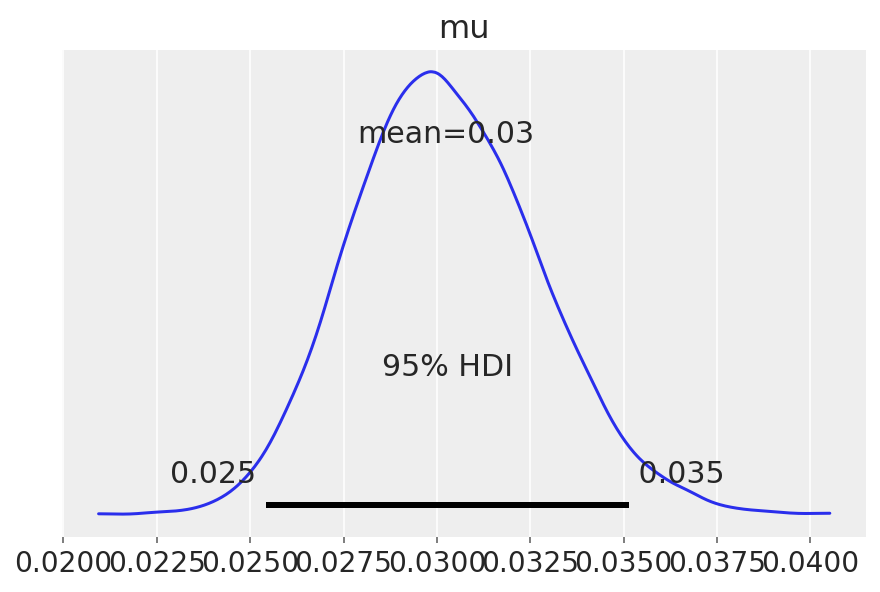

In [117]:
az.plot_posterior(logistic(trace_mandetta.posterior["mu"].sel(temporal=60)), hdi_prob=.95, round_to=2);

In [118]:
media_vies = trace_mandetta.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas            
Atlas           0.41
Brasmarket     -0.20
Datafolha       0.07
Futura         -0.17
IDEIA           0.55
Ipec            0.01
Ipespe          0.03
Orbis          -0.08
Paraná         -0.19
PoderData       0.10
Ponteio        -0.04
Quaest          0.03
Ranking Brasil -0.31
Vox Populi     -0.22

In [119]:
with intencao_coletiva:
    trace_mandetta.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_mandetta),
        )
    )
    
    
    
df['previsto'] = (trace_mandetta.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]

df = df[["date", "turno", "candidato", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Henrique Mandetta"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_mandetta.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_mandetta.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_mandetta.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_mandetta.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/mandetta_previsto.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Salvar dados

In [120]:
bolsonaro = pd.read_csv("../data/bolsonaro_previsto.csv", sep=";", index_col=None, parse_dates=True)
lula = pd.read_csv("../data/lula_previsto.csv", sep=";", index_col=None, parse_dates=True)
ciro = pd.read_csv("../data/ciro_previsto.csv", sep=";", index_col=None, parse_dates=True)
moro = pd.read_csv("../data/moro_previsto.csv", sep=";", index_col=None, parse_dates=True)
doria = pd.read_csv("../data/doria_previsto.csv", sep=";", index_col=None, parse_dates=True)
leite = pd.read_csv("../data/leite_previsto.csv", sep=";", index_col=None, parse_dates=True)
mandetta = pd.read_csv("../data/mandetta_previsto.csv", sep=";", index_col=None, parse_dates=True)
indeciso = pd.read_csv("../data/indeciso_previsto.csv", sep=";", index_col=None, parse_dates=True)
nulo = pd.read_csv("../data/nulo_previsto.csv", sep=";", index_col=None, parse_dates=True)

dados_1t = pd.concat([bolsonaro, lula, ciro, moro, doria, leite, mandetta, indeciso, nulo])
dados_1t["turno"] = dados_1t["turno"].astype(int)

# Salve database to chart
dados_1t.to_csv('../data/intencao_previsto_1t.csv', header=True, decimal=',', sep=';', float_format='%.3f', encoding='utf-8', mode = 'w', index=False)

# remover arquivos individuais
os.remove("../data/bolsonaro_previsto.csv")
os.remove("../data/lula_previsto.csv")
os.remove("../data/ciro_previsto.csv")
os.remove("../data/moro_previsto.csv")
os.remove("../data/doria_previsto.csv")
os.remove("../data/leite_previsto.csv")
os.remove("../data/mandetta_previsto.csv")
os.remove("../data/indeciso_previsto.csv")
os.remove("../data/nulo_previsto.csv")

In [121]:
dados_1t

date  turno  previsto    candidato  hdi_50_lower  hdi_50_higher  \
0   2020-09-06      1     0.309    Bolsonaro         0.291          0.310   
1   2020-09-13      1     0.309    Bolsonaro         0.291          0.310   
2   2020-09-20      1     0.309    Bolsonaro         0.292          0.311   
3   2020-09-27      1     0.309    Bolsonaro         0.290          0.310   
4   2020-10-04      1     0.309    Bolsonaro         0.292          0.311   
..         ...    ...       ...          ...           ...            ...   
60  2021-10-31      1     0.073  Branco/Nulo         0.070          0.074   
61  2021-11-07      1     0.093  Branco/Nulo         0.096          0.102   
62  2021-11-14      1     0.089  Branco/Nulo         0.080          0.085   
63  2021-11-21      1     0.075  Branco/Nulo         0.066          0.070   
64  2021-11-28      1     0.070  Branco/Nulo         0.073          0.081   

    hdi_90_lower  hdi_90_higher  
0          0.277          0.325  
1          0.277          0.325  
2          0.277          0.325  
3          0.277          0.324  
4          0.278          0.325  
..           ...            ...  
60         0.067          0.078  
61         0.093          0.106  
62         0.076          0.089  
63         0.063          0.073  
64         0.067          0.087  

[526 rows x 8 columns]

In [122]:
resultado = dados_1t.pivot(index='date', columns='candidato', values='previsto')

resultado['Outros'] =  (1 - resultado.loc[:, ['Bolsonaro', 'Lula', 'Moro', 'Indecisos', 'Branco/Nulo']].sum(axis=1))


resultado

candidato   Bolsonaro  Branco/Nulo   Ciro  Doria  Eduardo Leite  \
date                                                              
2020-09-06      0.309        0.070  0.060  0.030            NaN   
2020-09-13      0.309        0.070  0.060  0.030            NaN   
2020-09-20      0.309        0.070  0.060  0.030            NaN   
2020-09-27      0.309        0.070  0.060  0.030            NaN   
2020-10-04      0.309        0.070  0.060  0.030            NaN   
...               ...          ...    ...    ...            ...   
2021-10-31      0.282        0.073  0.084  0.042          0.034   
2021-11-07      0.268        0.093  0.068  0.030          0.021   
2021-11-14      0.305        0.089  0.079  0.040          0.029   
2021-11-21      0.285        0.075  0.060  0.030          0.021   
2021-11-28      0.270        0.070  0.090  0.050          0.050   

candidato   Henrique Mandetta  Indecisos   Lula   Moro  Outros  
date                                                            
2020-09-06              0.040      0.070  0.169  0.129   0.253  
2020-09-13              0.040      0.070  0.169    NaN   0.382  
2020-09-20              0.040      0.070  0.169    NaN   0.382  
2020-09-27              0.040      0.070  0.169    NaN   0.382  
2020-10-04              0.040      0.070  0.169    NaN   0.382  
...                       ...        ...    ...    ...     ...  
2021-10-31              0.030      0.040  0.377  0.101   0.127  
2021-11-07              0.024      0.048  0.402  0.085   0.104  
2021-11-14              0.030      0.027  0.346  0.104   0.129  
2021-11-21              0.024      0.034  0.361  0.105   0.140  
2021-11-28              0.020      0.020  0.360  0.080   0.200  

[65 rows x 10 columns]

In [123]:
observado_1t = data.reset_index()[["date", "empresa", "candidato", "turno", "voto", "amostra"]]

observado_1t = observado_1t.query("candidato == 'Bolsonaro' | candidato == 'Lula' | \
                            candidato == 'Ciro' | candidato == 'Moro' | \
                            candidato == 'Doria' | candidato == 'Eduardo Leite' | \
                            candidato == 'Mandetta' | candidato == 'Branco/Nulo' | \
                            candidato == 'Indecisos' | candidato == 'Outros'")

# observado_1t["amostra"] = observado_1t["amostra"].astype(int)
# observado_1t["turno"] = observado_1t["turno"].astype(int)

observado_1t.round(3).to_csv('../data/intencao_observado_2022.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

In [124]:
observado_1t

date     empresa      candidato  turno   voto  amostra
1    2021-03-14       Atlas      Bolsonaro    1.0  0.327   3721.0
3    2021-03-14       Atlas    Branco/Nulo    1.0  0.061   3721.0
4    2021-03-14       Atlas           Ciro    1.0  0.075   3721.0
5    2021-03-14       Atlas          Doria    1.0  0.043   3721.0
10   2021-03-14       Atlas           Lula    1.0  0.244   3721.0
...         ...         ...            ...    ...    ...      ...
2215 2021-11-07  Vox Populi          Doria    1.0  0.010   2000.0
2216 2021-11-07  Vox Populi  Eduardo Leite    1.0  0.010   2000.0
2218 2021-11-07  Vox Populi      Indecisos    1.0  0.120   2000.0
2219 2021-11-07  Vox Populi           Lula    1.0  0.440   2000.0
2220 2021-11-07  Vox Populi           Moro    1.0  0.030   2000.0

[1723 rows x 6 columns]

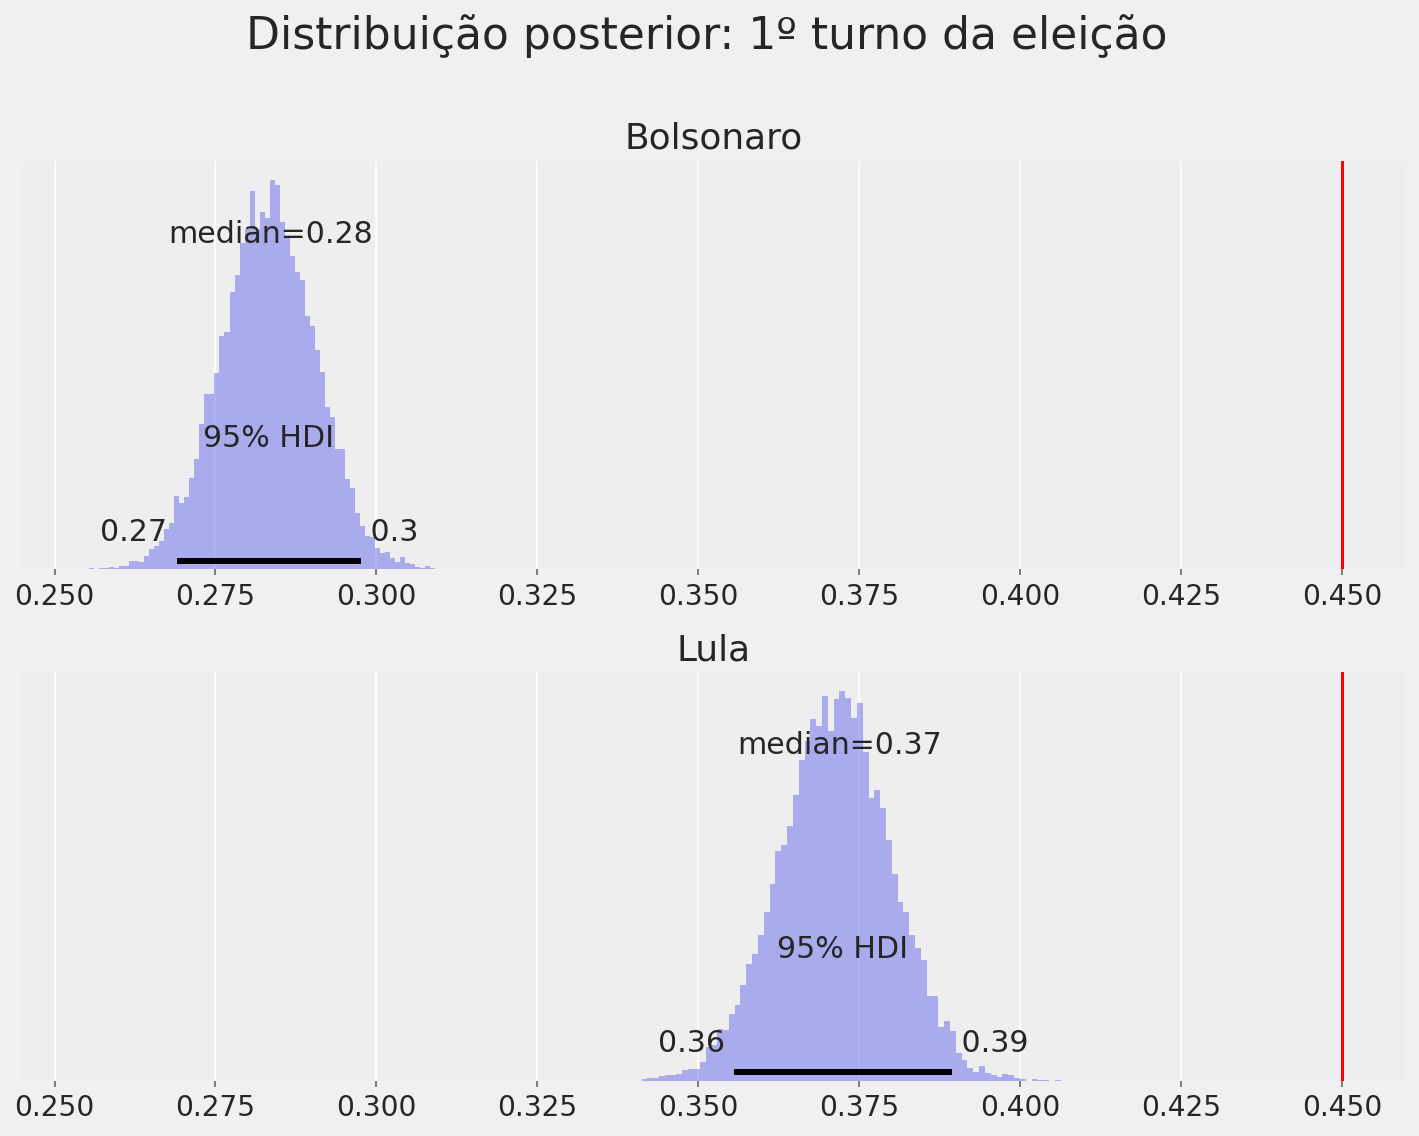

In [125]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, facecolor="#f0f0f0")

az.plot_posterior(logistic(
    trace_bolsonaro.posterior["mu"].sel(temporal = 59)), ax = axs[0], 
    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
axs[0].set_title(f"Bolsonaro", fontsize=18)
axs[0].axvline(x=0.45, color="red")

az.plot_posterior(logistic(
    trace_lula.posterior["mu"].sel(temporal = 59)), ax = axs[1], 
    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
axs[1].set_title(f"Lula", fontsize=18)
axs[1].axvline(x=0.45, color="red")

# az.plot_posterior(logistic(
#    trace_moro.posterior["mu"].sel(temporal = 45)), ax = axs[2], 
#    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
# axs[2].set_title(f"Distribuição Posterior de Moro", fontsize=18)
# axs[2].axvline(x=0.45, color="red")
fig.suptitle(f"Distribuição posterior: 1º turno da eleição\n", fontsize=22)
fig.tight_layout();


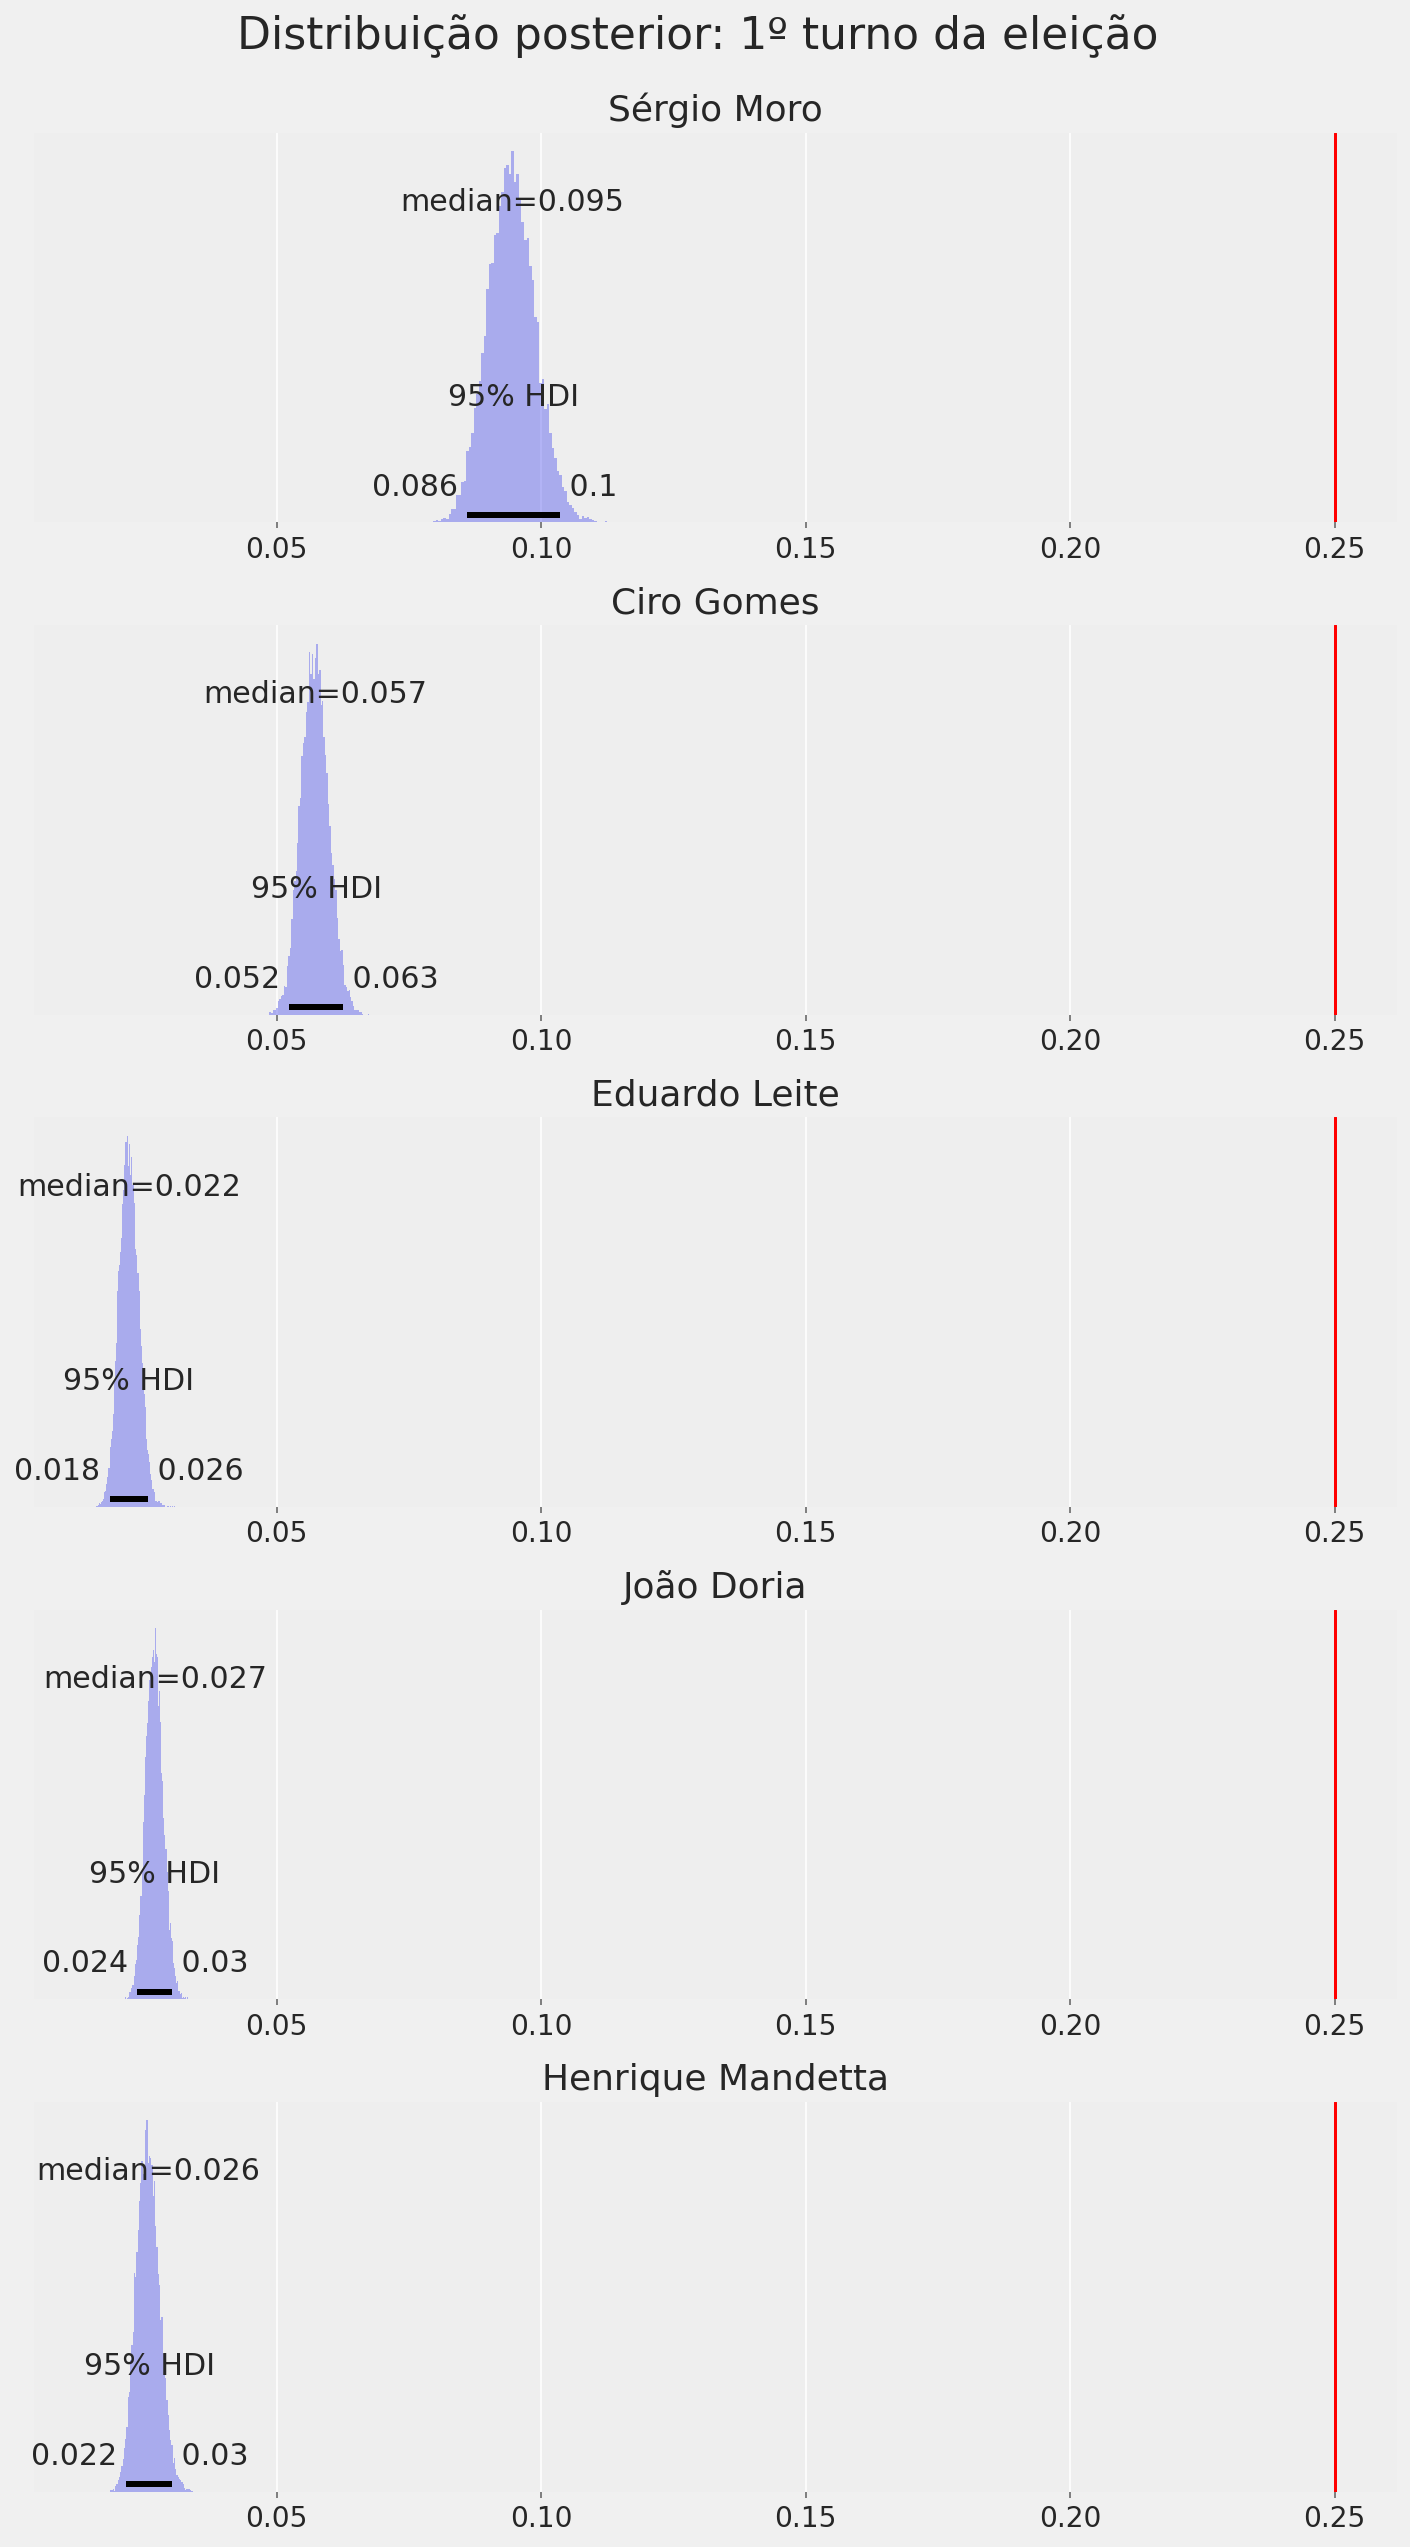

In [168]:
fig, axs = plt.subplots(5, 1, figsize=(10, 18), sharex=True, facecolor="#f0f0f0")

az.plot_posterior(logistic(
    trace_moro.posterior["mu"].sel(temporal = 47)), ax = axs[0], 
    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
axs[0].set_title(f"Sérgio Moro", fontsize=18)
axs[0].axvline(x=0.25, color="red")

az.plot_posterior(logistic(
    trace_ciro.posterior["mu"].sel(temporal = 61)), ax = axs[1], 
    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
axs[1].set_title(f"Ciro Gomes", fontsize=18)
axs[1].axvline(x=0.25, color="red")

az.plot_posterior(logistic(
    trace_leite.posterior["mu"].sel(temporal = 17)), ax = axs[2], 
    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
axs[2].set_title(f"Eduardo Leite", fontsize=18)
axs[2].axvline(x=0.25, color="red")

az.plot_posterior(logistic(
    trace_doria.posterior["mu"].sel(temporal = 61)), ax = axs[3], 
    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
axs[3].set_title(f"João Doria", fontsize=18)
axs[3].axvline(x=0.25, color="red")

az.plot_posterior(logistic(
    trace_mandetta.posterior["mu"].sel(temporal = 61)), ax = axs[4], 
    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
axs[4].set_title(f"Henrique Mandetta", fontsize=18)
axs[4].axvline(x=0.25, color="red")

fig.suptitle(f"Distribuição posterior: 1º turno da eleição\n", fontsize=22)
fig.tight_layout();



# Segundo turno

In [127]:
# Query para filtrar dados de interesse: 2 turno e pesquisas de intenção de votos apenas
file_long_sub = file_long.query("tipo == 'Bolsonaro x Lula' & turno == 2")

# Converte para datetime 
file_long_sub["date"] = pd.to_datetime(file_long_sub["date"])

# Index by field date
file_long_sub.set_index("date", inplace=True)

data = file_long_sub.groupby(["candidato", "empresa"]).resample("W").mean().reset_index(level=0).sort_index()

data

candidato  turno    voto   erro  amostra   day  \
empresa        date                                                           
Atlas          2021-03-14    Bolsonaro    2.0  0.3880  0.030   3721.0  10.0   
               2021-03-14  Branco/Nulo    2.0  0.1630  0.030   3721.0  10.0   
               2021-03-14         Lula    2.0  0.4490  0.030   3721.0  10.0   
               2021-03-21    Bolsonaro    NaN     NaN    NaN      NaN   NaN   
               2021-03-21  Branco/Nulo    NaN     NaN    NaN      NaN   NaN   
...                                ...    ...     ...    ...      ...   ...   
Ranking Brasil 2021-06-06         Lula    2.0  0.4707  0.025   3000.0   4.0   
Vox Populi     2021-11-07    Bolsonaro    2.0  0.2400  0.022   2000.0   4.0   
               2021-11-07  Branco/Nulo    2.0  0.1400  0.022   2000.0   4.0   
               2021-11-07    Indecisos    2.0  0.1000  0.022   2000.0   4.0   
               2021-11-07         Lula    2.0  0.5200  0.022   2000.0   4.0   

                           month  week    year  num_voto  
empresa        date                                       
Atlas          2021-03-14    3.0  10.0  2021.0    1443.0  
               2021-03-14    3.0  10.0  2021.0     606.0  
               2021-03-14    3.0  10.0  2021.0    1670.0  
               2021-03-21    NaN   NaN     NaN       NaN  
               2021-03-21    NaN   NaN     NaN       NaN  
...                          ...   ...     ...       ...  
Ranking Brasil 2021-06-06    6.0  22.0  2021.0    1412.0  
Vox Populi     2021-11-07   11.0  44.0  2021.0     480.0  
               2021-11-07   11.0  44.0  2021.0     280.0  
               2021-11-07   11.0  44.0  2021.0     200.0  
               2021-11-07   11.0  44.0  2021.0    1040.0  

[589 rows x 10 columns]

## Bolsonaro 2 turno 

In [128]:
df = data.query("candidato == 'Bolsonaro'").reset_index()

In [129]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date  candidato  turno    voto   erro  amostra  \
0             Atlas 2021-03-14  Bolsonaro    2.0  0.3880  0.030   3721.0   
1             Atlas 2021-03-21  Bolsonaro    2.0  0.3880    NaN   3721.0   
2             Atlas 2021-03-28  Bolsonaro    2.0  0.3880    NaN   3721.0   
3             Atlas 2021-04-04  Bolsonaro    2.0  0.3880    NaN   3721.0   
4             Atlas 2021-04-11  Bolsonaro    2.0  0.3880    NaN   3721.0   
..              ...        ...        ...    ...     ...    ...      ...   
165          Quaest 2021-10-24  Bolsonaro    2.0  0.2900    NaN   2048.0   
166          Quaest 2021-10-31  Bolsonaro    2.0  0.2900    NaN   2048.0   
167          Quaest 2021-11-07  Bolsonaro    2.0  0.2700  0.022   2063.0   
168  Ranking Brasil 2021-06-06  Bolsonaro    2.0  0.3513  0.025   3000.0   
169      Vox Populi 2021-11-07  Bolsonaro    2.0  0.2400  0.022   2000.0   

      day  month  week    year  num_voto  
0    10.0    3.0  10.0  2021.0    1443.0  
1     NaN    NaN  10.0     NaN    1443.0  
2     NaN    NaN  10.0     NaN    1443.0  
3     NaN    NaN  10.0     NaN    1443.0  
4     NaN    NaN  10.0     NaN    1443.0  
..    ...    ...   ...     ...       ...  
165   NaN    NaN  39.0     NaN     593.0  
166   NaN    NaN  39.0     NaN     593.0  
167   6.0   11.0  44.0  2021.0     557.0  
168   4.0    6.0  22.0  2021.0    1053.0  
169   4.0   11.0  44.0  2021.0     480.0  

[170 rows x 12 columns]

In [130]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 44, 63, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 63,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 39, 61],
      dtype=int8)

In [131]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [132]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [133]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_bolsonaro_t2 = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 159 seconds.


0, dim: observacao, 170 =? 170


The number of effective samples is smaller than 10% for some parameters.


In [134]:
map_estimate = pm.find_MAP(model=intencao_coletiva)
map_estimate['mu']

array([-0.57664827, -0.57664827, -0.57664827, -0.57664827, -0.57664827,
       -0.57664827, -0.57664827, -0.57664827, -0.57664827, -0.57664827,
       -0.57664827, -0.57664827, -0.57664827, -0.57664827, -0.57664827,
       -0.57664827, -0.57664827, -0.57664827, -0.57664827, -0.57664827,
       -0.57664827, -0.57664827, -0.57664827, -0.57664827, -0.57664827,
       -0.57664846, -0.5767043 , -0.59360207, -0.56925195, -0.56923972,
       -0.56923973, -0.56925745, -0.60457612, -0.604594  , -0.60459401,
       -0.60459401, -0.60459401, -0.60459401, -0.60459418, -0.60500719,
       -0.56784598, -0.56783628, -0.58558608, -0.56630515, -0.64776388,
       -0.65590094, -0.65592374, -0.69577911, -0.71829703, -0.71827877,
       -0.65944362, -0.68304512, -0.70679218, -0.70680216, -0.70408463,
       -0.71132185, -0.72418695, -0.72419471, -0.72420451, -0.74048336,
       -0.65383593, -0.68330534, -0.57735847, -0.58856029, -0.75763173])

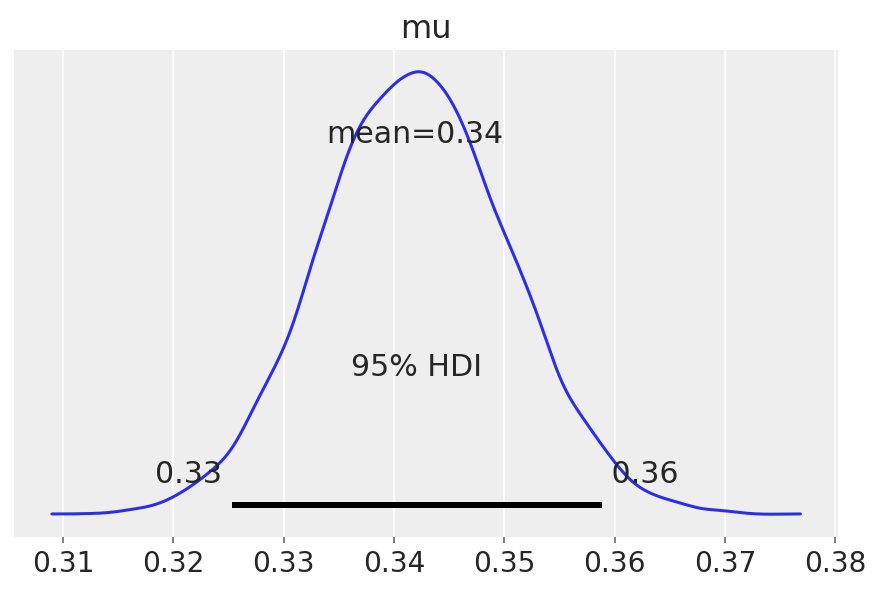

In [135]:
az.plot_posterior(logistic(trace_bolsonaro_t2.posterior["mu"].sel(temporal=60)), hdi_prob=.95, round_to=2);

In [136]:
media_vies = trace_bolsonaro_t2.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas            
Atlas           0.14
Datafolha      -0.11
Futura          0.17
IDEIA           0.25
Ipespe          0.05
Orbis           0.17
Paraná         -0.00
PoderData      -0.04
Ponteio        -0.11
Quaest         -0.14
Ranking Brasil -0.01
Vox Populi     -0.37

In [137]:
with intencao_coletiva:
    trace_bolsonaro_t2.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_bolsonaro_t2),
        )
    )
    
    
    
df['previsto'] = (trace_bolsonaro_t2.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]

df = df[["date", "turno", "candidato", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Bolsonaro"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_bolsonaro_t2.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_bolsonaro_t2.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_bolsonaro_t2.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_bolsonaro_t2.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/bolsonaro_previsto_2t.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Lula 2 turno

In [138]:
df = data.query("candidato == 'Lula'").reset_index()

In [139]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date candidato  turno    voto   erro  amostra   day  \
0             Atlas 2021-03-14      Lula    2.0  0.4490  0.030   3721.0  10.0   
1             Atlas 2021-03-21      Lula    2.0  0.4490    NaN   3721.0   NaN   
2             Atlas 2021-03-28      Lula    2.0  0.4490    NaN   3721.0   NaN   
3             Atlas 2021-04-04      Lula    2.0  0.4490    NaN   3721.0   NaN   
4             Atlas 2021-04-11      Lula    2.0  0.4490    NaN   3721.0   NaN   
..              ...        ...       ...    ...     ...    ...      ...   ...   
165          Quaest 2021-10-24      Lula    2.0  0.5300    NaN   2048.0   NaN   
166          Quaest 2021-10-31      Lula    2.0  0.5300    NaN   2048.0   NaN   
167          Quaest 2021-11-07      Lula    2.0  0.5700  0.022   2063.0   6.0   
168  Ranking Brasil 2021-06-06      Lula    2.0  0.4707  0.025   3000.0   4.0   
169      Vox Populi 2021-11-07      Lula    2.0  0.5200  0.022   2000.0   4.0   

     month  week    year  num_voto  
0      3.0  10.0  2021.0    1670.0  
1      NaN  10.0     NaN    1670.0  
2      NaN  10.0     NaN    1670.0  
3      NaN  10.0     NaN    1670.0  
4      NaN  10.0     NaN    1670.0  
..     ...   ...     ...       ...  
165    NaN  39.0     NaN    1085.0  
166    NaN  39.0     NaN    1085.0  
167   11.0  44.0  2021.0    1175.0  
168    6.0  22.0  2021.0    1412.0  
169   11.0  44.0  2021.0    1040.0  

[170 rows x 12 columns]

In [140]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 44, 63, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 63,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 39, 61],
      dtype=int8)

In [141]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [142]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [143]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_lula_t2 = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 154 seconds.


0, dim: observacao, 170 =? 170


The number of effective samples is smaller than 10% for some parameters.


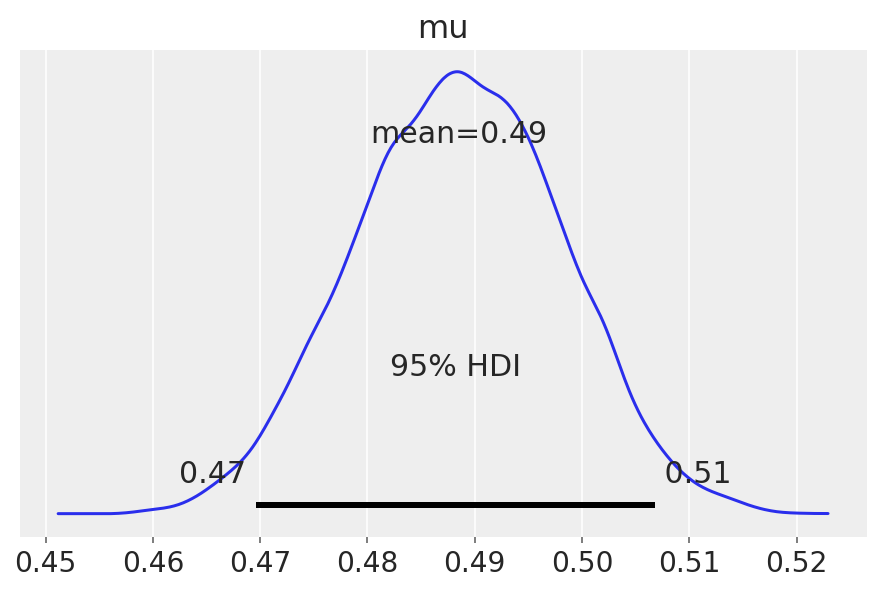

In [144]:
az.plot_posterior(logistic(trace_lula_t2.posterior["mu"].sel(temporal=60)), hdi_prob=.95, round_to=2);

In [145]:
media_vies = trace_lula_t2.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas            
Atlas          -0.01
Datafolha       0.33
Futura         -0.04
IDEIA          -0.53
Ipespe         -0.01
Orbis          -0.04
Paraná         -0.20
PoderData       0.18
Ponteio         0.05
Quaest          0.18
Ranking Brasil  0.04
Vox Populi      0.07

In [146]:
with intencao_coletiva:
    trace_lula_t2.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_lula_t2),
        )
    )
    
    
df['previsto'] = (trace_lula_t2.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]

df = df[["date", "turno", "candidato", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Lula"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_lula_t2.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_lula_t2.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_lula_t2.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_lula_t2.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/lula_previsto_2t.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Indecisos 2 turno

In [147]:
df = data.query("candidato == 'Indecisos'").reset_index()

In [148]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date  candidato  turno  voto   erro  amostra  day  \
0     Datafolha 2021-07-11  Indecisos    2.0  0.01  0.020   2074.0  8.0   
1     Datafolha 2021-07-18  Indecisos    2.0  0.01    NaN   2074.0  NaN   
2     Datafolha 2021-07-25  Indecisos    2.0  0.01    NaN   2074.0  NaN   
3     Datafolha 2021-08-01  Indecisos    2.0  0.01    NaN   2074.0  NaN   
4     Datafolha 2021-08-08  Indecisos    2.0  0.01    NaN   2074.0  NaN   
..          ...        ...        ...    ...   ...    ...      ...  ...   
98       Quaest 2021-10-17  Indecisos    2.0  0.02    NaN   2048.0  NaN   
99       Quaest 2021-10-24  Indecisos    2.0  0.02    NaN   2048.0  NaN   
100      Quaest 2021-10-31  Indecisos    2.0  0.02    NaN   2048.0  NaN   
101      Quaest 2021-11-07  Indecisos    2.0  0.03  0.022   2063.0  6.0   
102  Vox Populi 2021-11-07  Indecisos    2.0  0.10  0.022   2000.0  4.0   

     month  week    year  num_voto  
0      7.0  27.0  2021.0      20.0  
1      NaN  27.0     NaN      20.0  
2      NaN  27.0     NaN      20.0  
3      NaN  27.0     NaN      20.0  
4      NaN  27.0     NaN      20.0  
..     ...   ...     ...       ...  
98     NaN  39.0     NaN      40.0  
99     NaN  39.0     NaN      40.0  
100    NaN  39.0     NaN      40.0  
101   11.0  44.0  2021.0      61.0  
102   11.0  44.0  2021.0     200.0  

[103 rows x 12 columns]

In [149]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 62, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 62, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       60], dtype=int8)

In [150]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [151]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [152]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_indeciso_t2 = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 129 seconds.


0, dim: observacao, 103 =? 103


The number of effective samples is smaller than 10% for some parameters.


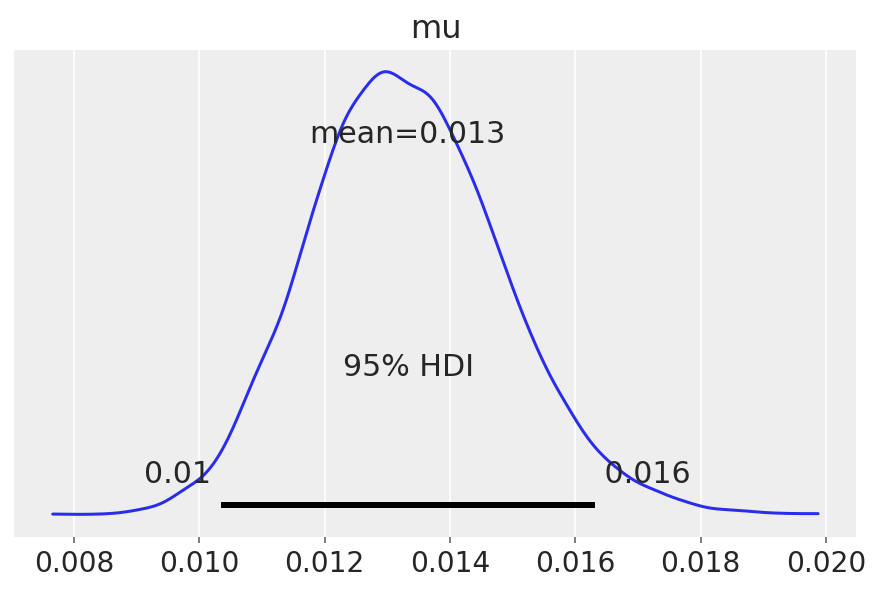

In [153]:
az.plot_posterior(logistic(trace_indeciso_t2.posterior["mu"].sel(temporal=59)), hdi_prob=.95, round_to=2);

In [154]:
media_vies = trace_indeciso_t2.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas        
Datafolha  -1.01
Futura     -0.72
IDEIA       0.01
Orbis       0.16
Paraná      0.27
PoderData   0.31
Ponteio     0.09
Quaest      0.11
Vox Populi  0.80

In [155]:
with intencao_coletiva:
    trace_indeciso_t2.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_indeciso_t2),
        )
    )
    
    
df['previsto'] = (trace_indeciso_t2.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]

df = df[["date", "turno", "candidato", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Indecisos"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_indeciso_t2.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_indeciso_t2.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_indeciso_t2.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_indeciso_t2.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/indeciso_previsto_2t.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Branco/Nulo 2 turno

In [156]:
df = data.query("candidato == 'Branco/Nulo'").reset_index()

In [157]:
df["voto"] = df.groupby(["candidato", "empresa"])["voto"].transform(lambda x: x.fillna(method='ffill'))
df["amostra"] = df.groupby(["candidato", "empresa"])["amostra"].transform(lambda x: x.fillna(method='ffill'))
df["num_voto"] = df.groupby(["candidato", "empresa"])["num_voto"].transform(lambda x: x.fillna(method='ffill'))
df["turno"] = df.groupby(["candidato", "empresa"])["turno"].transform(lambda x: x.fillna(method='ffill'))
df["week"] = df.groupby(["candidato", "empresa"])["week"].transform(lambda x: x.fillna(method='ffill'))
df

empresa       date    candidato  turno   voto   erro  amostra  \
0             Atlas 2021-03-14  Branco/Nulo    2.0  0.163  0.030   3721.0   
1             Atlas 2021-03-21  Branco/Nulo    2.0  0.163    NaN   3721.0   
2             Atlas 2021-03-28  Branco/Nulo    2.0  0.163    NaN   3721.0   
3             Atlas 2021-04-04  Branco/Nulo    2.0  0.163    NaN   3721.0   
4             Atlas 2021-04-11  Branco/Nulo    2.0  0.163    NaN   3721.0   
..              ...        ...          ...    ...    ...    ...      ...   
141          Quaest 2021-10-24  Branco/Nulo    2.0  0.150    NaN   2048.0   
142          Quaest 2021-10-31  Branco/Nulo    2.0  0.150    NaN   2048.0   
143          Quaest 2021-11-07  Branco/Nulo    2.0  0.130  0.022   2063.0   
144  Ranking Brasil 2021-06-06  Branco/Nulo    2.0  0.178  0.025   3000.0   
145      Vox Populi 2021-11-07  Branco/Nulo    2.0  0.140  0.022   2000.0   

      day  month  week    year  num_voto  
0    10.0    3.0  10.0  2021.0     606.0  
1     NaN    NaN  10.0     NaN     606.0  
2     NaN    NaN  10.0     NaN     606.0  
3     NaN    NaN  10.0     NaN     606.0  
4     NaN    NaN  10.0     NaN     606.0  
..    ...    ...   ...     ...       ...  
141   NaN    NaN  39.0     NaN     307.0  
142   NaN    NaN  39.0     NaN     307.0  
143   6.0   11.0  44.0  2021.0     268.0  
144   4.0    6.0  22.0  2021.0     534.0  
145   4.0   11.0  44.0  2021.0     280.0  

[146 rows x 12 columns]

In [158]:
empresa_id, empresas = df.set_index(
    ["empresa"]
).index.factorize(sort=True)
week_id = np.hstack(
    [
        pd.Categorical(
            df[df.candidato == candidato].date.dt.to_period("W")
        ).codes
        for candidato in df.candidato.unique()
    ]
)

weeks = np.arange(max(week_id) + 1)
week_id

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 44, 63, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 63, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 39, 61], dtype=int8)

In [159]:
COORDS = {
    "empresas": empresas,
    "temporal": weeks,
    "observacao": df.set_index(["empresa", "date"]).index,
}

In [160]:
with pm.Model(coords = COORDS) as intencao_coletiva:

    vies = pm.Normal("vies", mu=0, sd=0.10, dims="empresas")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="temporal")

    p = pm.Deterministic(
        "latente",
        pm.math.invlogit(mu[week_id] + vies[empresa_id]),
        dims = "observacao",
    )

    y = pm.Binomial(
        "intencao",
        p = p,
        n = df["amostra"],
        observed = df["num_voto"],
        dims = "observacao",
    )

In [161]:
CHAINS = 8
SEED = 12345
DRAWS = 2000

SAMPLE_KWARGS = {
    'tune': DRAWS,
    'draws': DRAWS,
    'cores': CHAINS,
    'chains': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True,
    'target_accept':0.98,
    'idata_kwargs':{
            "dims":{"temporal": ["mu"], "empresas": ["vies"]}
    }
}


with intencao_coletiva:
     # Explore and Sample the Parameter Space
    trace_nulo_t2 = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu, vies]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 155 seconds.


0, dim: observacao, 146 =? 146


The number of effective samples is smaller than 10% for some parameters.


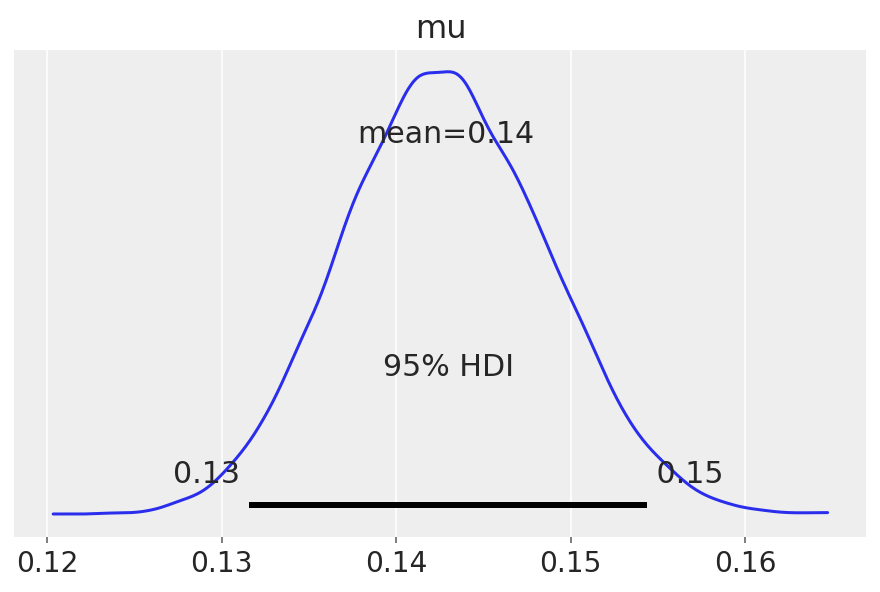

In [162]:
az.plot_posterior(logistic(trace_nulo_t2.posterior["mu"].sel(temporal=60)), hdi_prob=.95, round_to=2);

In [163]:
media_vies = trace_nulo_t2.posterior["vies"].mean(("chain", "draw")).to_dataframe()
media_vies.round(2)

vies
empresas            
Atlas           0.19
Datafolha      -0.18
Futura         -0.02
IDEIA           0.42
Ipespe          0.33
Orbis          -0.67
Paraná          0.23
PoderData      -0.35
Ponteio         0.05
Quaest         -0.21
Ranking Brasil  0.20
Vox Populi      0.01

In [164]:
with intencao_coletiva:
    trace_nulo_t2.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(trace_nulo_t2),
        )
    )
    
    
df['previsto'] = (trace_nulo_t2.posterior_predictive.mean(("chain", "draw"))["intencao"]) / df["amostra"]

df = df[["date", "turno", "candidato", "previsto"]]

# Converte para datetime 
df["date"] = pd.to_datetime(df["date"])

# Index by field date
df.set_index("date", inplace=True)

df_weeks = df.groupby(["date"]).resample("W").mean().reset_index(level=0).sort_index()

df_weeks['candidato'] = "Branco/Nulo"
df_weeks['hdi_50_lower'] = logistic(az.hdi(trace_nulo_t2.posterior, 0.50)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_50_higher'] = logistic(az.hdi(trace_nulo_t2.posterior, 0.50)["mu"]).sel(hdi="higher").values.flatten()
df_weeks['hdi_90_lower'] = logistic(az.hdi(trace_nulo_t2.posterior, 0.90)["mu"]).sel(hdi="lower").values.flatten()
df_weeks['hdi_90_higher'] = logistic(az.hdi(trace_nulo_t2.posterior, 0.90)["mu"]).sel(hdi="higher").values.flatten()

df_weeks.round(3).to_csv('../data/nulo_previsto_2t.csv', sep=";", encoding='utf-8', mode = 'w', index=False)

## Salvar dados

In [165]:
bolsonaro = pd.read_csv("../data/bolsonaro_previsto_2t.csv", sep=";", index_col=None, parse_dates=True)
lula = pd.read_csv("../data/lula_previsto_2t.csv", sep=";", index_col=None, parse_dates=True)
indeciso = pd.read_csv("../data/indeciso_previsto_2t.csv", sep=";", index_col=None, parse_dates=True)
nulo = pd.read_csv("../data/nulo_previsto_2t.csv", sep=";", index_col=None, parse_dates=True)

dados_2t = pd.concat([bolsonaro, lula, indeciso, nulo])
dados_2t["turno"] = dados_2t["turno"].astype(int)

# Salve database to chart
dados_2t.to_csv('../data/intencao_previsto_2t.csv', header=True, decimal=',', sep=';', float_format='%.3f', encoding='utf-8', mode = 'w', index=False)

# salva bd completo:
dados = pd.concat([dados_1t, dados_2t])

dados.to_csv('../data/intencao_previsto_2022.csv', header=True, decimal=',', sep=';', float_format='%.3f', encoding='utf-8', mode = 'w', index=False)

# remover arquivos individuais
os.remove("../data/bolsonaro_previsto_2t.csv")
os.remove("../data/lula_previsto_2t.csv")
os.remove("../data/indeciso_previsto_2t.csv")
os.remove("../data/nulo_previsto_2t.csv")


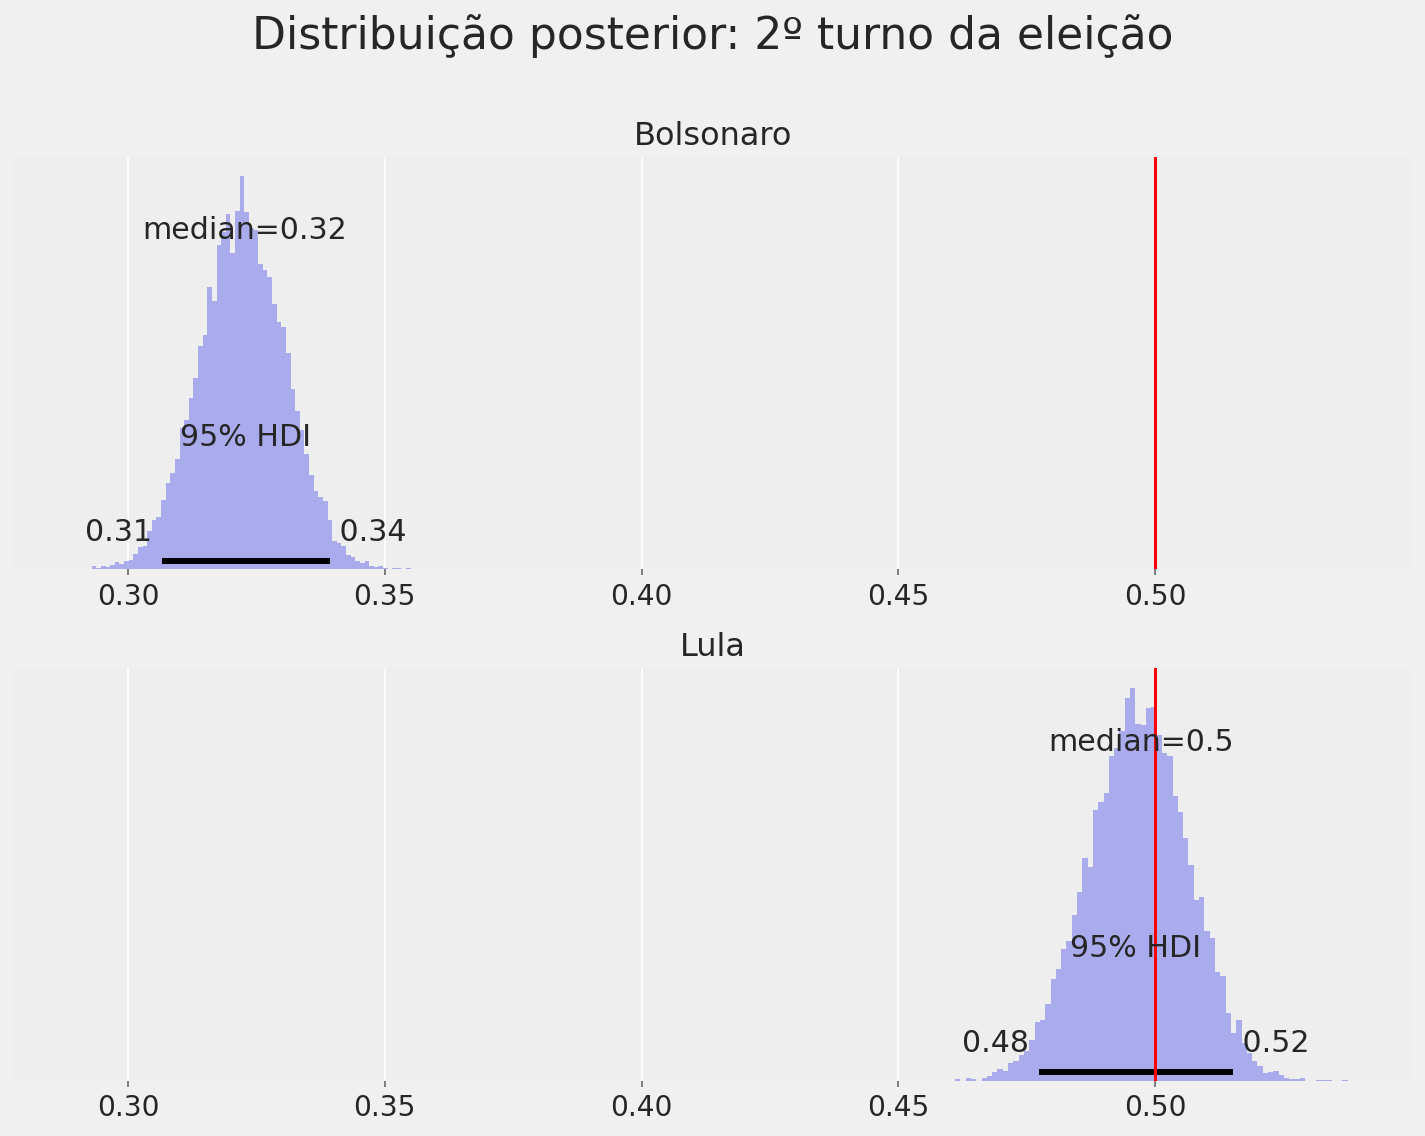

In [166]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, facecolor="#f0f0f0")

az.plot_posterior(logistic(
    trace_bolsonaro_t2.posterior["mu"].sel(temporal = 59)), ax = axs[0], 
    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
axs[0].set_title(f"Bolsonaro", fontsize=16)
axs[0].axvline(x=0.5, color="red")

az.plot_posterior(logistic(
    trace_lula_t2.posterior["mu"].sel(temporal = 59)), ax = axs[1], 
    kind='hist', point_estimate = 'median', hdi_prob=.95, round_to=2)
axs[1].set_title(f"Lula", fontsize=16)
axs[1].axvline(x=0.5, color="red")
fig.suptitle(f"Distribuição posterior: 2º turno da eleição\n", fontsize=22)
fig.tight_layout();

In [167]:
# Save imagem
ph = pm.model_to_graphviz(popularidade_hierarquica)
ph.render("popularidade_hierarquica_pres_efeito", format="png")

pm.model_to_graphviz(popularidade_hierarquica)

NameError: name 'popularidade_hierarquica' is not defined

In [ ]:
x_plot = np.linspace(0, 1, 100)
pbar = 0.4
theta = 10.0

plt.plot(
    x_plot,
    np.exp(pm.Beta.dist(pbar * theta, (1 - pbar) * theta).logp(x_plot).eval()),
    label=f"Beta({pbar * theta}, {(1 - pbar) * theta})",
)
plt.xlabel("Probabilidade")
plt.ylabel("Densidade")
plt.legend();

#### 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


data["date"] = pd.to_datetime(data["date"])

date = data["date"]
value = data["value"]

import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(8, 6))

# Same as above
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(date, value)

# Rotates and right aligns the x labels. 
# Also moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()